In [1]:
#!pip install yfinance plotext
#!pip install gym==0.25.2

In [4]:
# url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
# !curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
# url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
# !curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3

The training procedure was inspired by https://github.com/stefan-jansen/machine-learning-for-trading/blob/d938ca42b136ac93eb78e25c86cc27d330cc03d9/22_deep_reinforcement_learning/04_q_learning_for_trading.ipynb

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

import gym
from gym.envs.registration import register
from gym import spaces
from gym.utils import seeding

from collections import deque
from time import time
from random import sample

import yfinance as yf
import talib
from sklearn.preprocessing import StandardScaler

import random
import time
import datetime
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection

import os
import pickle

### Defining the trading agent

In [2]:
class DDQNAgent:
    def __init__(self, state_dim,
                 num_actions,
                 learning_rate,
                 gamma,
                 epsilon_start,
                 epsilon_end,
                 epsilon_decay_steps,
                 epsilon_exponential_decay,
                 replay_capacity,
                 architecture,
                 l2_reg,
                 tau,
                 batch_size,
                 decay_steps
                ):
        
        self.state_dim = state_dim
        self.decay_steps = decay_steps
        self.state_dim = state_dim
        self.num_actions = num_actions
        self.experience = deque([], maxlen=replay_capacity)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.architecture = architecture
        self.l2_reg = l2_reg

        self.online_network = self.build_model()
        self.target_network = self.build_model(trainable=False)
        self.update_target()

        self.epsilon = epsilon_start
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.epsilon_history = []

        self.total_steps = self.train_steps = 0
        self.episodes = self.episode_length = self.train_episodes = 0
        self.steps_per_episode = []
        self.episode_reward = 0
        self.rewards_history = []

        self.batch_size = batch_size
        self.tau = tau
        self.losses = []
        self.idx = tf.range(batch_size)
        self.train = True
        

    def load_ddqn(self, path):
        self.online_network = load_model(path)
        self.target_network = load_model(path)
        self.target_network.trainable = False

    def build_model(self, trainable=True):
        layers = []
        n = len(self.architecture)
        
        layers.append(tf.keras.layers.BatchNormalization(input_shape=(self.state_dim,)))
        for i, units in enumerate(self.architecture, 1):
            layers.append(Dense(units=units,
                                input_dim=self.state_dim if i == 1 else None,
                                activation='relu',
                                kernel_regularizer=l2(self.l2_reg),
                                name=f'Dense_{i}',
                                trainable=trainable))
            layers.append(Dropout(0.1))
        layers.append(Dense(units=self.num_actions,
                            trainable=trainable,
                            name='Output'))
        model = Sequential(layers)
        model.compile(loss='mean_squared_error',
                      optimizer=Adam(learning_rate=self.learning_rate))
        #optimizer=Adam(learning_rate=tf.keras.experimental.CosineDecay(initial_learning_rate=self.learning_rate, decay_steps=decay_steps)))
        return model

    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q = self.online_network.predict(state,verbose=0)
        return np.argmax(q, axis=1).squeeze() 
    
    def greedy_policy(self, state):
        self.total_steps += 1
        q = self.online_network.predict(state,verbose=0)
        return np.argmax(q, axis=1).squeeze() 

    def memorize_transition(self, s, a, r, s_prime, not_done):
        if not_done:
            self.episode_reward += r
            self.episode_length += 1
        else:
            if self.train:
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay

            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0

        self.experience.append((s, a, r, s_prime, not_done))

    def experience_replay(self):
        if self.batch_size > len(self.experience):
            return
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))
        states, actions, rewards, next_states, not_done = minibatch

        next_q_values = self.online_network.predict_on_batch(next_states)
        best_actions = tf.argmax(next_q_values, axis=1)

        next_q_values_target = self.target_network.predict_on_batch(next_states)
        target_q_values = tf.gather_nd(next_q_values_target,
                                       tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1))

        targets = rewards + not_done * self.gamma * target_q_values

        q_values = self.online_network.predict_on_batch(states)
        
        q_values[tuple([self.idx, actions])] = targets
        

        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)

        if self.total_steps % self.tau == 0:
            self.update_target()


def visualize(result):
    x = result.index.tolist()
    y = result['market_nav'].tolist()
    z = np.array(result['position'].tolist())


    cmap = ListedColormap(['r', 'y', 'g'])
    norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
    points = np.array([x, y]).T.reshape(-1, 1, 2)

    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(z)


    fig = plt.figure(figsize=(20, 10))
    plt.gca().add_collection(lc)
    #plt.xlim(min(x), max(x))
    #plt.ylim(min(y), max(y))

    plt.plot(result.index,result['nav'])
    plt.scatter(result.index[result["trade"]>0],result['market_nav'][result["trade"]>0]+0.002,c='g', marker="^", s=50)
    plt.scatter(result.index[result["trade"]<0],result['market_nav'][result["trade"]<0]-0.002,c='r', marker="v", s=50)
    plt.show()


    

In [3]:
trading_cost_bps = 0.001
time_cost_bps = 0

register(
    id='trading-v0',
    entry_point='trading_environment:TradingEnvironment',
    max_episode_steps=1225
)

In [4]:
feature_dict = {
    'core-set':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR'
    ],
    'news-set-1':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'count_news','count_opinions'
    ],
    'news-set-2':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'sent_title_news_1', 'sent_title_news_5','sent_title_news_21'
    ]
    ,
    'news-set-3':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'sent_title_opinions_1', 'sent_title_opinions_5','sent_title_opinions_21'
    ]
    ,
    'news-set-4':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'sent_content_news_1', 'sent_content_news_5','sent_content_news_21'
    ]
    ,
    'news-set-5':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'sent_content_opinions_1','sent_content_opinions_5', 'sent_content_opinions_21'
    ]
    ,
    'news-set-6':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'count_news','count_opinions',
        'sent_title_news_1', 'sent_title_news_5','sent_title_news_21',
        'sent_title_opinions_1', 'sent_title_opinions_5','sent_title_opinions_21',
        'sent_content_news_1', 'sent_content_news_5','sent_content_news_21',
        'sent_content_opinions_1','sent_content_opinions_5', 'sent_content_opinions_21'
    ],
    'twitter-set-1':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'tweetCount_cashtags','retweetCount_cashtags','tweetCount_keywords','retweetCount_keywords'
    ],
    'twitter-set-2':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'sent_tweeteval_cashtags_1', 'sent_tweeteval_cashtags_5','sent_tweeteval_cashtags_21'
        
    ],
    'twitter-set-3':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'sent_tweeteval_keywords_1','sent_tweeteval_keywords_5', 'sent_tweeteval_keywords_21',
    ],
    'twitter-set-4':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'tweetCount_cashtags','retweetCount_cashtags','tweetCount_keywords','retweetCount_keywords',
        'sent_tweeteval_cashtags_1', 'sent_tweeteval_cashtags_5','sent_tweeteval_cashtags_21',
        'sent_tweeteval_keywords_1','sent_tweeteval_keywords_5', 'sent_tweeteval_keywords_21',
    ],
    'full-set':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'count_news','count_opinions',
        'sent_title_news_1', 'sent_title_news_5','sent_title_news_21',
        'sent_title_opinions_1', 'sent_title_opinions_5','sent_title_opinions_21',
        'sent_content_news_1', 'sent_content_news_5','sent_content_news_21',
        'sent_content_opinions_1','sent_content_opinions_5', 'sent_content_opinions_21',
        'tweetCount_cashtags','retweetCount_cashtags','tweetCount_keywords','retweetCount_keywords',
        'sent_tweeteval_cashtags_1', 'sent_tweeteval_cashtags_5','sent_tweeteval_cashtags_21',
        'sent_tweeteval_keywords_1','sent_tweeteval_keywords_5', 'sent_tweeteval_keywords_21'
        
    ]

}

### Training the trading agent

news-set-5 | 0:00:00  | Train | 1    | TSLA  | Agent:  -37.2% | Market:   39.5% | Diff:  -76.7% | epsilon:  0.996 | loss: 0.00034291675547137856 | iterations: 0
news-set-5 | 0:00:01  | Train | 2    | TSLA  | Agent:  -39.3% | Market:  -12.2% | Diff:  -27.2% | epsilon:  0.991 | loss: 0.0003429229254834354 | iterations: 5
news-set-5 | 0:00:11  | Train | 3    | TSLA  | Agent:  -51.5% | Market:  -21.5% | Diff:  -29.9% | epsilon:  0.987 | loss: 0.0003444323083385825 | iterations: 257
news-set-5 | 0:00:21  | Train | 4    | TSLA  | Agent:  -10.0% | Market:   28.0% | Diff:  -38.0% | epsilon:  0.982 | loss: 0.000347291148500517 | iterations: 509
news-set-5 | 0:00:30  | Train | 5    | TSLA  | Agent:    6.2% | Market:  -24.2% | Diff:   30.4% | epsilon:  0.978 | loss: 0.0003465360205154866 | iterations: 761
news-set-5 | 0:00:40  | Train | 6    | TSLA  | Agent:  -26.4% | Market:  -12.1% | Diff:  -14.3% | epsilon:  0.973 | loss: 0.0003467578499112278 | iterations: 1013
news-set-5 | 0:00:50  | Train |

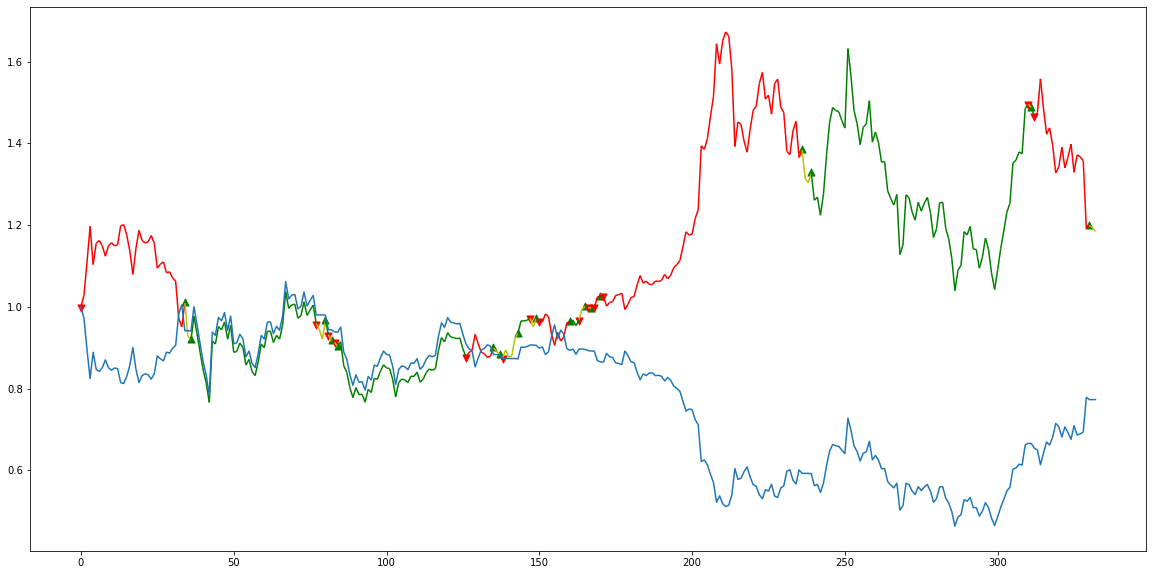

news-set-5 | 0:04:23  | Eval-dev | 25   | TSLA  | Agent:  -23.8% | Market:  696.4% | Diff: -720.3% | epsilon:  0.888 | loss: 0.0003583350917324424 | iterations: 5801


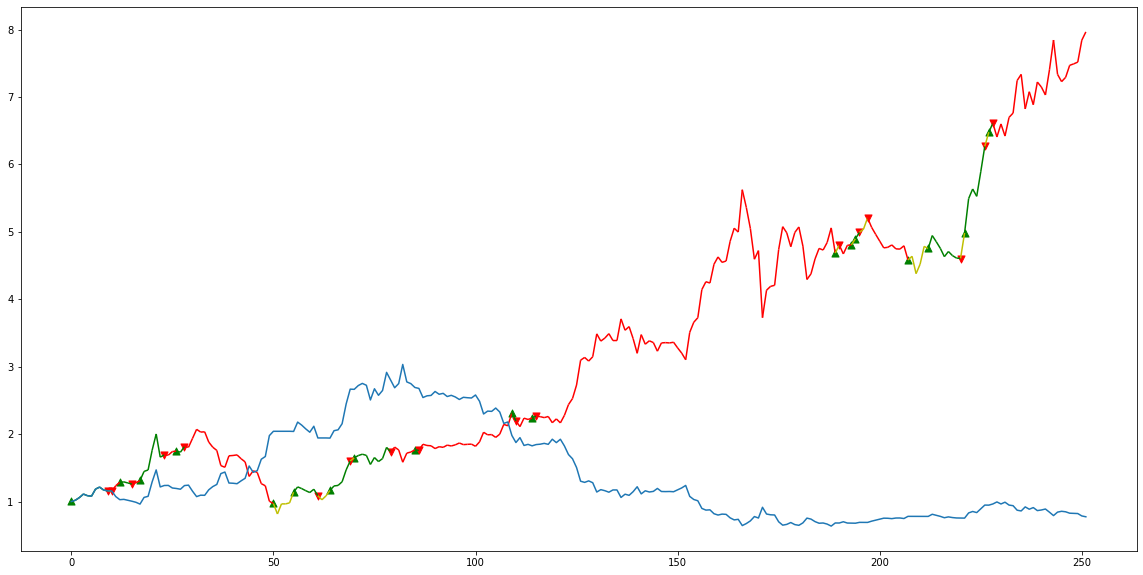

news-set-5 | 0:04:34  | Train | 26   | TSLA  | Agent:  -10.5% | Market:  -23.3% | Diff:   12.8% | epsilon:  0.883 | loss: 0.0003580243210308254 | iterations: 6053
news-set-5 | 0:04:45  | Train | 27   | TSLA  | Agent:   26.5% | Market:   12.4% | Diff:   14.1% | epsilon:  0.879 | loss: 0.00035757050500251353 | iterations: 6305
news-set-5 | 0:04:56  | Train | 28   | TSLA  | Agent:   63.7% | Market:   -7.2% | Diff:   70.9% | epsilon:  0.874 | loss: 0.00035723010660149157 | iterations: 6557
news-set-5 | 0:05:08  | Train | 29   | TSLA  | Agent:   -9.1% | Market:  -36.8% | Diff:   27.7% | epsilon:  0.870 | loss: 0.0003570221597328782 | iterations: 6809
news-set-5 | 0:05:20  | Train | 30   | TSLA  | Agent:  -17.5% | Market:  -16.3% | Diff:   -1.2% | epsilon:  0.865 | loss: 0.0003565845836419612 | iterations: 7061
news-set-5 | 0:05:31  | Train | 31   | TSLA  | Agent:  -12.5% | Market:  -34.4% | Diff:   21.9% | epsilon:  0.861 | loss: 0.00035609491169452667 | iterations: 7313
news-set-5 | 0:05:4

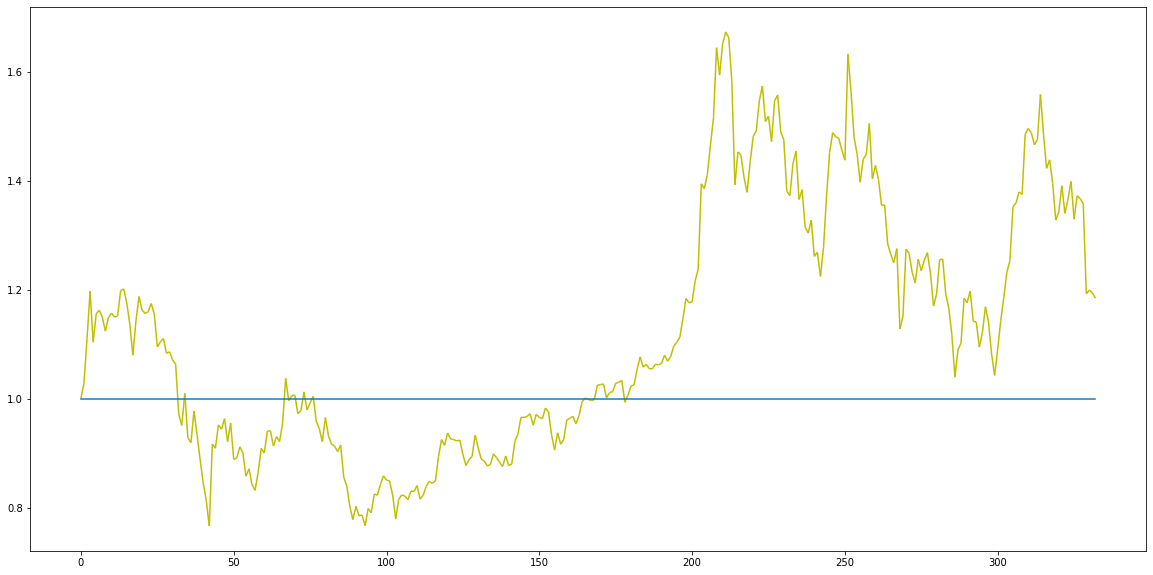

news-set-5 | 0:09:30  | Eval-dev | 50   | TSLA  | Agent:   56.6% | Market:  696.4% | Diff: -639.9% | epsilon:  0.775 | loss: 0.0003359876573085785 | iterations: 12101


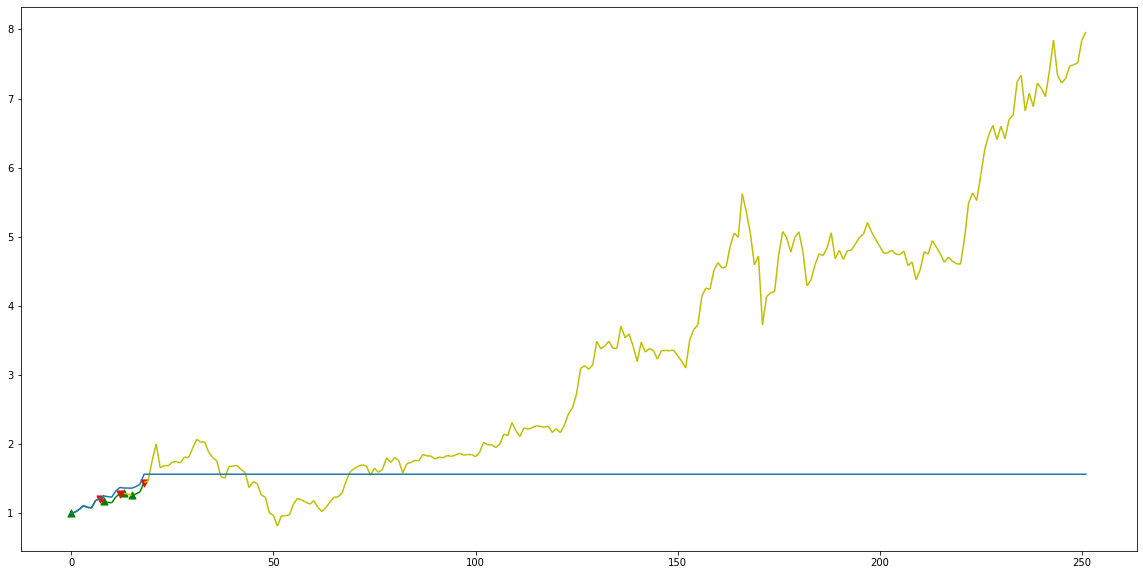

news-set-5 | 0:09:42  | Train | 51   | TSLA  | Agent:  -21.8% | Market:  -14.2% | Diff:   -7.6% | epsilon:  0.771 | loss: 0.0003341321717016399 | iterations: 12353
news-set-5 | 0:09:54  | Train | 52   | TSLA  | Agent:  -22.9% | Market:   -2.7% | Diff:  -20.1% | epsilon:  0.766 | loss: 0.00033198943128809333 | iterations: 12605
news-set-5 | 0:10:06  | Train | 53   | TSLA  | Agent:  -20.9% | Market:   32.3% | Diff:  -53.2% | epsilon:  0.762 | loss: 0.0003295011701993644 | iterations: 12857
news-set-5 | 0:10:18  | Train | 54   | TSLA  | Agent:  -21.0% | Market:   18.6% | Diff:  -39.6% | epsilon:  0.757 | loss: 0.0003269870358053595 | iterations: 13109
news-set-5 | 0:10:30  | Train | 55   | TSLA  | Agent:  -34.0% | Market:  -34.4% | Diff:    0.4% | epsilon:  0.753 | loss: 0.00032449050922878087 | iterations: 13361
news-set-5 | 0:10:42  | Train | 56   | TSLA  | Agent:   25.3% | Market:   55.2% | Diff:  -29.9% | epsilon:  0.748 | loss: 0.00032185690361075103 | iterations: 13613
news-set-5 | 

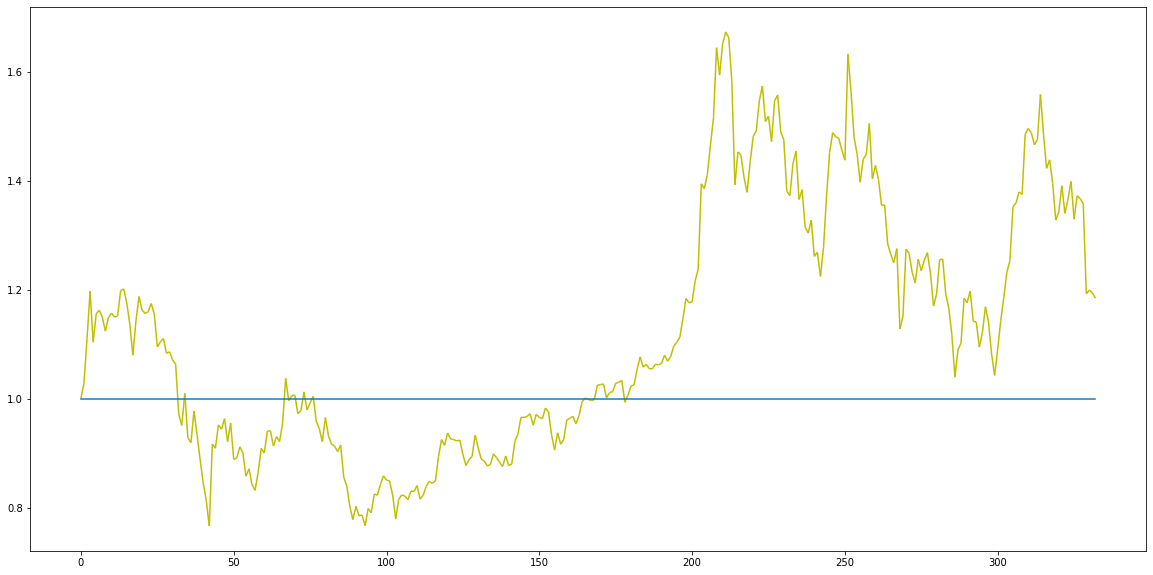

news-set-5 | 0:15:01  | Eval-dev | 75   | TSLA  | Agent:    0.0% | Market:  696.4% | Diff: -696.4% | epsilon:  0.663 | loss: 0.0002632739779073745 | iterations: 18401


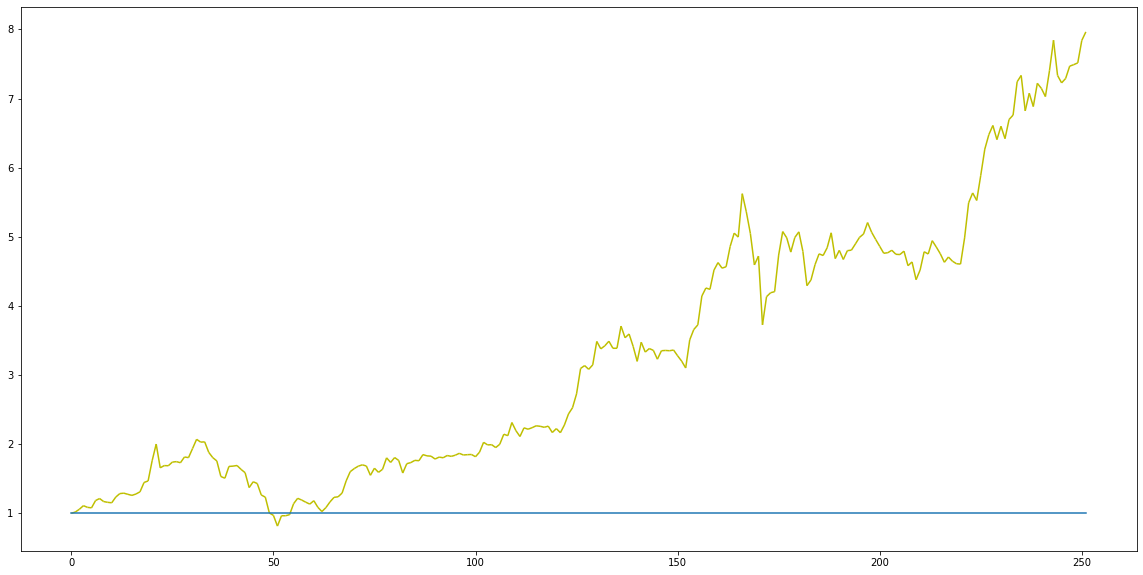

news-set-5 | 0:15:14  | Train | 76   | TSLA  | Agent:   -8.8% | Market:  -11.8% | Diff:    3.0% | epsilon:  0.658 | loss: 0.00026084601995535195 | iterations: 18653
news-set-5 | 0:15:27  | Train | 77   | TSLA  | Agent:  -28.6% | Market:   -3.0% | Diff:  -25.6% | epsilon:  0.654 | loss: 0.00025856305728666484 | iterations: 18905
news-set-5 | 0:15:41  | Train | 78   | TSLA  | Agent:  -66.6% | Market:    9.2% | Diff:  -75.8% | epsilon:  0.649 | loss: 0.0002557773841544986 | iterations: 19157
news-set-5 | 0:15:54  | Train | 79   | TSLA  | Agent:   41.5% | Market:   26.1% | Diff:   15.4% | epsilon:  0.645 | loss: 0.0002524473820813 | iterations: 19409
news-set-5 | 0:16:07  | Train | 80   | TSLA  | Agent:  103.7% | Market:   -7.8% | Diff:  111.5% | epsilon:  0.640 | loss: 0.0002488968602847308 | iterations: 19661
news-set-5 | 0:16:20  | Train | 81   | TSLA  | Agent:  -33.9% | Market:    0.1% | Diff:  -34.0% | epsilon:  0.636 | loss: 0.00024639166076667607 | iterations: 19913
news-set-5 | 0:1

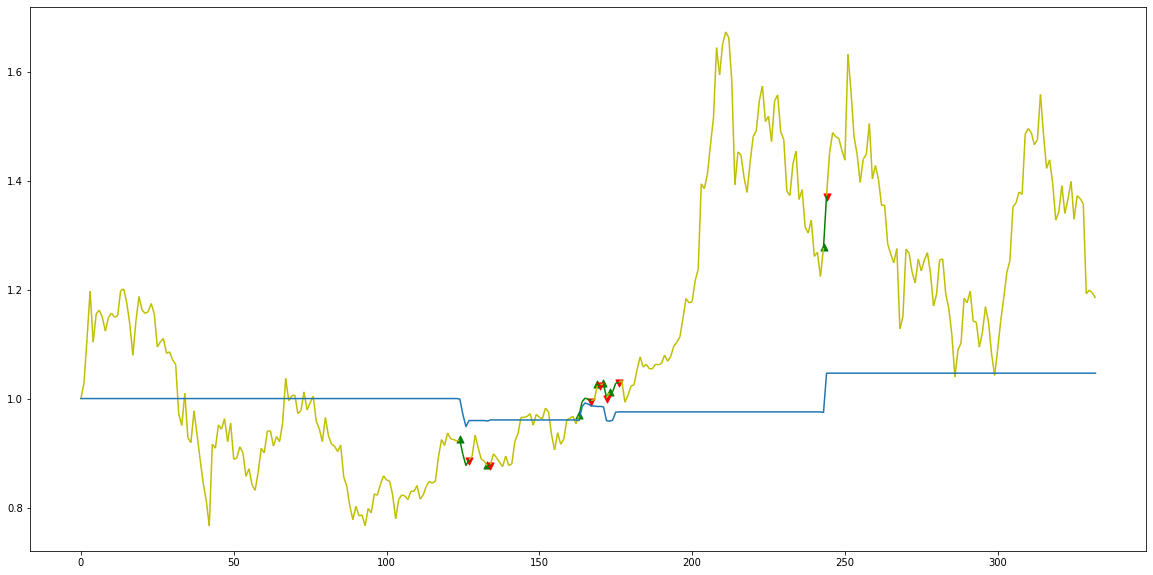

news-set-5 | 0:21:02  | Eval-dev | 100  | TSLA  | Agent:   42.7% | Market:  696.4% | Diff: -653.8% | epsilon:  0.550 | loss: 0.00018689630087465048 | iterations: 24701


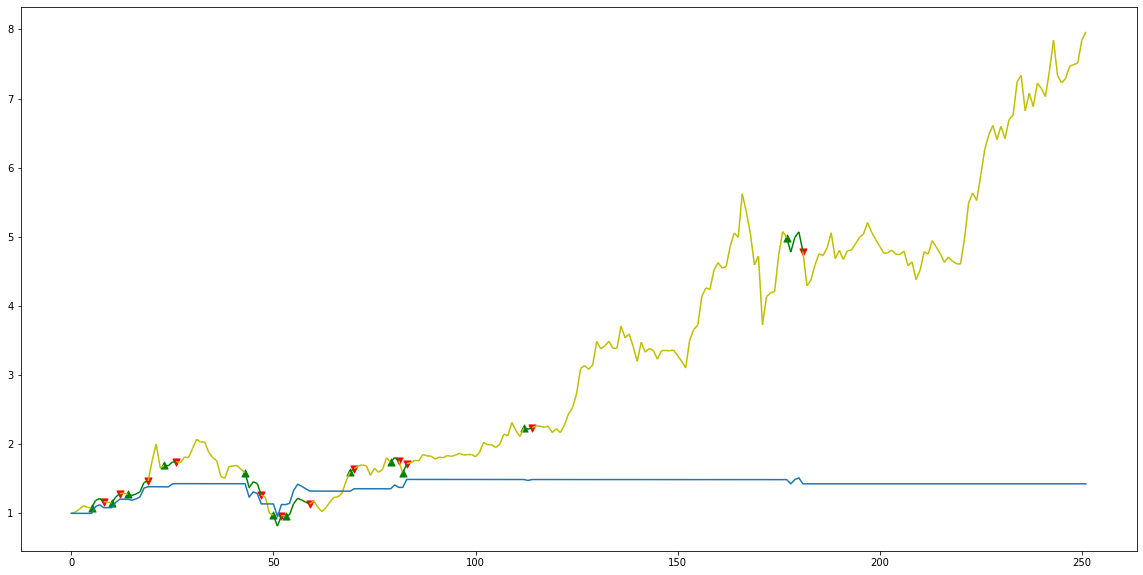

news-set-5 | 0:21:15  | Train | 101  | TSLA  | Agent:   61.0% | Market:  -13.6% | Diff:   74.6% | epsilon:  0.546 | loss: 0.00018398286192677915 | iterations: 24953
news-set-5 | 0:21:29  | Train | 102  | TSLA  | Agent:   22.1% | Market:   -1.5% | Diff:   23.6% | epsilon:  0.541 | loss: 0.0001810631074476987 | iterations: 25205
news-set-5 | 0:21:44  | Train | 103  | TSLA  | Agent:  -33.4% | Market:  -19.3% | Diff:  -14.2% | epsilon:  0.537 | loss: 0.00018061918672174215 | iterations: 25457
news-set-5 | 0:21:59  | Train | 104  | TSLA  | Agent:  -35.5% | Market:  -15.3% | Diff:  -20.2% | epsilon:  0.532 | loss: 0.00017890840535983443 | iterations: 25709
news-set-5 | 0:22:13  | Train | 105  | TSLA  | Agent:  -25.2% | Market:  -22.4% | Diff:   -2.8% | epsilon:  0.528 | loss: 0.00017628975911065936 | iterations: 25961
news-set-5 | 0:22:28  | Train | 106  | TSLA  | Agent:   -8.8% | Market:   -9.1% | Diff:    0.3% | epsilon:  0.523 | loss: 0.00017425006080884486 | iterations: 26213
news-set-5 

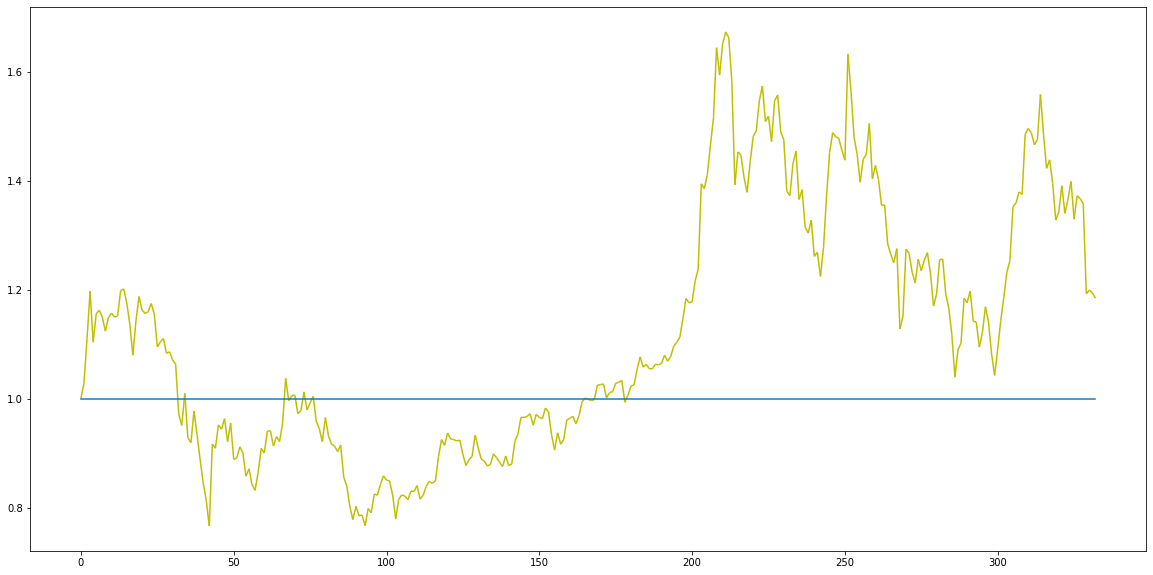

news-set-5 | 0:27:35  | Eval-dev | 125  | TSLA  | Agent:    0.0% | Market:  696.4% | Diff: -696.4% | epsilon:  0.438 | loss: 0.0001392025442328304 | iterations: 31001


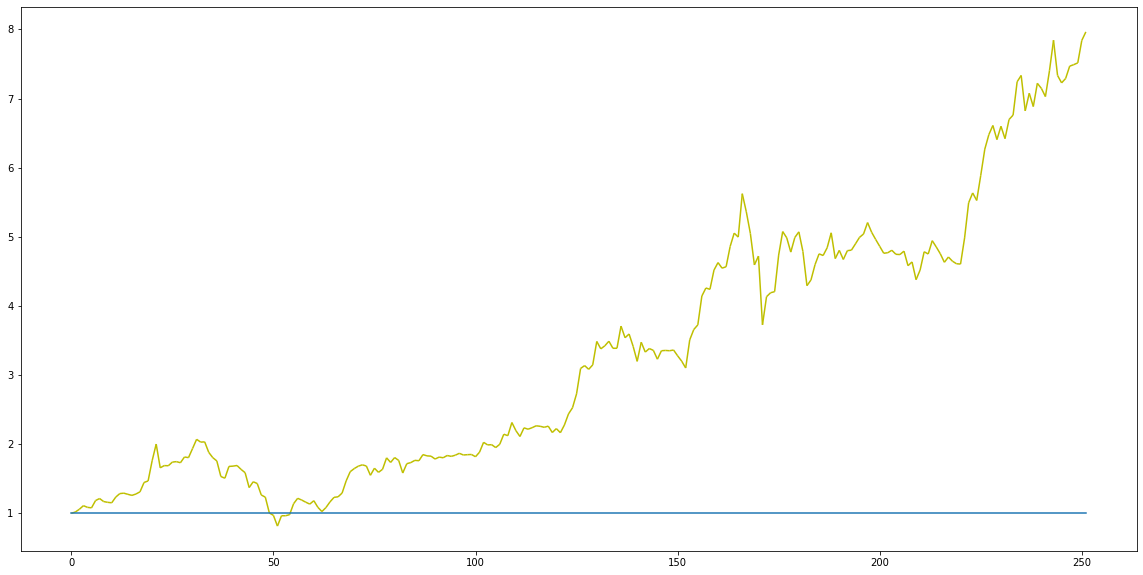

news-set-5 | 0:27:51  | Train | 126  | TSLA  | Agent:  -35.1% | Market:  -11.9% | Diff:  -23.1% | epsilon:  0.433 | loss: 0.00013640208635479212 | iterations: 31253
news-set-5 | 0:28:06  | Train | 127  | TSLA  | Agent:  -27.5% | Market:    4.9% | Diff:  -32.4% | epsilon:  0.429 | loss: 0.000133801469928585 | iterations: 31505
news-set-5 | 0:28:21  | Train | 128  | TSLA  | Agent:    2.6% | Market:   25.7% | Diff:  -23.1% | epsilon:  0.424 | loss: 0.00013277003017719835 | iterations: 31757
news-set-5 | 0:28:37  | Train | 129  | TSLA  | Agent:    2.2% | Market:  -10.6% | Diff:   12.8% | epsilon:  0.420 | loss: 0.00013124215183779597 | iterations: 32009
news-set-5 | 0:28:53  | Train | 130  | TSLA  | Agent:   22.5% | Market:   -4.3% | Diff:   26.8% | epsilon:  0.415 | loss: 0.00012954544217791408 | iterations: 32261
news-set-5 | 0:29:09  | Train | 131  | TSLA  | Agent:  -41.7% | Market:  -33.0% | Diff:   -8.7% | epsilon:  0.411 | loss: 0.00012746384891215712 | iterations: 32513
news-set-5 |

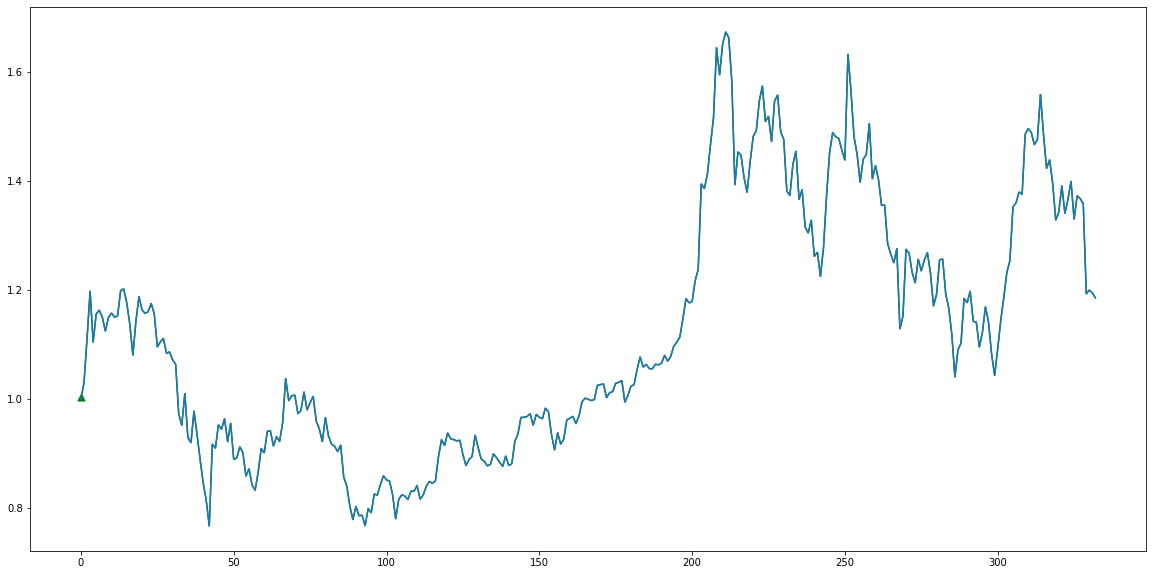

news-set-5 | 0:34:33  | Eval-dev | 150  | TSLA  | Agent:  708.9% | Market:  696.4% | Diff:   12.5% | epsilon:  0.325 | loss: 0.0001058925045072101 | iterations: 37301


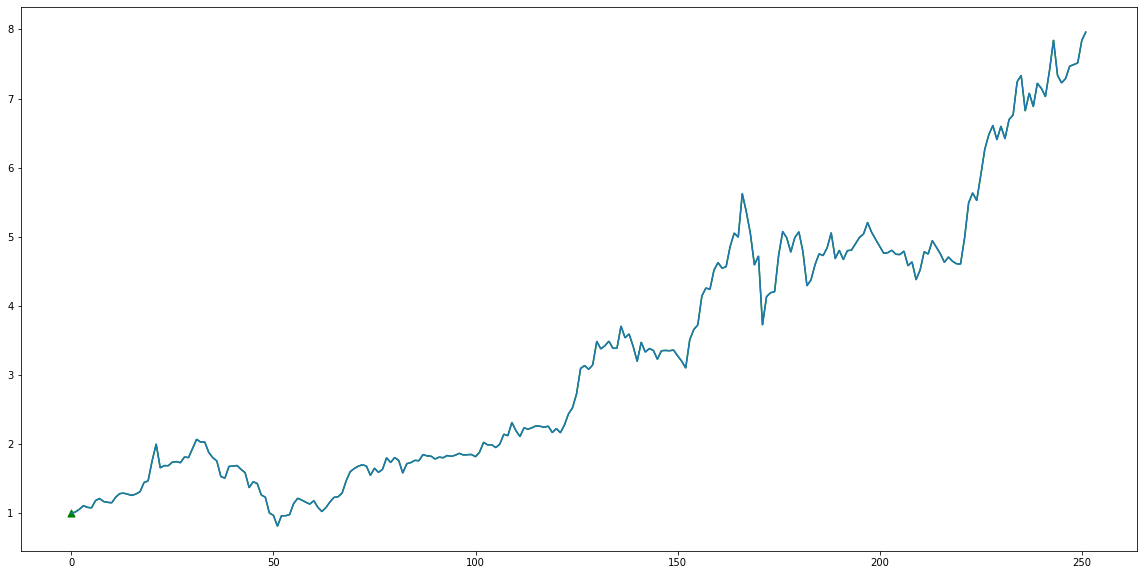

news-set-5 | 0:34:50  | Train | 151  | TSLA  | Agent:    5.9% | Market:   59.7% | Diff:  -53.7% | epsilon:  0.321 | loss: 0.00010399430175311863 | iterations: 37553
news-set-5 | 0:35:07  | Train | 152  | TSLA  | Agent:  -17.0% | Market:  -16.8% | Diff:   -0.2% | epsilon:  0.316 | loss: 0.00010178623051615432 | iterations: 37805
news-set-5 | 0:35:24  | Train | 153  | TSLA  | Agent:  -16.1% | Market:   59.9% | Diff:  -76.0% | epsilon:  0.312 | loss: 0.00010077296610688791 | iterations: 38057
news-set-5 | 0:35:40  | Train | 154  | TSLA  | Agent:  -84.6% | Market:  -12.6% | Diff:  -72.0% | epsilon:  0.307 | loss: 0.00010289361671311781 | iterations: 38309
news-set-5 | 0:35:57  | Train | 155  | TSLA  | Agent:  -22.4% | Market:   15.1% | Diff:  -37.5% | epsilon:  0.303 | loss: 0.00010199771350016817 | iterations: 38561
news-set-5 | 0:36:15  | Train | 156  | TSLA  | Agent:    3.6% | Market:   40.7% | Diff:  -37.1% | epsilon:  0.298 | loss: 0.00010050387209048495 | iterations: 38813
news-set-5

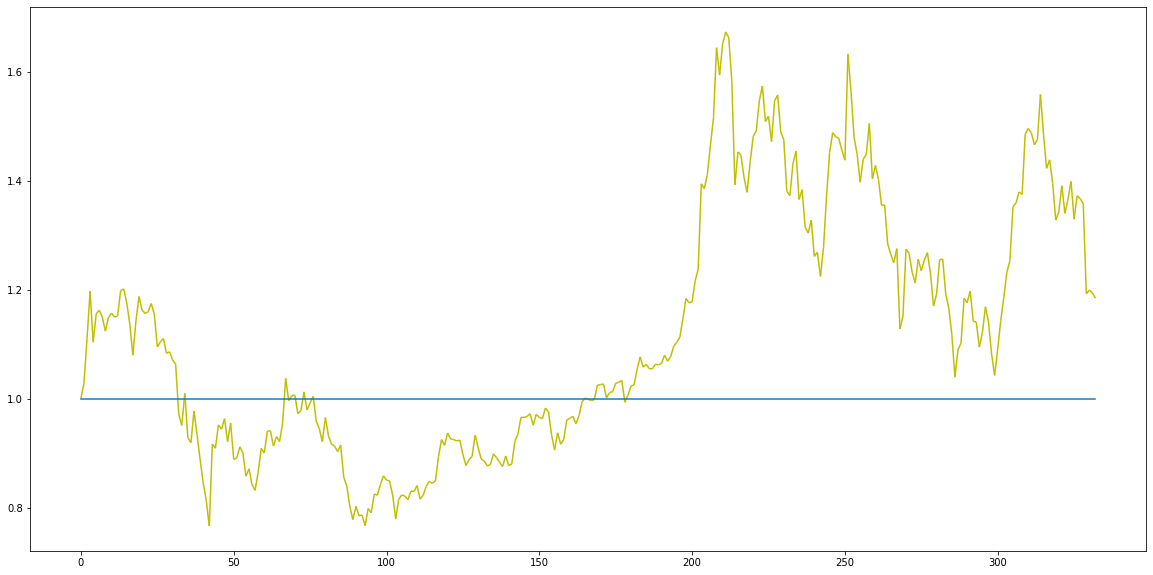

news-set-5 | 0:42:00  | Eval-dev | 175  | TSLA  | Agent:    0.0% | Market:  696.4% | Diff: -696.4% | epsilon:  0.213 | loss: 9.48802480706945e-05 | iterations: 43601


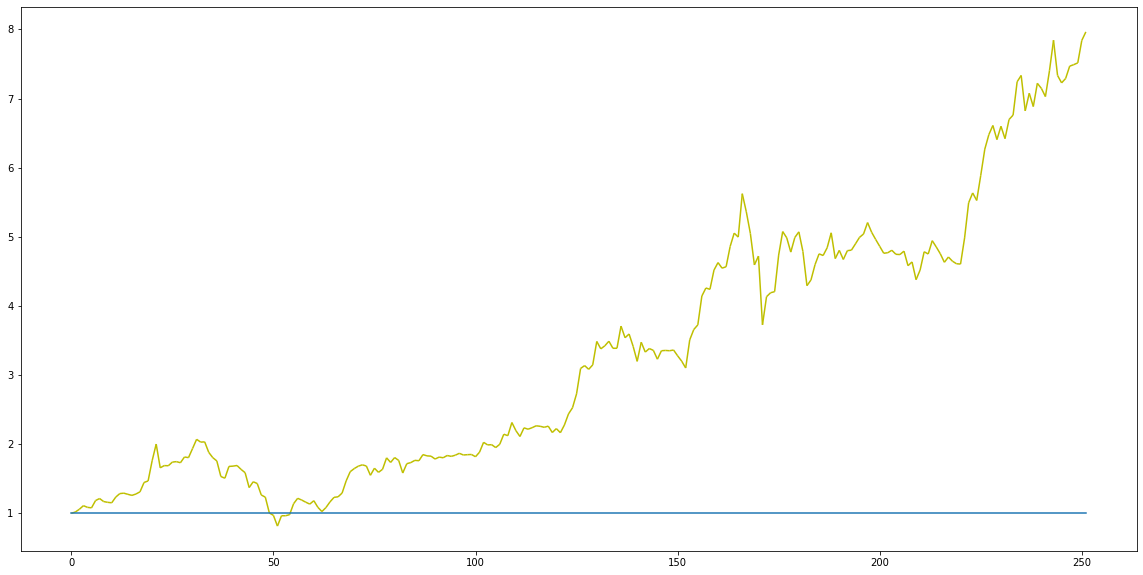

news-set-5 | 0:42:18  | Train | 176  | TSLA  | Agent:   12.5% | Market:  -11.8% | Diff:   24.3% | epsilon:  0.208 | loss: 9.404306183569133e-05 | iterations: 43853
news-set-5 | 0:42:36  | Train | 177  | TSLA  | Agent:   -7.7% | Market:  -25.4% | Diff:   17.7% | epsilon:  0.204 | loss: 9.233856690116227e-05 | iterations: 44105
news-set-5 | 0:42:54  | Train | 178  | TSLA  | Agent:   -9.2% | Market:  -13.2% | Diff:    4.0% | epsilon:  0.199 | loss: 9.091256652027369e-05 | iterations: 44357
news-set-5 | 0:43:10  | Train | 179  | TSLA  | Agent:  -13.1% | Market:  -16.9% | Diff:    3.8% | epsilon:  0.195 | loss: 9.201395732816309e-05 | iterations: 44609
news-set-5 | 0:43:28  | Train | 180  | TSLA  | Agent:  -35.4% | Market:   -3.7% | Diff:  -31.6% | epsilon:  0.190 | loss: 9.222744847647846e-05 | iterations: 44861
news-set-5 | 0:43:46  | Train | 181  | TSLA  | Agent:   25.9% | Market:   -8.8% | Diff:   34.6% | epsilon:  0.186 | loss: 9.136500739259645e-05 | iterations: 45113
news-set-5 | 0:4

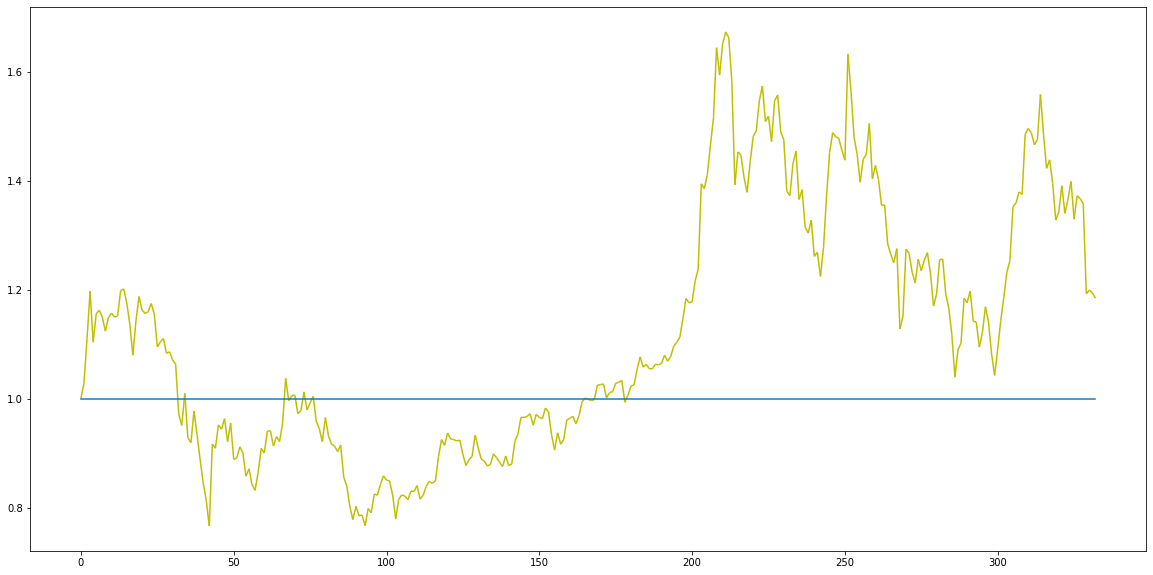

news-set-5 | 0:49:52  | Eval-dev | 200  | TSLA  | Agent:    0.0% | Market:  696.4% | Diff: -696.4% | epsilon:  0.100 | loss: 7.409926183754578e-05 | iterations: 49901


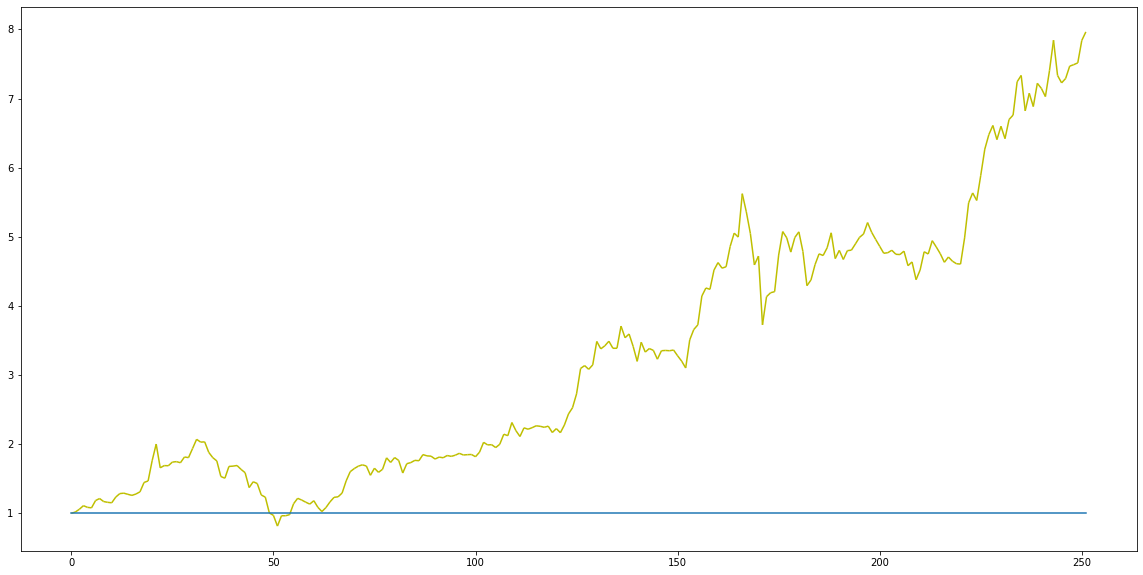

news-set-5 | 0:50:11  | Train | 201  | TSLA  | Agent:   24.5% | Market:   14.6% | Diff:    9.9% | epsilon:  0.100 | loss: 7.267514592967927e-05 | iterations: 50153
news-set-5 | 0:50:30  | Train | 202  | TSLA  | Agent:  -24.8% | Market:    0.6% | Diff:  -25.3% | epsilon:  0.100 | loss: 7.072895095916465e-05 | iterations: 50405
news-set-5 | 0:50:48  | Train | 203  | TSLA  | Agent:  -10.0% | Market:  -11.5% | Diff:    1.4% | epsilon:  0.100 | loss: 6.896333798067644e-05 | iterations: 50657
news-set-5 | 0:51:07  | Train | 204  | TSLA  | Agent:   57.0% | Market:   82.4% | Diff:  -25.4% | epsilon:  0.100 | loss: 6.823687726864591e-05 | iterations: 50909
news-set-5 | 0:51:25  | Train | 205  | TSLA  | Agent:   16.9% | Market:   -6.2% | Diff:   23.1% | epsilon:  0.100 | loss: 6.92471003276296e-05 | iterations: 51161
news-set-5 | 0:51:44  | Train | 206  | TSLA  | Agent:    2.3% | Market:  -18.3% | Diff:   20.5% | epsilon:  0.100 | loss: 6.830273196101189e-05 | iterations: 51413
news-set-5 | 0:52

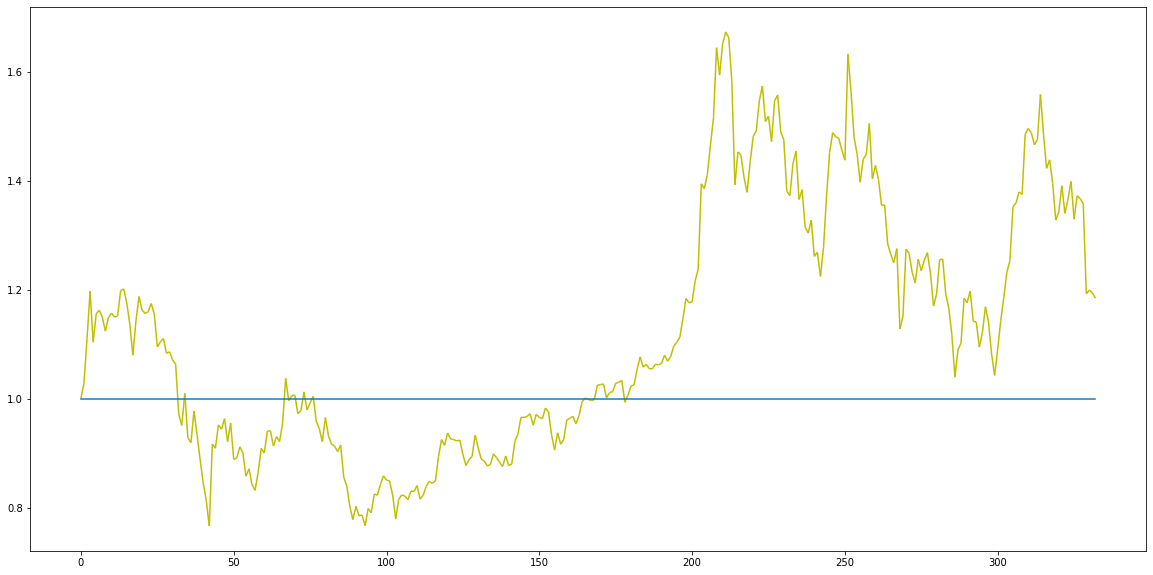

news-set-5 | 0:57:56  | Eval-dev | 225  | TSLA  | Agent:    0.0% | Market:  696.4% | Diff: -696.4% | epsilon:  0.100 | loss: 6.016878614900634e-05 | iterations: 56201


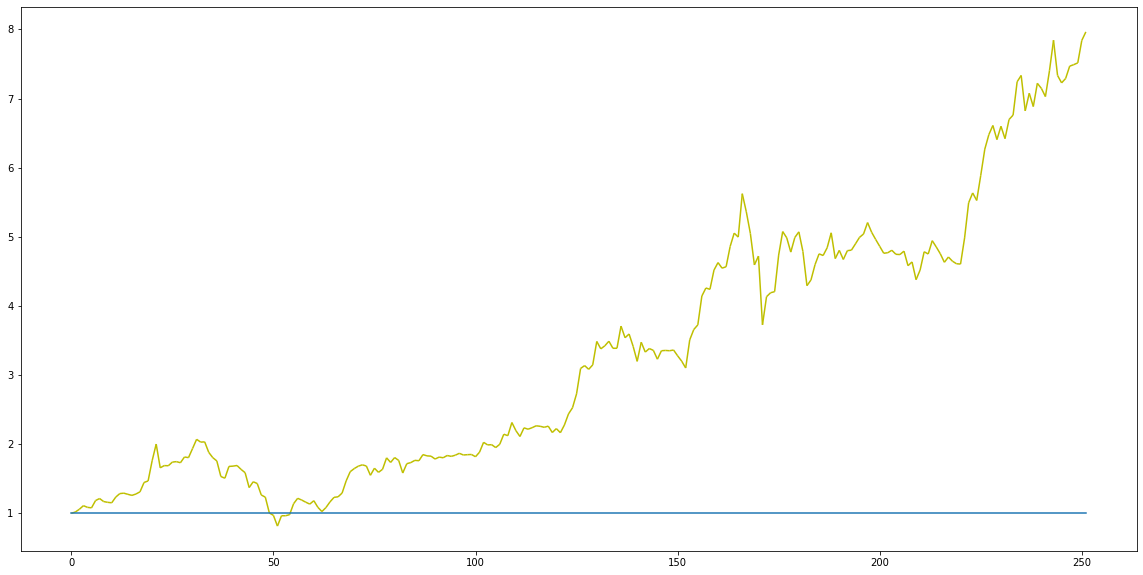

news-set-5 | 0:58:14  | Train | 226  | TSLA  | Agent:   65.0% | Market:   76.8% | Diff:  -11.8% | epsilon:  0.100 | loss: 6.347953603835776e-05 | iterations: 56453
news-set-5 | 0:58:33  | Train | 227  | TSLA  | Agent:   -0.1% | Market:  -27.8% | Diff:   27.7% | epsilon:  0.100 | loss: 6.304417183855549e-05 | iterations: 56705
news-set-5 | 0:58:51  | Train | 228  | TSLA  | Agent:   25.3% | Market:  -10.9% | Diff:   36.3% | epsilon:  0.100 | loss: 6.20563660049811e-05 | iterations: 56957
news-set-5 | 0:59:10  | Train | 229  | TSLA  | Agent:    0.6% | Market:   12.4% | Diff:  -11.9% | epsilon:  0.100 | loss: 6.0988615587120876e-05 | iterations: 57209
news-set-5 | 0:59:28  | Train | 230  | TSLA  | Agent:   35.5% | Market:   -2.7% | Diff:   38.2% | epsilon:  0.100 | loss: 6.283896800596267e-05 | iterations: 57461
news-set-5 | 0:59:47  | Train | 231  | TSLA  | Agent:  -16.3% | Market:  -15.0% | Diff:   -1.4% | epsilon:  0.100 | loss: 6.245539407245815e-05 | iterations: 57713
news-set-5 | 1:0

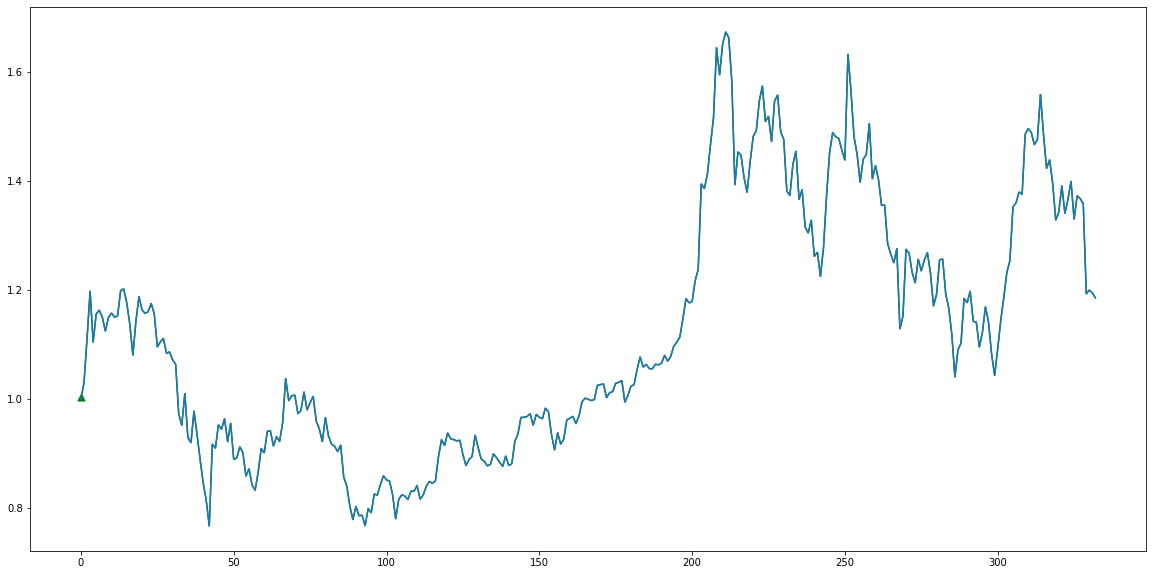

news-set-5 | 1:05:59  | Eval-dev | 250  | TSLA  | Agent:  708.9% | Market:  696.4% | Diff:   12.5% | epsilon:  0.100 | loss: 5.661808609147556e-05 | iterations: 62501


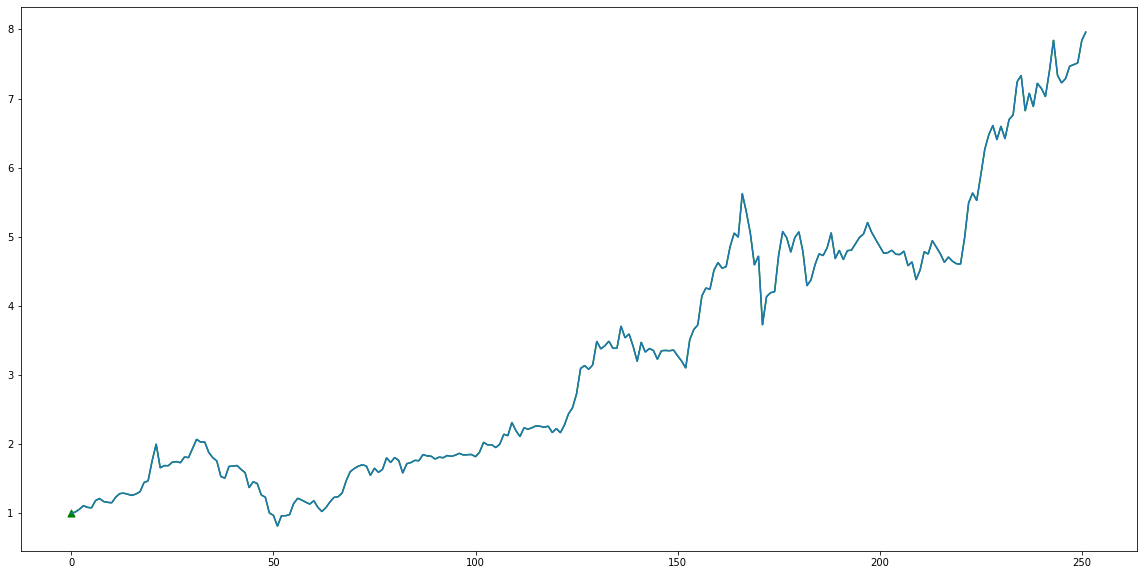

news-set-5 | 1:06:17  | Train | 251  | TSLA  | Agent:   36.4% | Market:   83.3% | Diff:  -46.9% | epsilon:  0.100 | loss: 5.757830513175577e-05 | iterations: 62753
news-set-5 | 1:06:34  | Train | 252  | TSLA  | Agent:   46.9% | Market:  -16.3% | Diff:   63.2% | epsilon:  0.100 | loss: 5.789982606074773e-05 | iterations: 63005
news-set-5 | 1:06:52  | Train | 253  | TSLA  | Agent:  182.2% | Market:   74.2% | Diff:  108.1% | epsilon:  0.100 | loss: 5.7167228078469634e-05 | iterations: 63257
news-set-5 | 1:07:08  | Train | 254  | TSLA  | Agent:   32.0% | Market:  -12.6% | Diff:   44.6% | epsilon:  0.100 | loss: 5.6046745157800615e-05 | iterations: 63509
news-set-5 | 1:07:26  | Train | 255  | TSLA  | Agent:   69.8% | Market:   -7.2% | Diff:   77.0% | epsilon:  0.100 | loss: 5.657962174154818e-05 | iterations: 63761
news-set-5 | 1:07:43  | Train | 256  | TSLA  | Agent:   39.1% | Market:  -23.6% | Diff:   62.7% | epsilon:  0.100 | loss: 5.7346969697391614e-05 | iterations: 64013
news-set-5 | 

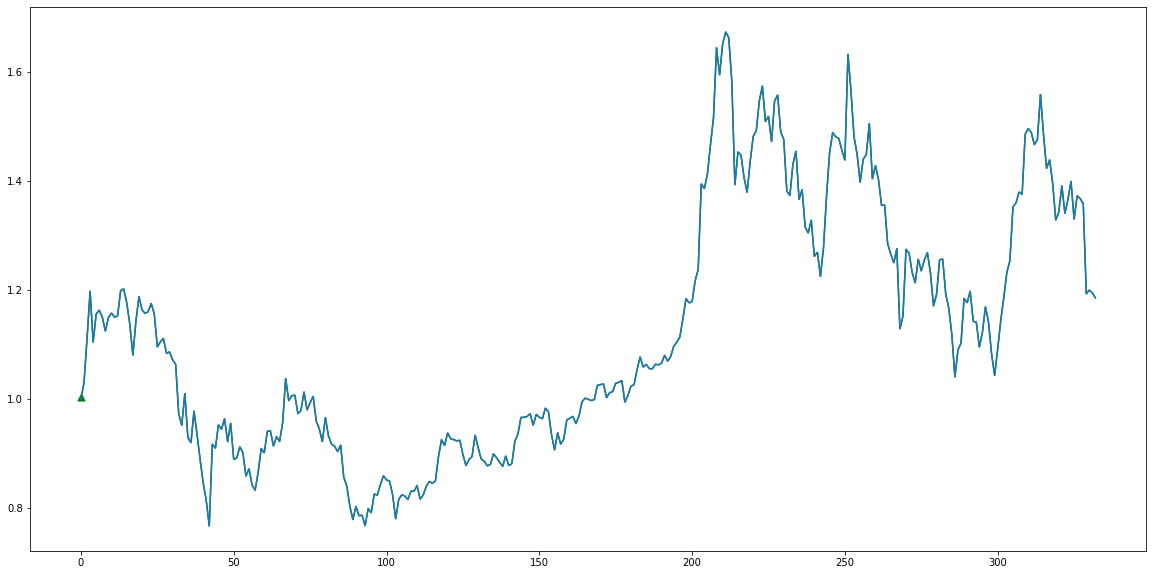

news-set-5 | 1:13:41  | Eval-dev | 275  | TSLA  | Agent:  508.2% | Market:  696.4% | Diff: -188.2% | epsilon:  0.100 | loss: 5.652950858348049e-05 | iterations: 68801


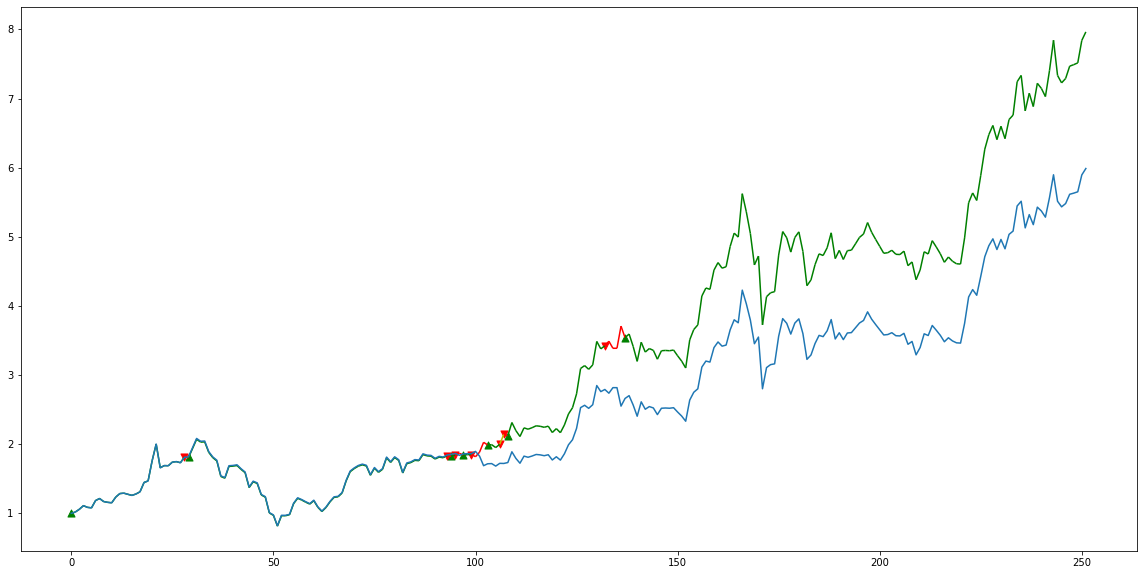

news-set-5 | 1:13:58  | Train | 276  | TSLA  | Agent:  345.4% | Market:  -11.1% | Diff:  356.5% | epsilon:  0.100 | loss: 5.711049016099423e-05 | iterations: 69053
news-set-5 | 1:14:15  | Train | 277  | TSLA  | Agent:   12.1% | Market:  -13.4% | Diff:   25.5% | epsilon:  0.100 | loss: 5.912374035688117e-05 | iterations: 69305
news-set-5 | 1:14:34  | Train | 278  | TSLA  | Agent:  198.3% | Market:   21.9% | Diff:  176.4% | epsilon:  0.100 | loss: 5.963652802165598e-05 | iterations: 69557
news-set-5 | 1:14:53  | Train | 279  | TSLA  | Agent:   49.1% | Market:    2.2% | Diff:   46.9% | epsilon:  0.100 | loss: 5.921641059103422e-05 | iterations: 69809
news-set-5 | 1:15:10  | Train | 280  | TSLA  | Agent:    5.2% | Market:  -10.1% | Diff:   15.3% | epsilon:  0.100 | loss: 5.8567984524415806e-05 | iterations: 70061
news-set-5 | 1:15:28  | Train | 281  | TSLA  | Agent:  104.0% | Market:  -12.7% | Diff:  116.7% | epsilon:  0.100 | loss: 6.090731039876118e-05 | iterations: 70313
news-set-5 | 1:

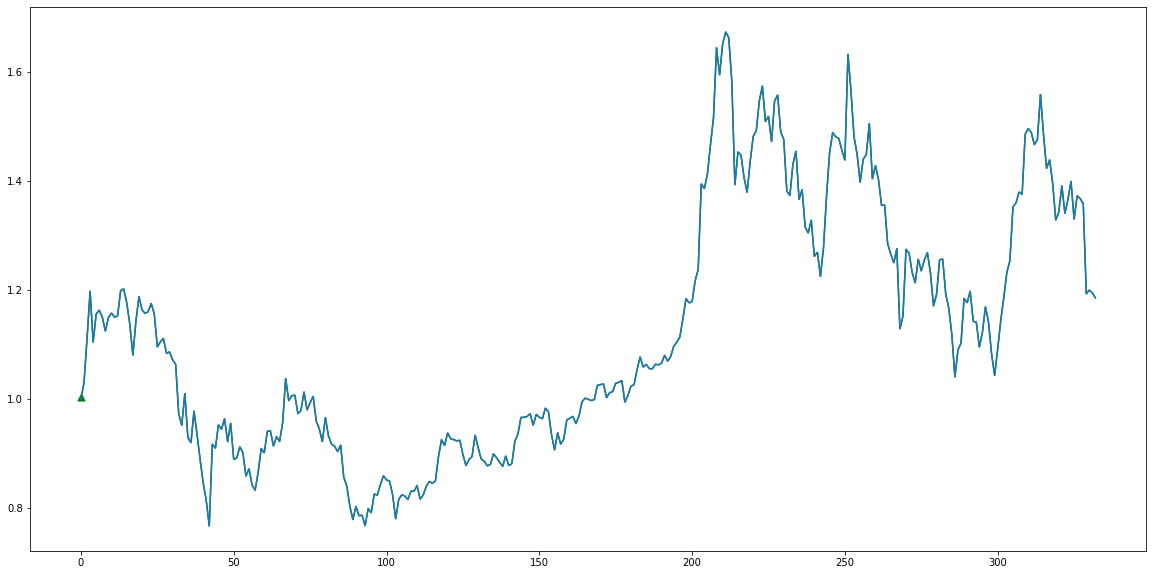

news-set-5 | 1:21:33  | Eval-dev | 300  | TSLA  | Agent:  537.9% | Market:  696.4% | Diff: -158.5% | epsilon:  0.100 | loss: 6.584231596207246e-05 | iterations: 75101


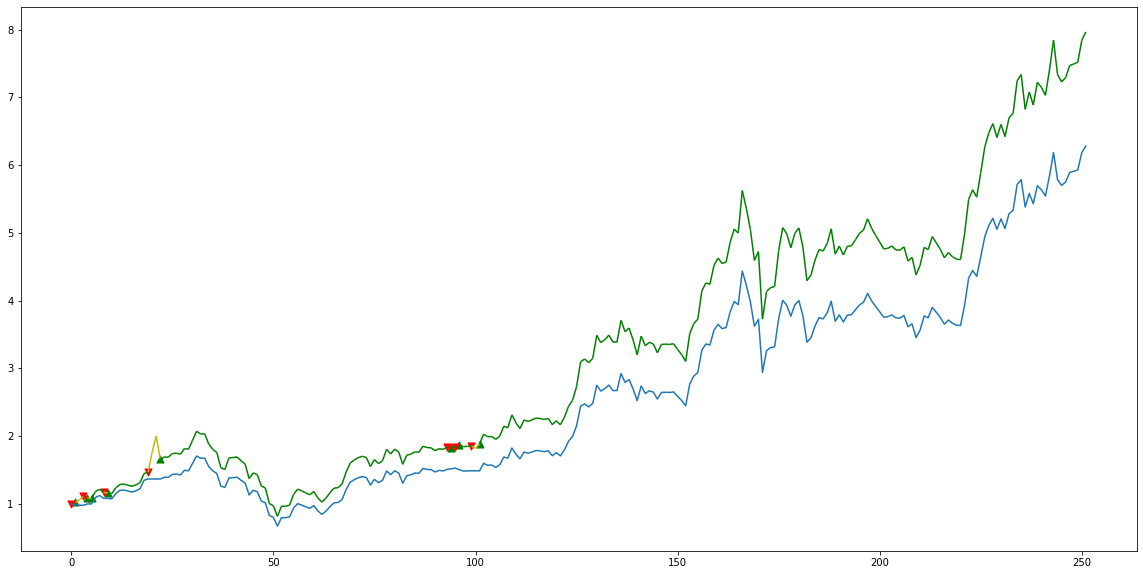

news-set-5 | 1:21:52  | Train | 301  | TSLA  | Agent:  129.9% | Market:   51.6% | Diff:   78.3% | epsilon:  0.100 | loss: 6.860692519694567e-05 | iterations: 75353
news-set-5 | 1:22:10  | Train | 302  | TSLA  | Agent:  115.7% | Market:   57.4% | Diff:   58.3% | epsilon:  0.100 | loss: 7.005787483649328e-05 | iterations: 75605
news-set-5 | 1:22:28  | Train | 303  | TSLA  | Agent:   -0.6% | Market:  -22.4% | Diff:   21.8% | epsilon:  0.100 | loss: 7.017150346655399e-05 | iterations: 75857
news-set-5 | 1:22:46  | Train | 304  | TSLA  | Agent:   82.2% | Market:   48.7% | Diff:   33.5% | epsilon:  0.100 | loss: 6.927407957846299e-05 | iterations: 76109
news-set-5 | 1:23:04  | Train | 305  | TSLA  | Agent:   51.9% | Market:   51.7% | Diff:    0.2% | epsilon:  0.100 | loss: 6.8173416366335e-05 | iterations: 76361
news-set-5 | 1:23:22  | Train | 306  | TSLA  | Agent:   37.5% | Market:   15.0% | Diff:   22.5% | epsilon:  0.100 | loss: 6.779143586754799e-05 | iterations: 76613
news-set-5 | 1:23:

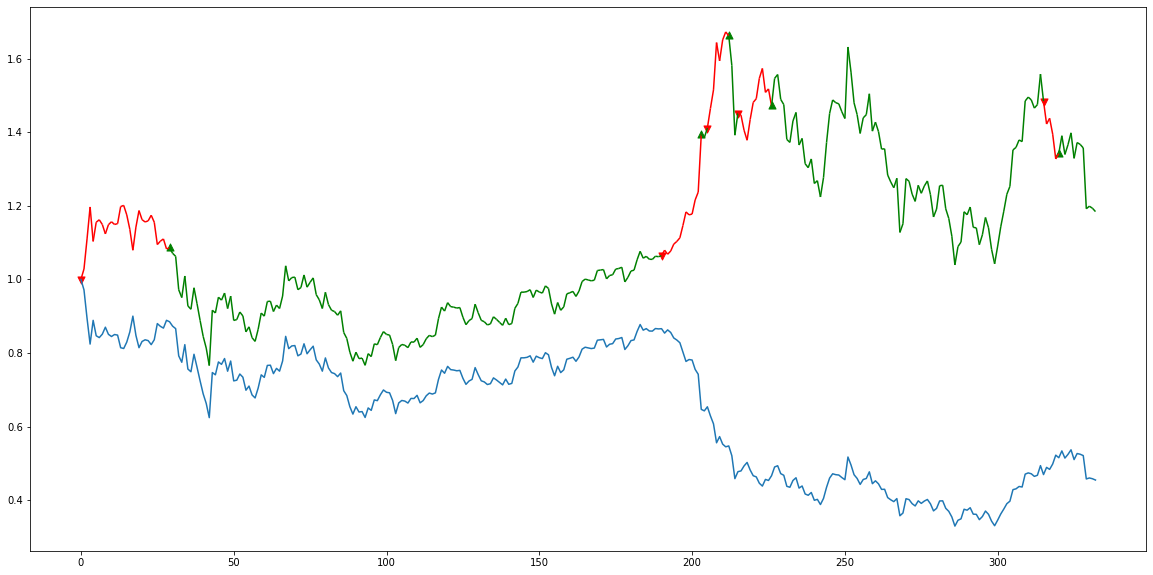

news-set-5 | 1:29:16  | Eval-dev | 325  | TSLA  | Agent:  201.4% | Market:  696.4% | Diff: -495.0% | epsilon:  0.100 | loss: 6.358147948049009e-05 | iterations: 81401


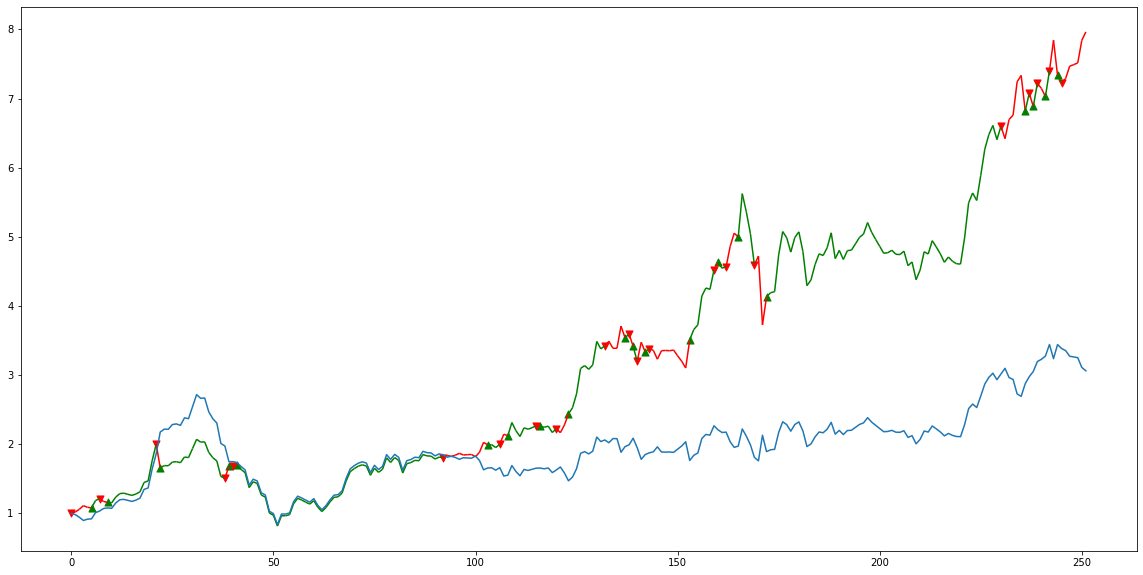

news-set-5 | 1:29:34  | Train | 326  | TSLA  | Agent:   62.3% | Market:  -17.7% | Diff:   80.1% | epsilon:  0.100 | loss: 6.241857045097277e-05 | iterations: 81653
news-set-5 | 1:29:52  | Train | 327  | TSLA  | Agent:  115.9% | Market:   50.1% | Diff:   65.8% | epsilon:  0.100 | loss: 6.101067629060708e-05 | iterations: 81905
news-set-5 | 1:30:10  | Train | 328  | TSLA  | Agent:  115.8% | Market:   56.5% | Diff:   59.2% | epsilon:  0.100 | loss: 6.311916513368487e-05 | iterations: 82157
news-set-5 | 1:30:29  | Train | 329  | TSLA  | Agent:   68.4% | Market:   -4.5% | Diff:   72.9% | epsilon:  0.100 | loss: 6.273051985772327e-05 | iterations: 82409
news-set-5 | 1:30:47  | Train | 330  | TSLA  | Agent:   24.0% | Market:   -3.0% | Diff:   27.0% | epsilon:  0.100 | loss: 6.156169547466561e-05 | iterations: 82661
news-set-5 | 1:31:07  | Train | 331  | TSLA  | Agent:  156.3% | Market:   83.3% | Diff:   73.1% | epsilon:  0.100 | loss: 6.0302023484837264e-05 | iterations: 82913
news-set-5 | 1:

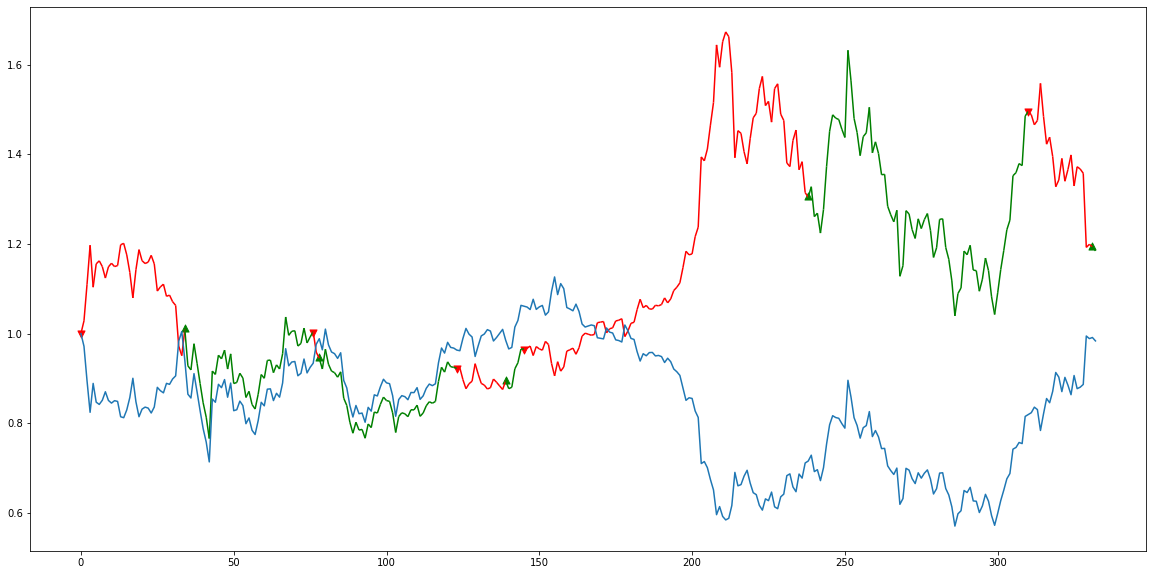

news-set-5 | 1:37:15  | Eval-dev | 350  | TSLA  | Agent:  -19.8% | Market:  696.4% | Diff: -716.3% | epsilon:  0.100 | loss: 5.703919305233285e-05 | iterations: 87701


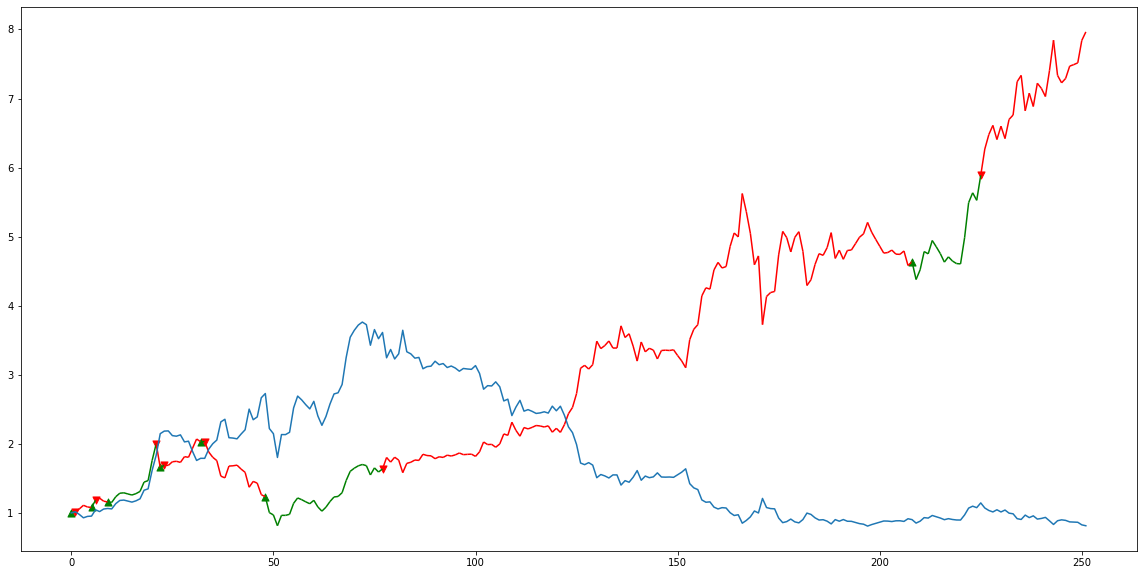

news-set-5 | 1:37:33  | Train | 351  | TSLA  | Agent:   50.8% | Market:   32.5% | Diff:   18.3% | epsilon:  0.100 | loss: 5.600411168416031e-05 | iterations: 87953
news-set-5 | 1:37:50  | Train | 352  | TSLA  | Agent:   51.3% | Market:   67.8% | Diff:  -16.5% | epsilon:  0.100 | loss: 5.4581538279308006e-05 | iterations: 88205
news-set-5 | 1:38:10  | Train | 353  | TSLA  | Agent:  116.2% | Market:   46.9% | Diff:   69.3% | epsilon:  0.100 | loss: 5.509863331099041e-05 | iterations: 88457
news-set-5 | 1:38:28  | Train | 354  | TSLA  | Agent:   28.1% | Market:  -33.0% | Diff:   61.1% | epsilon:  0.100 | loss: 5.662093099090271e-05 | iterations: 88709
news-set-5 | 1:38:46  | Train | 355  | TSLA  | Agent:   77.0% | Market:   69.2% | Diff:    7.7% | epsilon:  0.100 | loss: 5.6288132327608764e-05 | iterations: 88961
news-set-5 | 1:39:03  | Train | 356  | TSLA  | Agent:   91.1% | Market:   -4.5% | Diff:   95.7% | epsilon:  0.100 | loss: 5.555891402764246e-05 | iterations: 89213
news-set-5 | 1

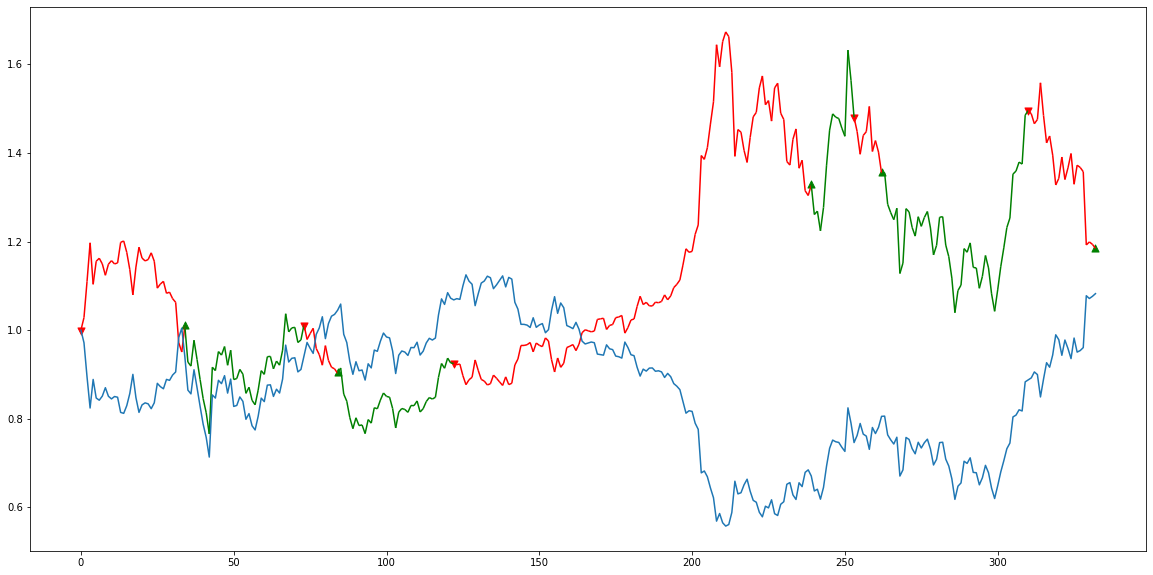

news-set-5 | 1:44:53  | Eval-dev | 375  | TSLA  | Agent:  -20.5% | Market:  696.4% | Diff: -716.9% | epsilon:  0.100 | loss: 6.172892608447e-05 | iterations: 94001


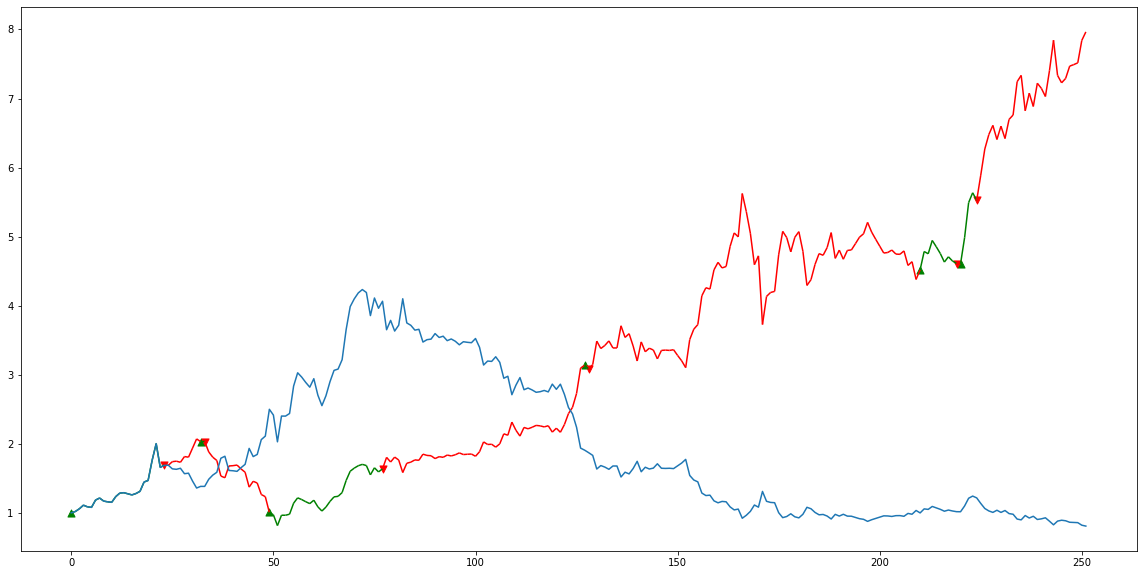

news-set-5 | 1:45:10  | Train | 376  | TSLA  | Agent:   74.3% | Market:    2.8% | Diff:   71.6% | epsilon:  0.100 | loss: 6.107927765697241e-05 | iterations: 94253
news-set-5 | 1:45:27  | Train | 377  | TSLA  | Agent:   31.2% | Market:   26.8% | Diff:    4.4% | epsilon:  0.100 | loss: 6.02569998591207e-05 | iterations: 94505
news-set-5 | 1:45:44  | Train | 378  | TSLA  | Agent:  -29.5% | Market:  -19.3% | Diff:  -10.2% | epsilon:  0.100 | loss: 5.913564746151678e-05 | iterations: 94757
news-set-5 | 1:46:01  | Train | 379  | TSLA  | Agent:  100.9% | Market:   74.9% | Diff:   26.1% | epsilon:  0.100 | loss: 6.224343087524176e-05 | iterations: 95009
news-set-5 | 1:46:20  | Train | 380  | TSLA  | Agent:  106.7% | Market:   77.3% | Diff:   29.5% | epsilon:  0.100 | loss: 6.19940910837613e-05 | iterations: 95261
news-set-5 | 1:46:37  | Train | 381  | TSLA  | Agent:   61.4% | Market:  -12.5% | Diff:   74.0% | epsilon:  0.100 | loss: 6.143737118691206e-05 | iterations: 95513
news-set-5 | 1:46:

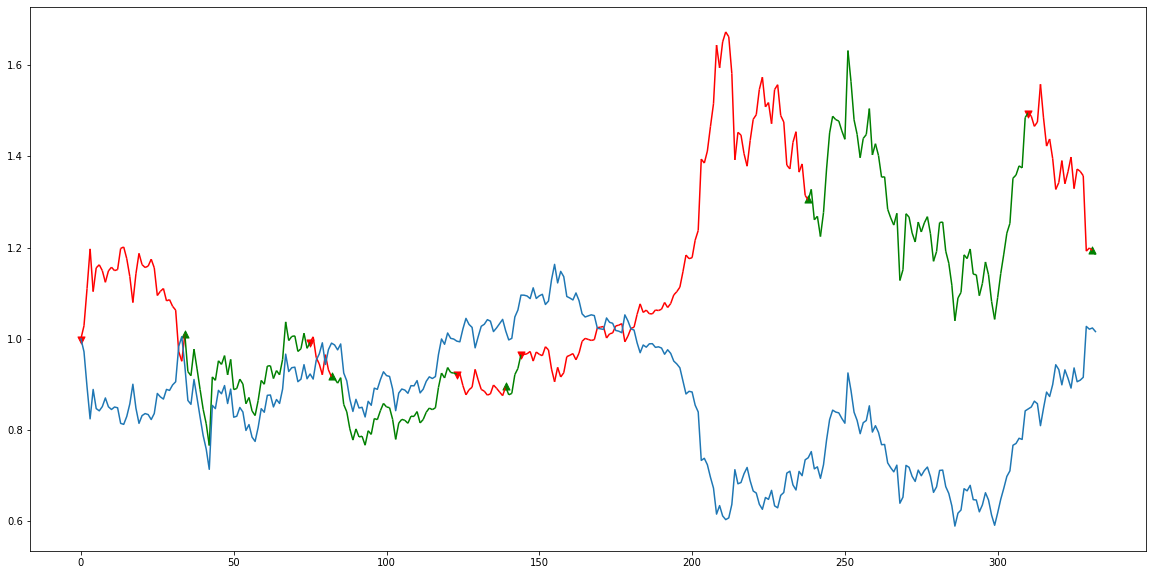

news-set-5 | 1:52:27  | Eval-dev | 400  | TSLA  | Agent:  -36.0% | Market:  696.4% | Diff: -732.4% | epsilon:  0.100 | loss: 5.8053075917996466e-05 | iterations: 100301


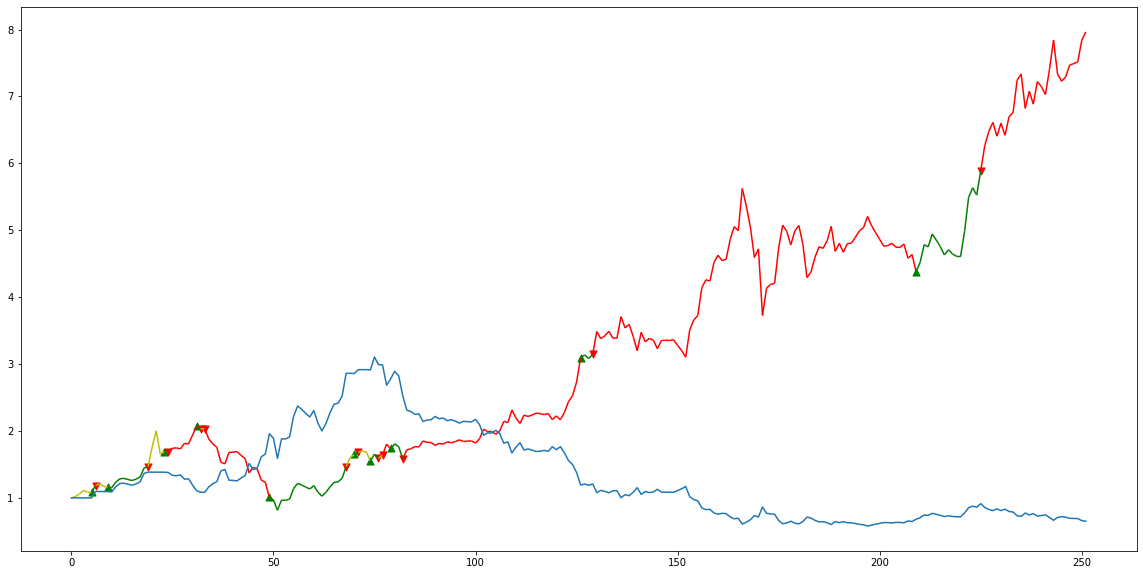

news-set-5 | 1:52:45  | Train | 401  | TSLA  | Agent:   57.3% | Market:  -13.3% | Diff:   70.6% | epsilon:  0.100 | loss: 5.7010049204109237e-05 | iterations: 100553
news-set-5 | 1:53:02  | Train | 402  | TSLA  | Agent:   62.5% | Market:  -18.5% | Diff:   80.9% | epsilon:  0.100 | loss: 5.587395571637899e-05 | iterations: 100805
news-set-5 | 1:53:19  | Train | 403  | TSLA  | Agent:   47.4% | Market:   59.7% | Diff:  -12.4% | epsilon:  0.100 | loss: 5.454024358186871e-05 | iterations: 101057
news-set-5 | 1:53:36  | Train | 404  | TSLA  | Agent:   68.6% | Market:   12.8% | Diff:   55.8% | epsilon:  0.100 | loss: 5.53151621716097e-05 | iterations: 101309
news-set-5 | 1:53:53  | Train | 405  | TSLA  | Agent:  219.6% | Market:  -10.6% | Diff:  230.2% | epsilon:  0.100 | loss: 5.5386633903253824e-05 | iterations: 101561
news-set-5 | 1:54:11  | Train | 406  | TSLA  | Agent:  191.2% | Market:   12.4% | Diff:  178.8% | epsilon:  0.100 | loss: 5.4321189963957295e-05 | iterations: 101813
news-set

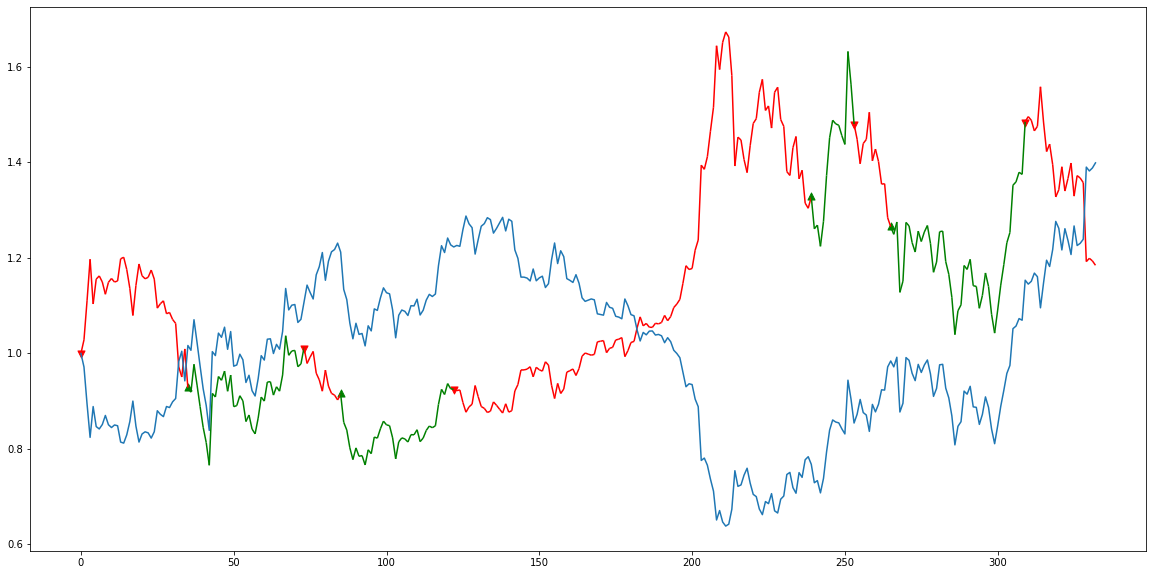

news-set-5 | 2:00:20  | Eval-dev | 425  | TSLA  | Agent:  -70.2% | Market:  696.4% | Diff: -766.7% | epsilon:  0.100 | loss: 4.902649379801005e-05 | iterations: 106601


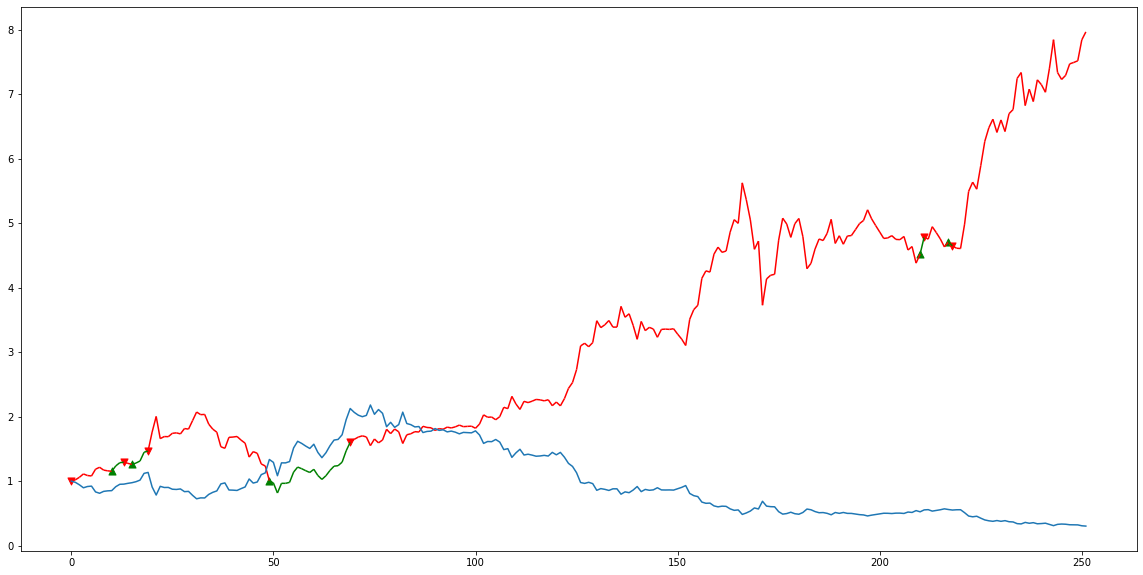

news-set-5 | 2:00:39  | Train | 426  | TSLA  | Agent:   95.8% | Market:   -3.5% | Diff:   99.4% | epsilon:  0.100 | loss: 4.894112498732284e-05 | iterations: 106853
news-set-5 | 2:00:57  | Train | 427  | TSLA  | Agent:   13.8% | Market:   37.0% | Diff:  -23.2% | epsilon:  0.100 | loss: 4.8537887778365985e-05 | iterations: 107105
news-set-5 | 2:01:14  | Train | 428  | TSLA  | Agent:   16.4% | Market:  -19.3% | Diff:   35.8% | epsilon:  0.100 | loss: 4.767487553181127e-05 | iterations: 107357
news-set-5 | 2:01:31  | Train | 429  | TSLA  | Agent:   98.5% | Market:   -6.4% | Diff:  104.9% | epsilon:  0.100 | loss: 4.698146949522197e-05 | iterations: 107609
news-set-5 | 2:01:48  | Train | 430  | TSLA  | Agent:   50.1% | Market:  -13.6% | Diff:   63.7% | epsilon:  0.100 | loss: 4.777700814884156e-05 | iterations: 107861
news-set-5 | 2:02:06  | Train | 431  | TSLA  | Agent:  174.2% | Market:   -6.2% | Diff:  180.4% | epsilon:  0.100 | loss: 4.765384437632747e-05 | iterations: 108113
news-set-

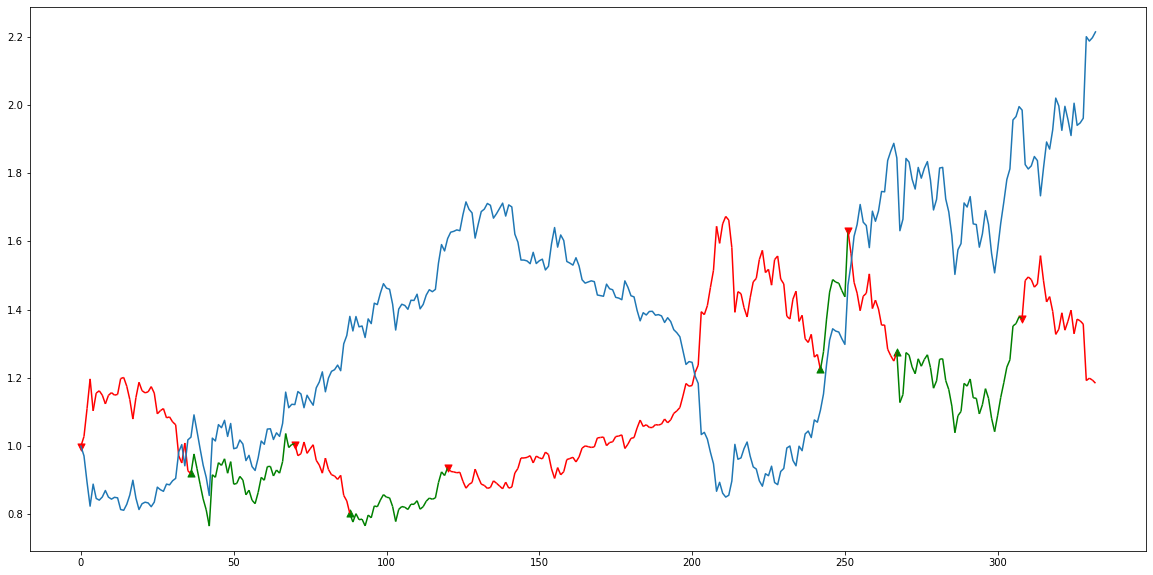

news-set-5 | 2:07:48  | Eval-dev | 450  | TSLA  | Agent:  -86.1% | Market:  696.4% | Diff: -782.5% | epsilon:  0.100 | loss: 4.697817348642275e-05 | iterations: 112901


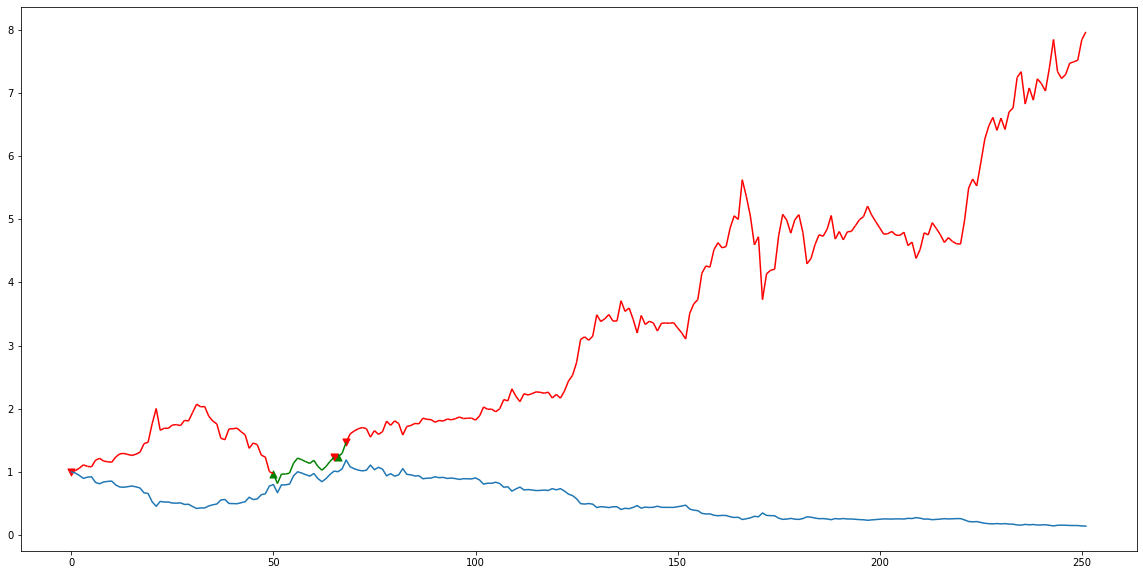

news-set-5 | 2:08:05  | Train | 451  | TSLA  | Agent:  -44.6% | Market:   39.4% | Diff:  -84.0% | epsilon:  0.100 | loss: 4.810130121768452e-05 | iterations: 113153
news-set-5 | 2:08:22  | Train | 452  | TSLA  | Agent:    0.1% | Market:   45.2% | Diff:  -45.0% | epsilon:  0.100 | loss: 4.8735066229710355e-05 | iterations: 113405
news-set-5 | 2:08:39  | Train | 453  | TSLA  | Agent:   20.4% | Market:    3.6% | Diff:   16.8% | epsilon:  0.100 | loss: 4.8670608521206304e-05 | iterations: 113657
news-set-5 | 2:08:57  | Train | 454  | TSLA  | Agent:  -41.5% | Market:   61.3% | Diff: -102.8% | epsilon:  0.100 | loss: 4.8634745326125994e-05 | iterations: 113909
news-set-5 | 2:09:14  | Train | 455  | TSLA  | Agent:  377.4% | Market:    0.8% | Diff:  376.7% | epsilon:  0.100 | loss: 4.9072208639699966e-05 | iterations: 114161
news-set-5 | 2:09:31  | Train | 456  | TSLA  | Agent:  -22.3% | Market:   61.5% | Diff:  -83.8% | epsilon:  0.100 | loss: 4.935631659463979e-05 | iterations: 114413
news-s

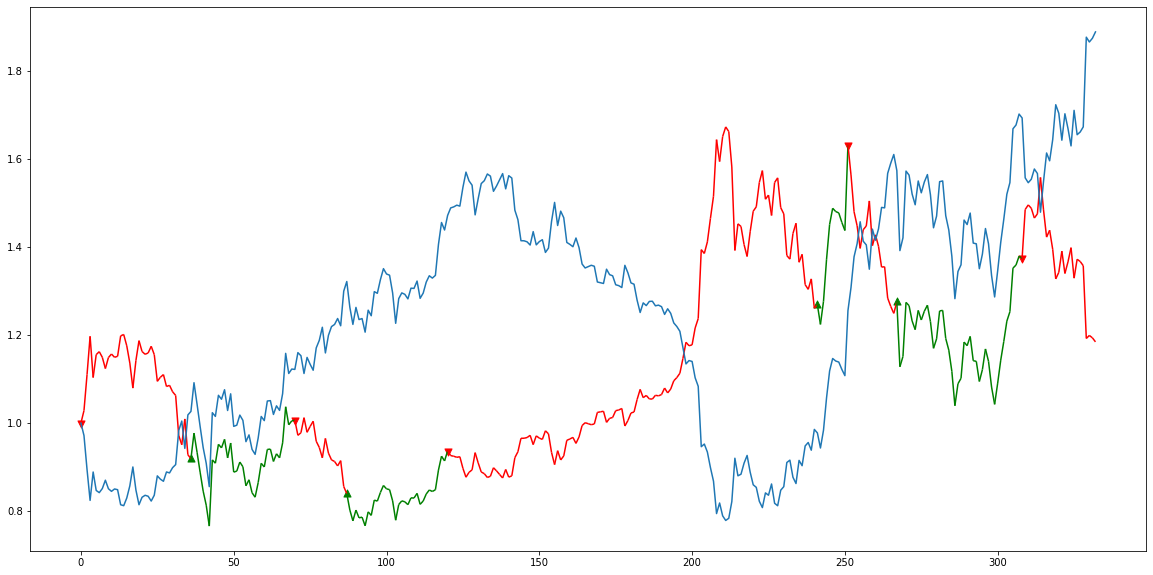

news-set-5 | 2:15:20  | Eval-dev | 475  | TSLA  | Agent:  -81.3% | Market:  696.4% | Diff: -777.7% | epsilon:  0.100 | loss: 4.8834586777957156e-05 | iterations: 119201


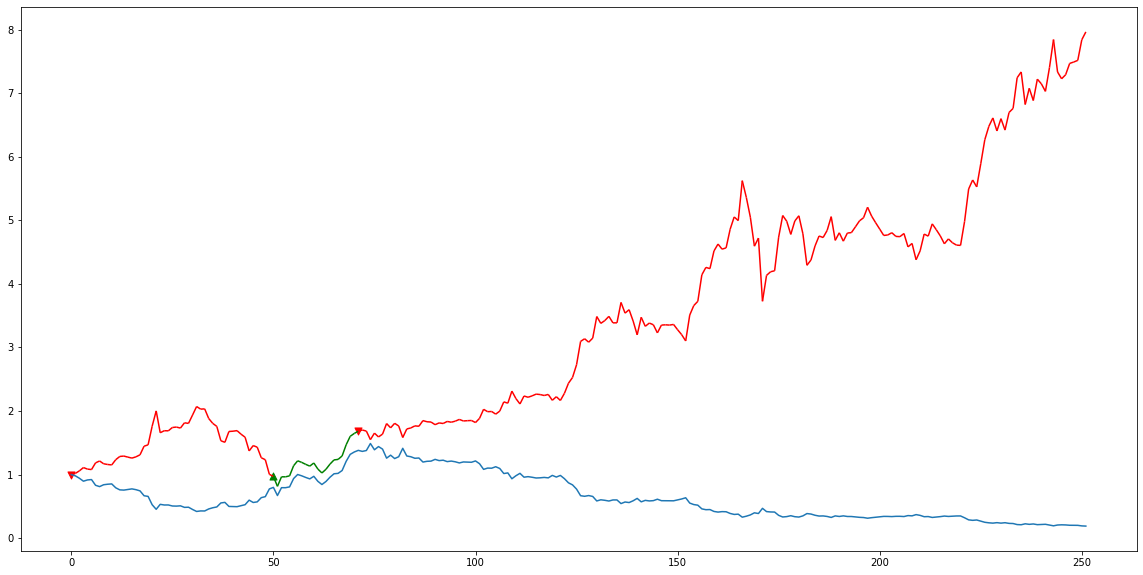

news-set-5 | 2:15:38  | Train | 476  | TSLA  | Agent:  -47.7% | Market:   55.3% | Diff: -103.0% | epsilon:  0.100 | loss: 4.941713996231556e-05 | iterations: 119453
news-set-5 | 2:15:56  | Train | 477  | TSLA  | Agent:   62.8% | Market:  -19.2% | Diff:   82.0% | epsilon:  0.100 | loss: 5.007863001083024e-05 | iterations: 119705
news-set-5 | 2:16:15  | Train | 478  | TSLA  | Agent:  -17.7% | Market:   61.9% | Diff:  -79.6% | epsilon:  0.100 | loss: 4.999465090804733e-05 | iterations: 119957
news-set-5 | 2:16:35  | Train | 479  | TSLA  | Agent:   77.1% | Market:   -6.4% | Diff:   83.5% | epsilon:  0.100 | loss: 4.981512392987497e-05 | iterations: 120209
news-set-5 | 2:16:52  | Train | 480  | TSLA  | Agent:  129.1% | Market:  -25.0% | Diff:  154.1% | epsilon:  0.100 | loss: 4.9677069910103455e-05 | iterations: 120461
news-set-5 | 2:17:11  | Train | 481  | TSLA  | Agent:   95.0% | Market:   -0.3% | Diff:   95.3% | epsilon:  0.100 | loss: 5.0253584049642086e-05 | iterations: 120713
news-set

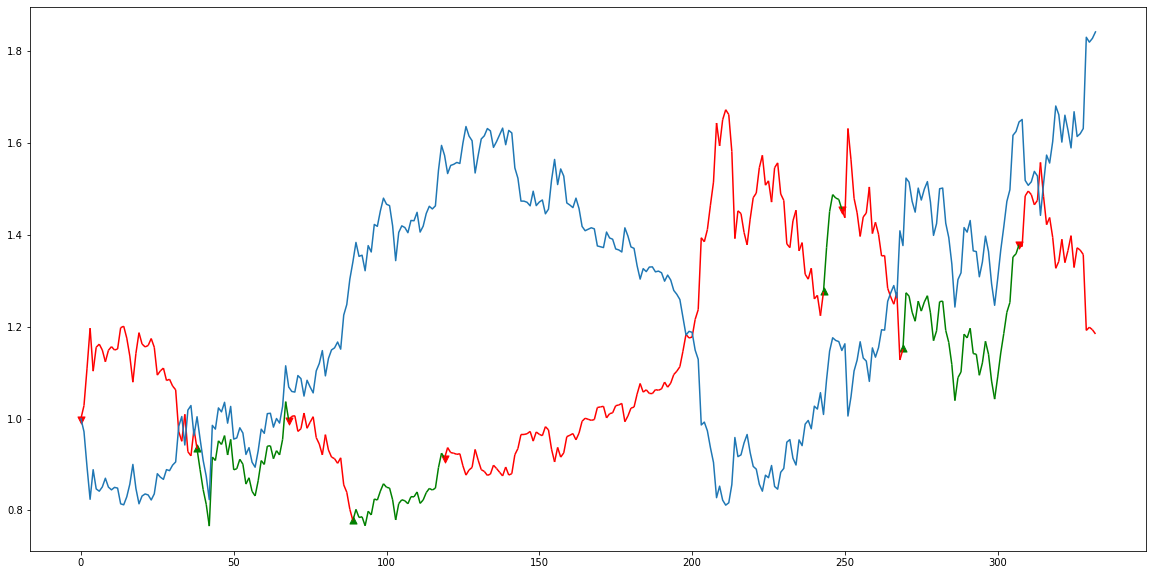

news-set-5 | 2:23:09  | Eval-dev | 500  | TSLA  | Agent:  -77.8% | Market:  696.4% | Diff: -774.2% | epsilon:  0.100 | loss: 4.8356094339396805e-05 | iterations: 125501


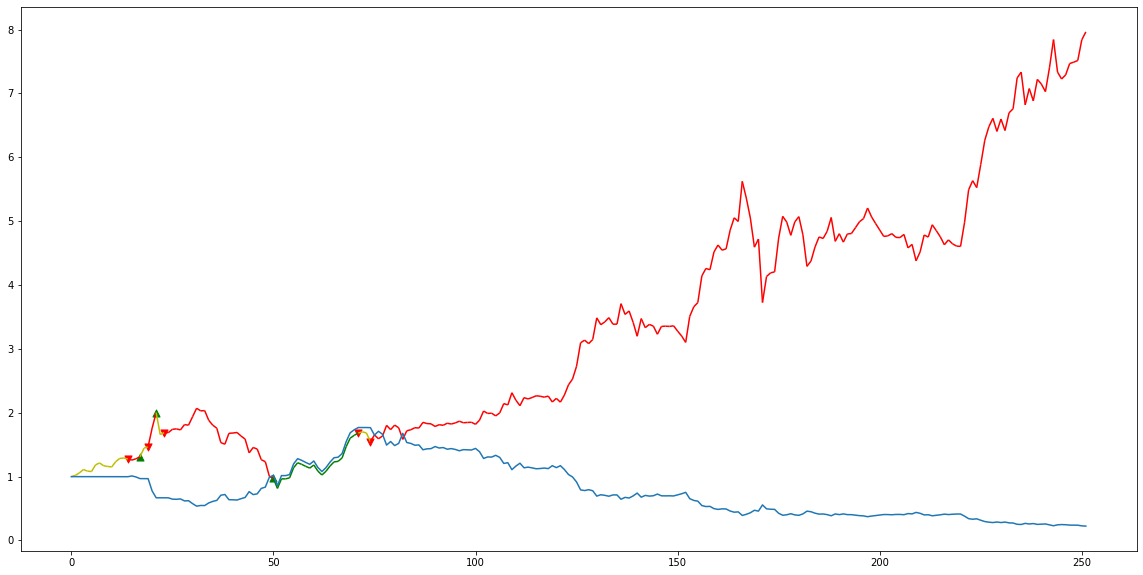

news-set-5 | 2:23:27  | Train | 501  | TSLA  | Agent:   19.8% | Market:   15.2% | Diff:    4.6% | epsilon:  0.100 | loss: 4.891013304586522e-05 | iterations: 125753
news-set-5 | 2:23:44  | Train | 502  | TSLA  | Agent:   59.3% | Market:   -6.5% | Diff:   65.8% | epsilon:  0.100 | loss: 4.980066296411678e-05 | iterations: 126005
news-set-5 | 2:24:02  | Train | 503  | TSLA  | Agent:  139.2% | Market:  -21.7% | Diff:  160.9% | epsilon:  0.100 | loss: 5.0076258048648015e-05 | iterations: 126257
news-set-5 | 2:24:18  | Train | 504  | TSLA  | Agent:  -44.8% | Market:   94.8% | Diff: -139.6% | epsilon:  0.100 | loss: 5.0126269343309104e-05 | iterations: 126509
news-set-5 | 2:24:35  | Train | 505  | TSLA  | Agent:  145.0% | Market:    0.7% | Diff:  144.3% | epsilon:  0.100 | loss: 4.97912333230488e-05 | iterations: 126761
news-set-5 | 2:24:52  | Train | 506  | TSLA  | Agent:   25.8% | Market:   66.2% | Diff:  -40.4% | epsilon:  0.100 | loss: 5.027576116845012e-05 | iterations: 127013
news-set-

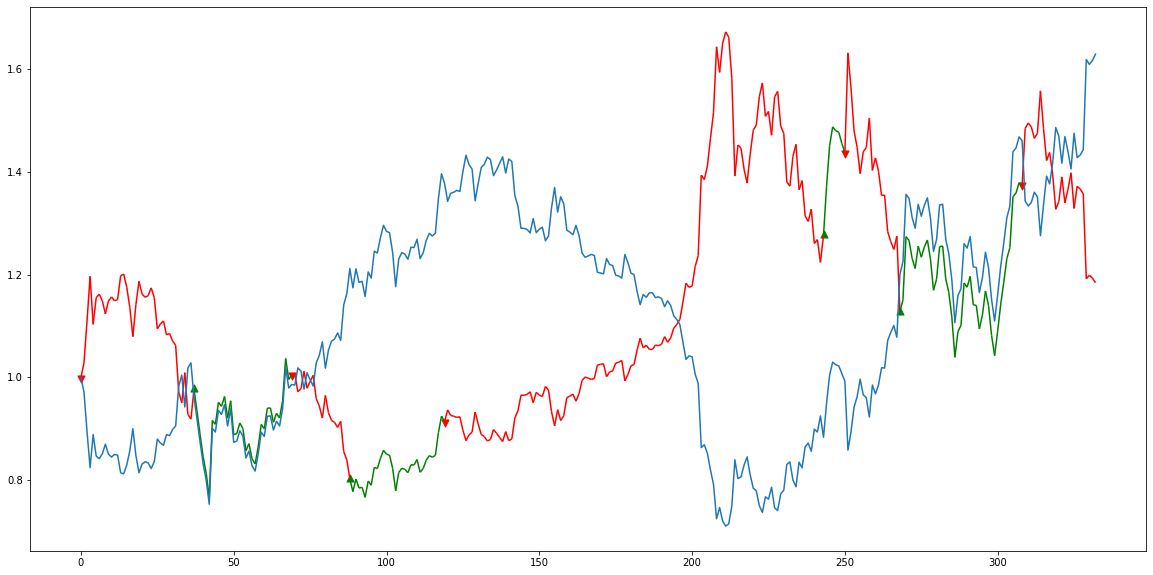

news-set-5 | 2:30:34  | Eval-dev | 525  | TSLA  | Agent:  -75.1% | Market:  696.4% | Diff: -771.6% | epsilon:  0.100 | loss: 4.13109410146717e-05 | iterations: 131801


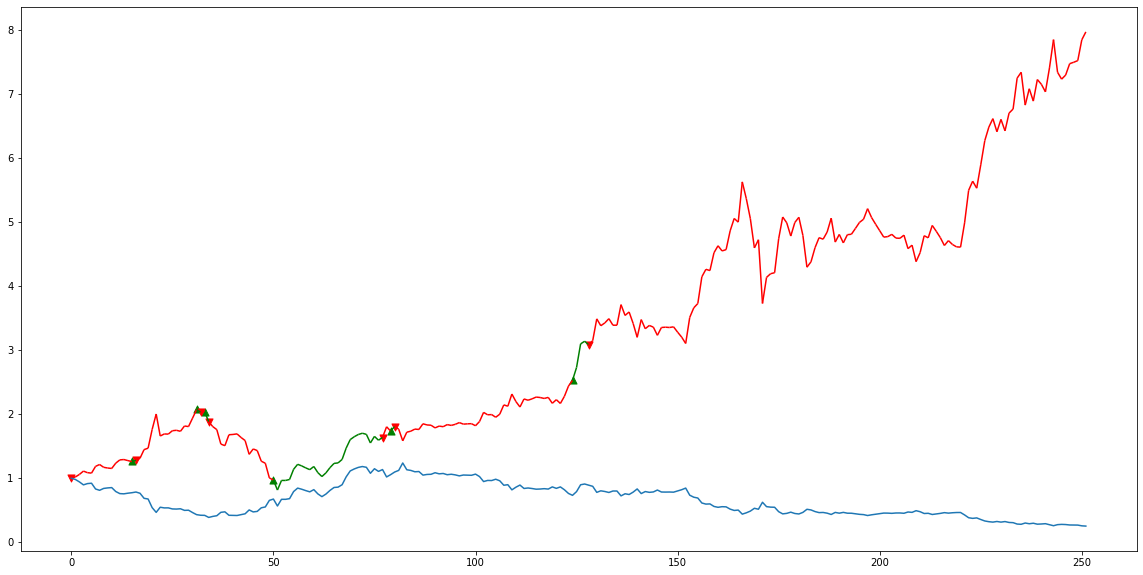

news-set-5 | 2:30:51  | Train | 526  | TSLA  | Agent:  -23.4% | Market:   35.0% | Diff:  -58.4% | epsilon:  0.100 | loss: 4.144044214626774e-05 | iterations: 132053
news-set-5 | 2:31:08  | Train | 527  | TSLA  | Agent:  201.8% | Market:  -15.9% | Diff:  217.7% | epsilon:  0.100 | loss: 4.1400508052902296e-05 | iterations: 132305
news-set-5 | 2:31:26  | Train | 528  | TSLA  | Agent:  392.8% | Market:  -24.2% | Diff:  417.0% | epsilon:  0.100 | loss: 4.1553157643647864e-05 | iterations: 132557
news-set-5 | 2:31:43  | Train | 529  | TSLA  | Agent:   -4.0% | Market:   43.0% | Diff:  -47.0% | epsilon:  0.100 | loss: 4.136251664021984e-05 | iterations: 132809
news-set-5 | 2:32:00  | Train | 530  | TSLA  | Agent:   41.2% | Market:   -4.2% | Diff:   45.5% | epsilon:  0.100 | loss: 4.073791205883026e-05 | iterations: 133061
news-set-5 | 2:32:18  | Train | 531  | TSLA  | Agent:  173.4% | Market:   15.9% | Diff:  157.5% | epsilon:  0.100 | loss: 4.024880036013201e-05 | iterations: 133313
news-set

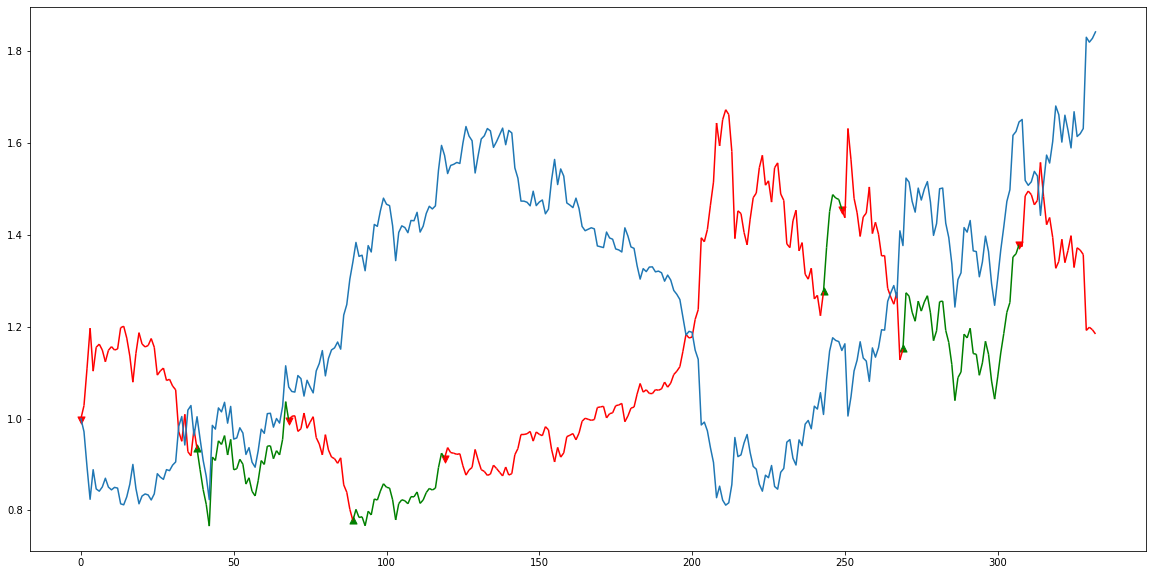

news-set-5 | 2:38:02  | Eval-dev | 550  | TSLA  | Agent:  -43.2% | Market:  696.4% | Diff: -739.6% | epsilon:  0.100 | loss: 4.113521572435275e-05 | iterations: 138101


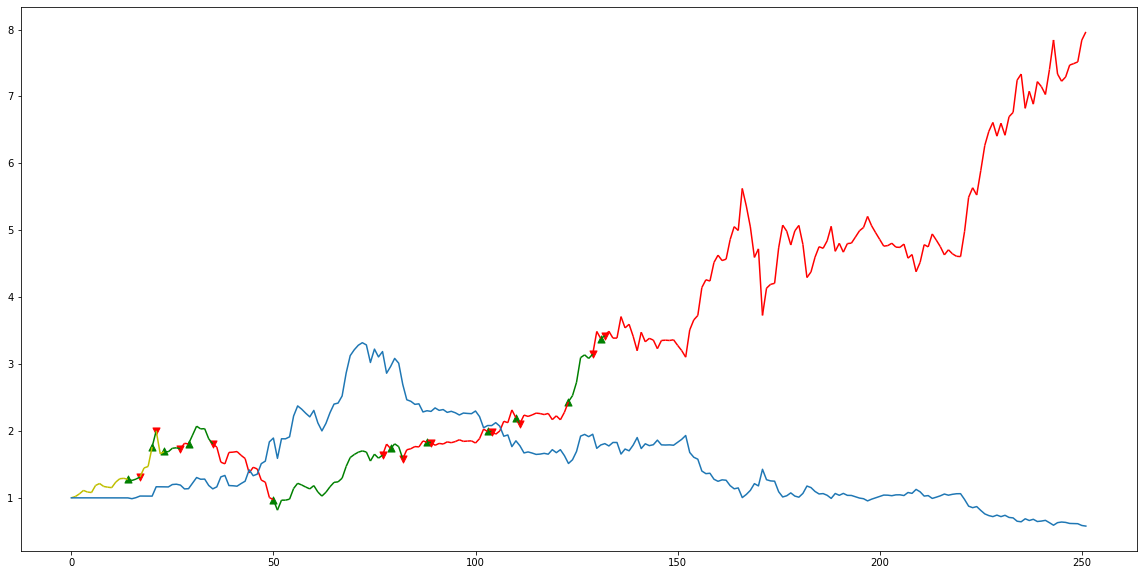

news-set-5 | 2:38:19  | Train | 551  | TSLA  | Agent:  121.8% | Market:  -15.4% | Diff:  137.3% | epsilon:  0.100 | loss: 4.078749043401331e-05 | iterations: 138353
news-set-5 | 2:38:37  | Train | 552  | TSLA  | Agent:   64.2% | Market:   -4.2% | Diff:   68.5% | epsilon:  0.100 | loss: 4.033103687106632e-05 | iterations: 138605
news-set-5 | 2:38:54  | Train | 553  | TSLA  | Agent:   52.1% | Market:    1.4% | Diff:   50.8% | epsilon:  0.100 | loss: 4.082123632542789e-05 | iterations: 138857
news-set-5 | 2:39:11  | Train | 554  | TSLA  | Agent:   23.4% | Market:   15.9% | Diff:    7.5% | epsilon:  0.100 | loss: 4.106949199922383e-05 | iterations: 139109
news-set-5 | 2:39:28  | Train | 555  | TSLA  | Agent:   40.8% | Market:   10.0% | Diff:   30.8% | epsilon:  0.100 | loss: 4.122377504245378e-05 | iterations: 139361
news-set-5 | 2:39:45  | Train | 556  | TSLA  | Agent:   67.5% | Market:  -17.2% | Diff:   84.7% | epsilon:  0.100 | loss: 4.10284883400891e-05 | iterations: 139613
news-set-5 

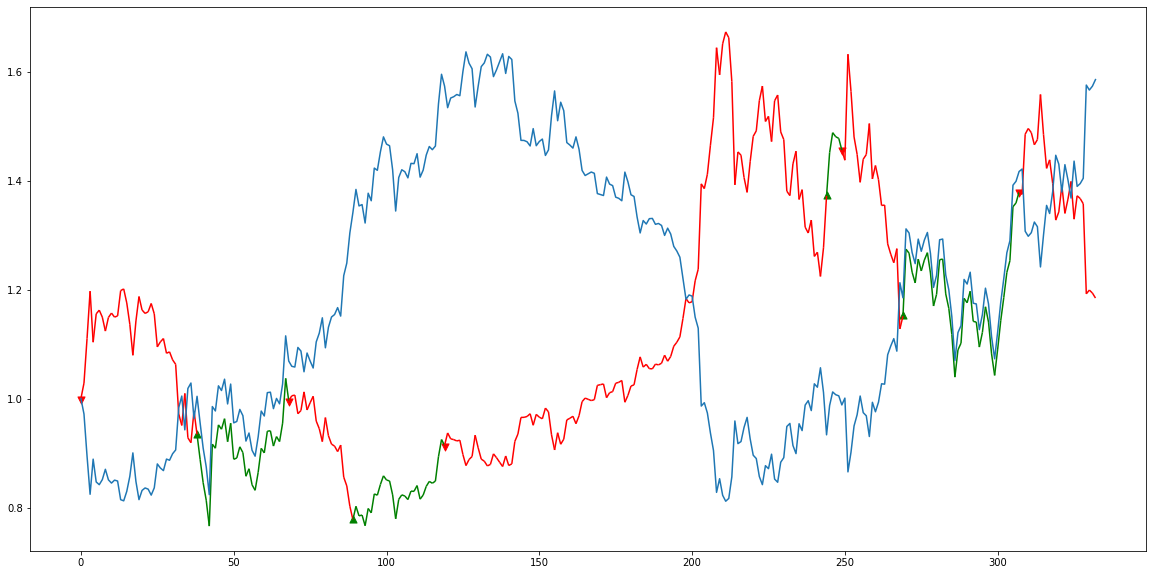

news-set-5 | 2:45:28  | Eval-dev | 575  | TSLA  | Agent:  -45.0% | Market:  696.4% | Diff: -741.5% | epsilon:  0.100 | loss: 3.9943708543432876e-05 | iterations: 144401


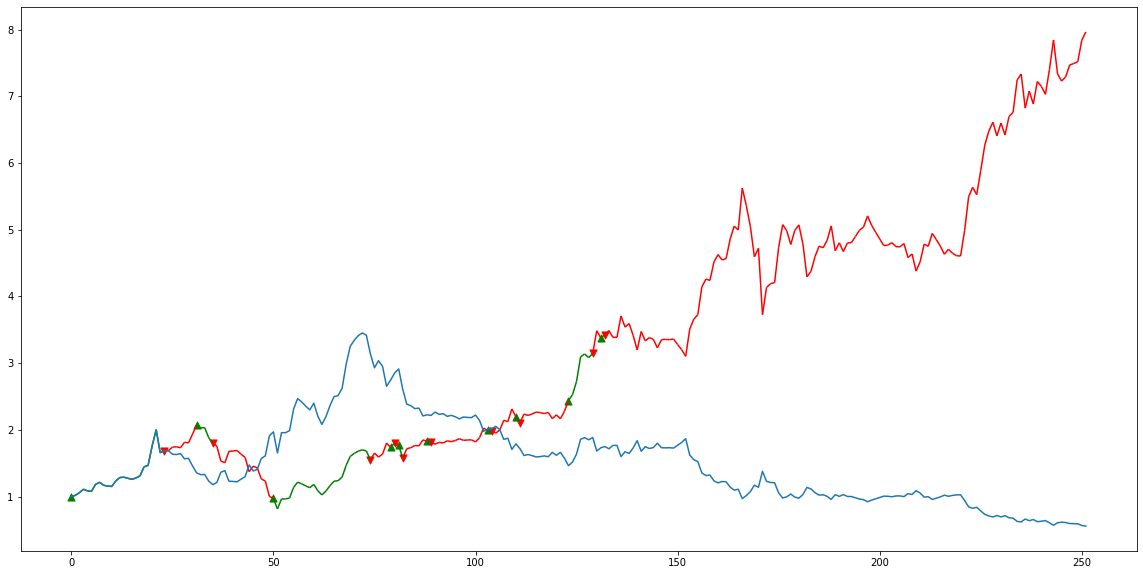

news-set-5 | 2:45:45  | Train | 576  | TSLA  | Agent:   62.1% | Market:   -8.9% | Diff:   71.0% | epsilon:  0.100 | loss: 3.913727414328605e-05 | iterations: 144653
news-set-5 | 2:46:03  | Train | 577  | TSLA  | Agent:   14.4% | Market:  -34.0% | Diff:   48.4% | epsilon:  0.100 | loss: 3.829930938081816e-05 | iterations: 144905
news-set-5 | 2:46:20  | Train | 578  | TSLA  | Agent:   13.1% | Market:  -14.3% | Diff:   27.3% | epsilon:  0.100 | loss: 3.7700745451729745e-05 | iterations: 145157
news-set-5 | 2:46:38  | Train | 579  | TSLA  | Agent:   62.6% | Market:   -5.6% | Diff:   68.2% | epsilon:  0.100 | loss: 3.699100489029661e-05 | iterations: 145409
news-set-5 | 2:46:55  | Train | 580  | TSLA  | Agent:  -36.0% | Market:   -5.1% | Diff:  -30.9% | epsilon:  0.100 | loss: 3.625195677159354e-05 | iterations: 145661
news-set-5 | 2:47:12  | Train | 581  | TSLA  | Agent:   48.3% | Market:   20.7% | Diff:   27.6% | epsilon:  0.100 | loss: 3.54617768607568e-05 | iterations: 145913
news-set-5

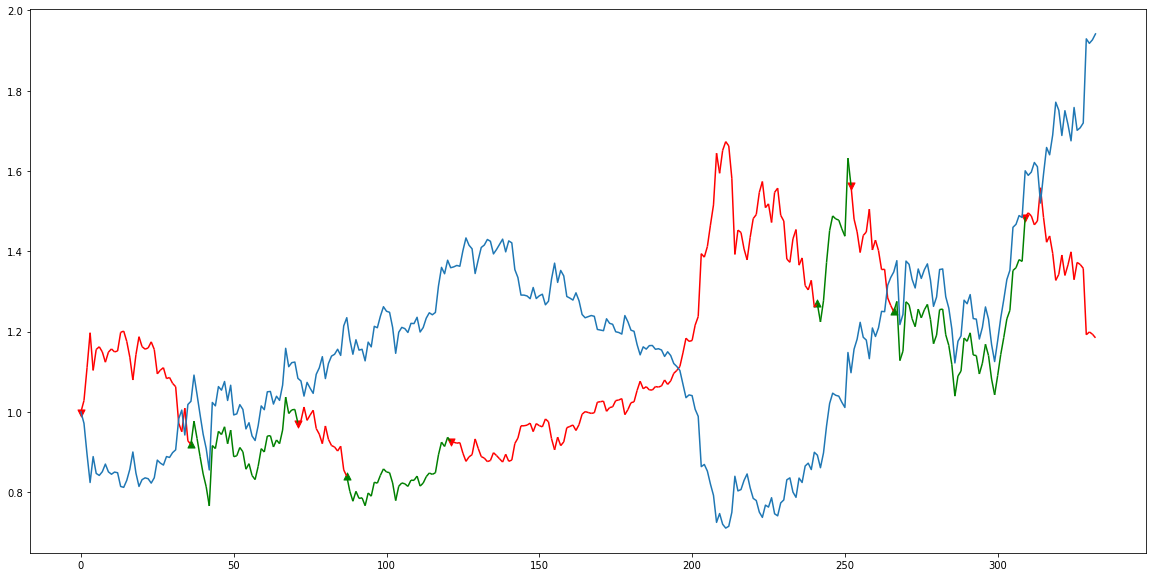

news-set-5 | 2:53:00  | Eval-dev | 600  | TSLA  | Agent:  -15.1% | Market:  696.4% | Diff: -711.5% | epsilon:  0.100 | loss: 1.803713348635938e-05 | iterations: 150701


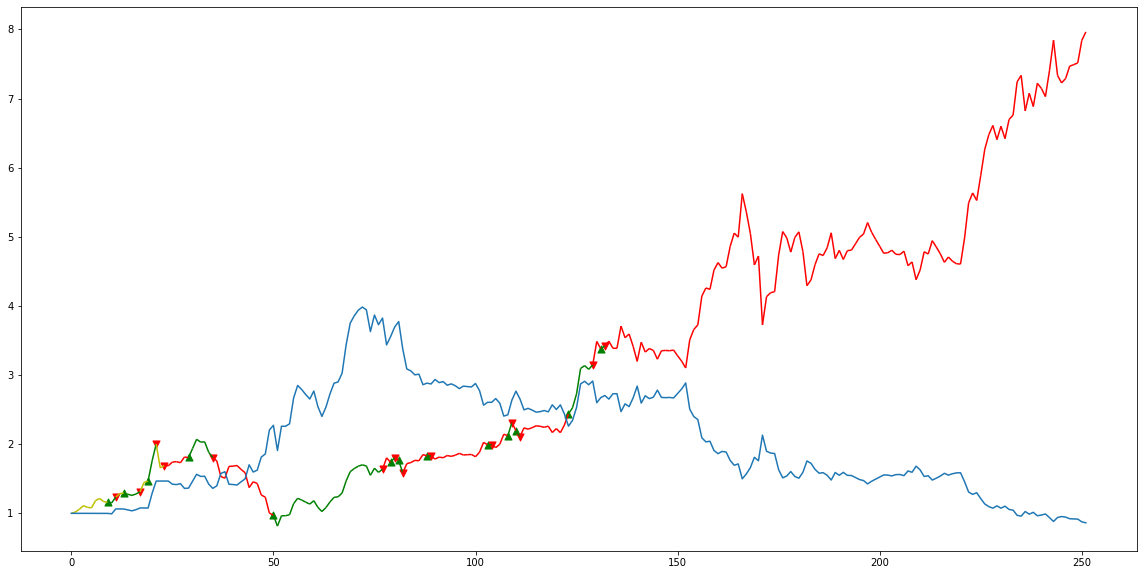

news-set-5 | 2:53:18  | Train | 601  | TSLA  | Agent:  137.4% | Market:  -12.0% | Diff:  149.4% | epsilon:  0.100 | loss: 1.6950567442108877e-05 | iterations: 150953
news-set-5 | 2:53:36  | Train | 602  | TSLA  | Agent:   71.7% | Market:  -29.9% | Diff:  101.7% | epsilon:  0.100 | loss: 1.588481063663494e-05 | iterations: 151205
news-set-5 | 2:53:53  | Train | 603  | TSLA  | Agent:   74.1% | Market:  -11.5% | Diff:   85.7% | epsilon:  0.100 | loss: 1.4807476873102132e-05 | iterations: 151457
news-set-5 | 2:54:10  | Train | 604  | TSLA  | Agent:   17.3% | Market:  -24.0% | Diff:   41.3% | epsilon:  0.100 | loss: 1.379202240059385e-05 | iterations: 151709
news-set-5 | 2:54:28  | Train | 605  | TSLA  | Agent:   79.0% | Market:  -20.1% | Diff:   99.1% | epsilon:  0.100 | loss: 1.2797454473911785e-05 | iterations: 151961
news-set-5 | 2:54:45  | Train | 606  | TSLA  | Agent:   16.7% | Market:  -35.8% | Diff:   52.5% | epsilon:  0.100 | loss: 1.190179682453163e-05 | iterations: 152213
news-se

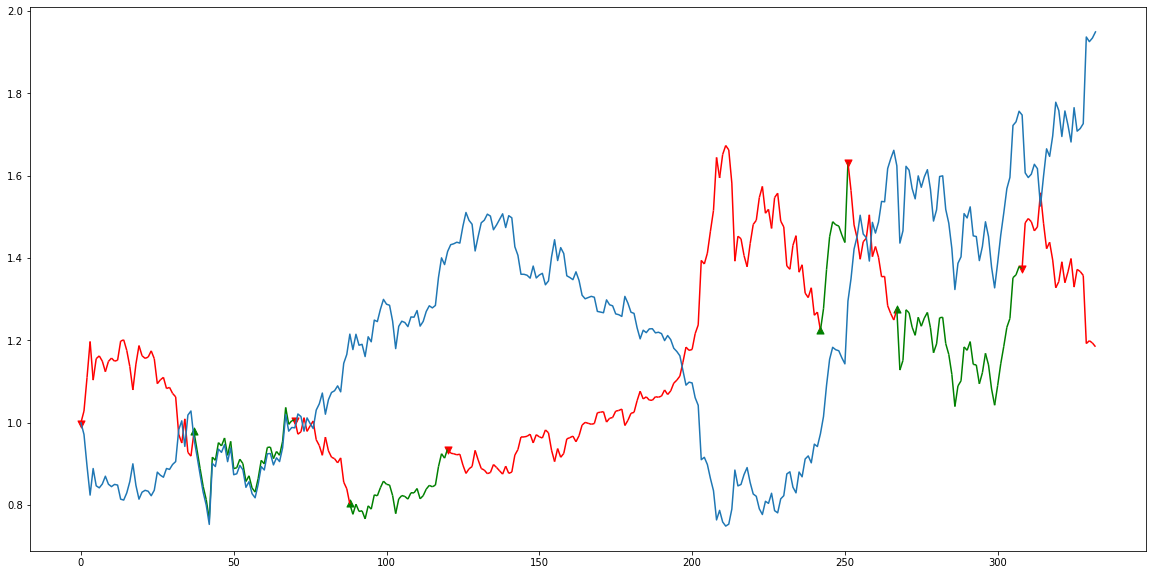

news-set-5 | 3:00:34  | Eval-dev | 625  | TSLA  | Agent:  -79.1% | Market:  696.4% | Diff: -775.6% | epsilon:  0.100 | loss: 2.944177140307147e-06 | iterations: 157001


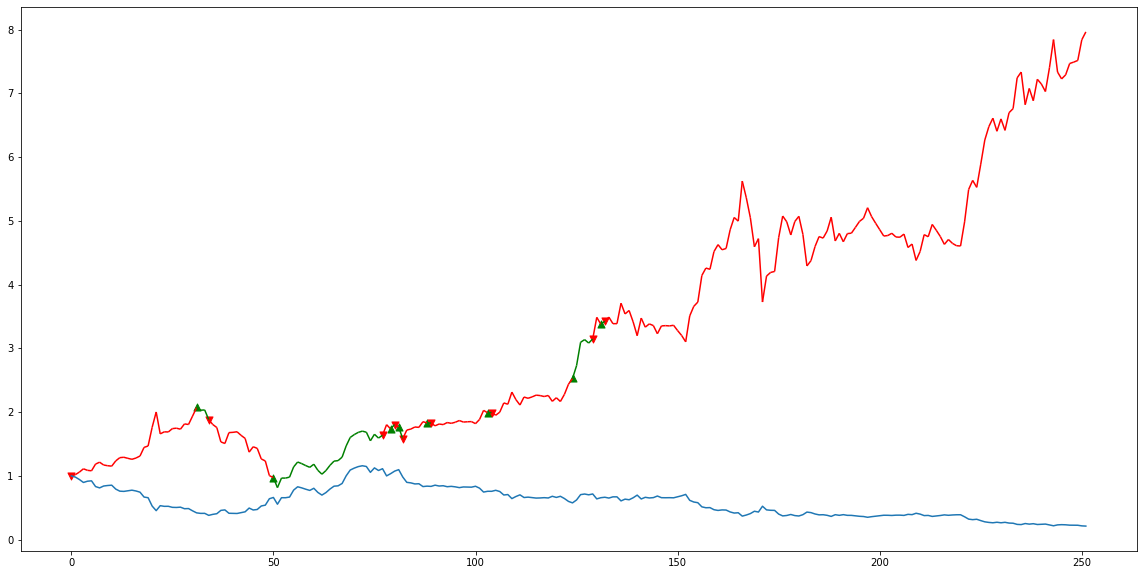

news-set-5 | 3:00:52  | Train | 626  | TSLA  | Agent:  -29.9% | Market:   86.6% | Diff: -116.5% | epsilon:  0.100 | loss: 2.845953304131399e-06 | iterations: 157253
news-set-5 | 3:01:09  | Train | 627  | TSLA  | Agent:   31.2% | Market:   14.6% | Diff:   16.6% | epsilon:  0.100 | loss: 2.7143003080709605e-06 | iterations: 157505
news-set-5 | 3:01:26  | Train | 628  | TSLA  | Agent:   20.7% | Market:   12.7% | Diff:    8.0% | epsilon:  0.100 | loss: 2.6191144115728093e-06 | iterations: 157757
news-set-5 | 3:01:43  | Train | 629  | TSLA  | Agent:  132.5% | Market:   -2.1% | Diff:  134.5% | epsilon:  0.100 | loss: 2.5308042950200615e-06 | iterations: 158009
news-set-5 | 3:02:01  | Train | 630  | TSLA  | Agent:  177.5% | Market:   -4.2% | Diff:  181.7% | epsilon:  0.100 | loss: 2.5003819246194325e-06 | iterations: 158261
news-set-5 | 3:02:18  | Train | 631  | TSLA  | Agent:   18.2% | Market:   43.5% | Diff:  -25.3% | epsilon:  0.100 | loss: 2.4513199150533183e-06 | iterations: 158513
news-

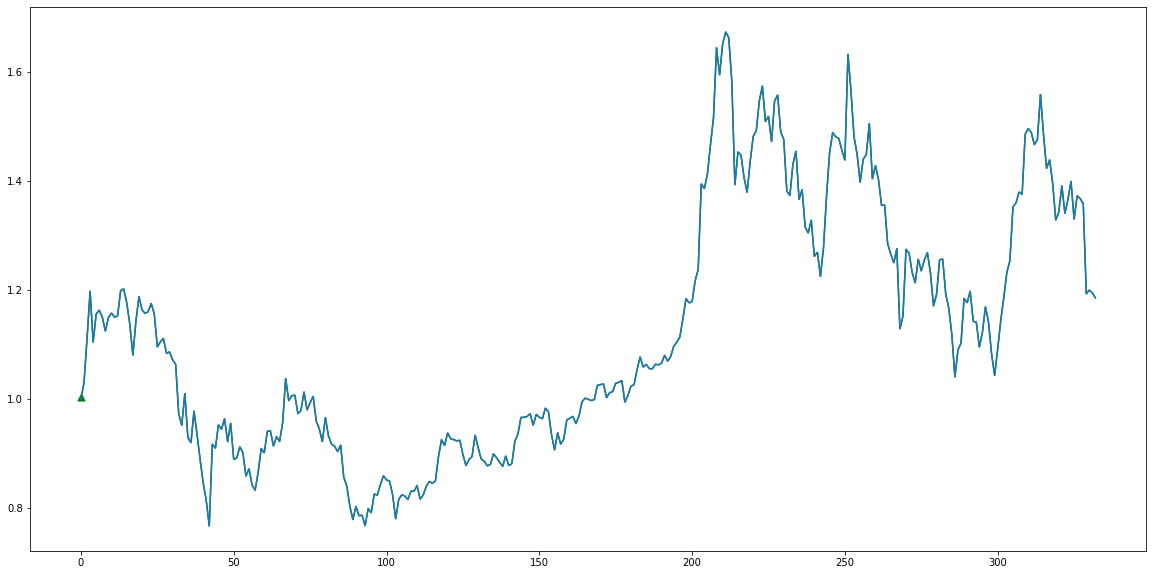

news-set-5 | 3:08:06  | Eval-dev | 650  | TSLA  | Agent:  513.6% | Market:  696.4% | Diff: -182.8% | epsilon:  0.100 | loss: 2.582857177912956e-06 | iterations: 163301


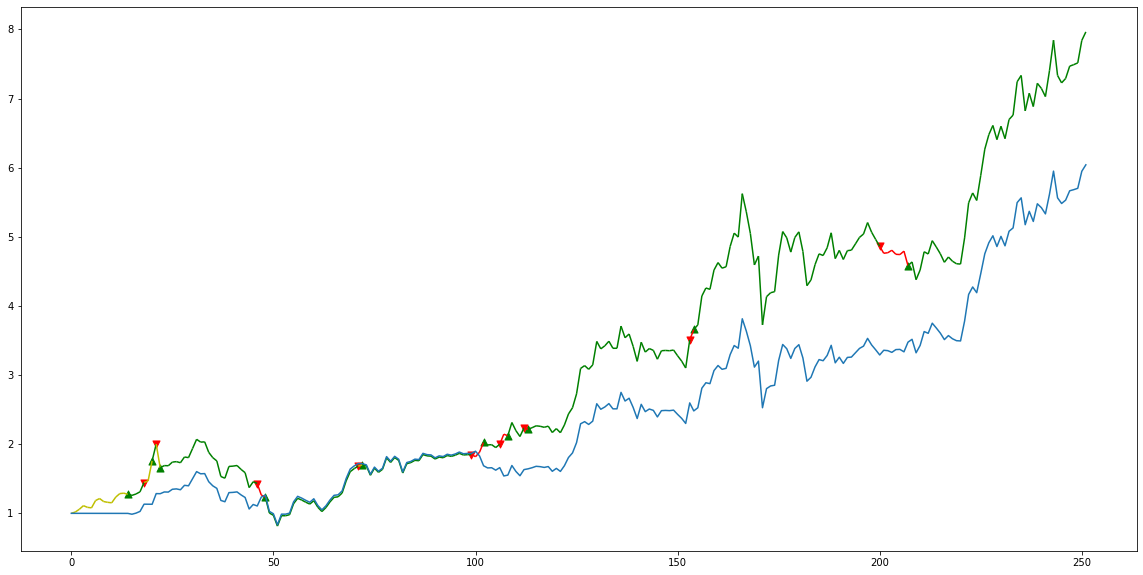

news-set-5 | 3:08:23  | Train | 651  | TSLA  | Agent:  144.8% | Market:  -11.9% | Diff:  156.7% | epsilon:  0.100 | loss: 2.6022910333267646e-06 | iterations: 163553
news-set-5 | 3:08:41  | Train | 652  | TSLA  | Agent:   12.0% | Market:   33.7% | Diff:  -21.8% | epsilon:  0.100 | loss: 2.6040402190119494e-06 | iterations: 163805
news-set-5 | 3:08:58  | Train | 653  | TSLA  | Agent:  108.9% | Market:  -15.3% | Diff:  124.2% | epsilon:  0.100 | loss: 2.581313083283021e-06 | iterations: 164057
news-set-5 | 3:09:15  | Train | 654  | TSLA  | Agent:  131.8% | Market:   -0.5% | Diff:  132.3% | epsilon:  0.100 | loss: 2.5833683139353525e-06 | iterations: 164309
news-set-5 | 3:09:33  | Train | 655  | TSLA  | Agent:  120.6% | Market:  -18.5% | Diff:  139.1% | epsilon:  0.100 | loss: 2.6468831038073404e-06 | iterations: 164561
news-set-5 | 3:09:50  | Train | 656  | TSLA  | Agent:   45.4% | Market:    9.2% | Diff:   36.1% | epsilon:  0.100 | loss: 2.68830694949429e-06 | iterations: 164813
news-se

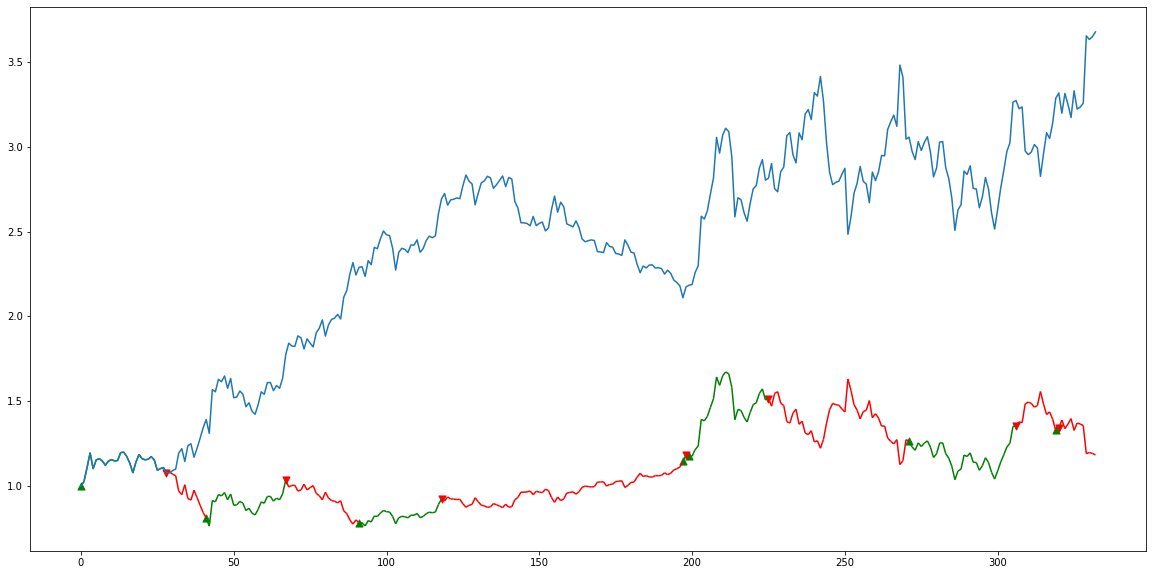

news-set-5 | 3:15:39  | Eval-dev | 675  | TSLA  | Agent:  -34.0% | Market:  696.4% | Diff: -730.4% | epsilon:  0.100 | loss: 3.216186087229289e-06 | iterations: 169601


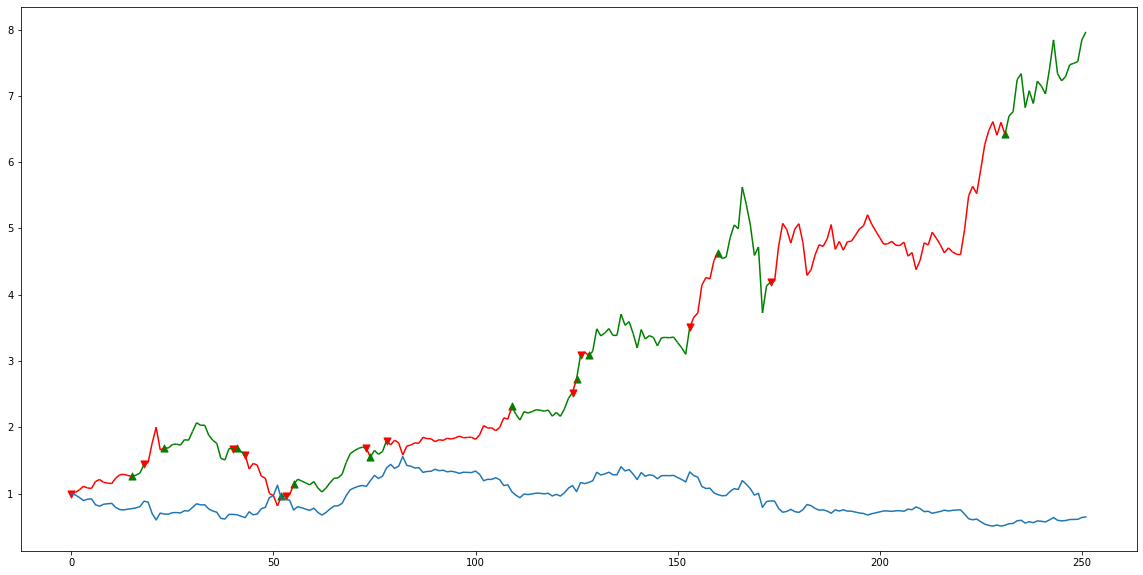

news-set-5 | 3:15:56  | Train | 676  | TSLA  | Agent:   27.7% | Market:   -2.1% | Diff:   29.8% | epsilon:  0.100 | loss: 3.2726422887208173e-06 | iterations: 169853
news-set-5 | 3:16:13  | Train | 677  | TSLA  | Agent:  225.3% | Market:   26.8% | Diff:  198.5% | epsilon:  0.100 | loss: 3.2959460440906696e-06 | iterations: 170105
news-set-5 | 3:16:31  | Train | 678  | TSLA  | Agent:   82.4% | Market:   -8.4% | Diff:   90.7% | epsilon:  0.100 | loss: 3.329228547954699e-06 | iterations: 170357
news-set-5 | 3:16:48  | Train | 679  | TSLA  | Agent:  -26.2% | Market:   61.1% | Diff:  -87.3% | epsilon:  0.100 | loss: 3.3454455206083367e-06 | iterations: 170609
news-set-5 | 3:17:06  | Train | 680  | TSLA  | Agent:   86.6% | Market:   22.4% | Diff:   64.2% | epsilon:  0.100 | loss: 3.4072852486133343e-06 | iterations: 170861
news-set-5 | 3:17:23  | Train | 681  | TSLA  | Agent:   -3.2% | Market:  -13.4% | Diff:   10.2% | epsilon:  0.100 | loss: 3.4590311770443805e-06 | iterations: 171113
news-

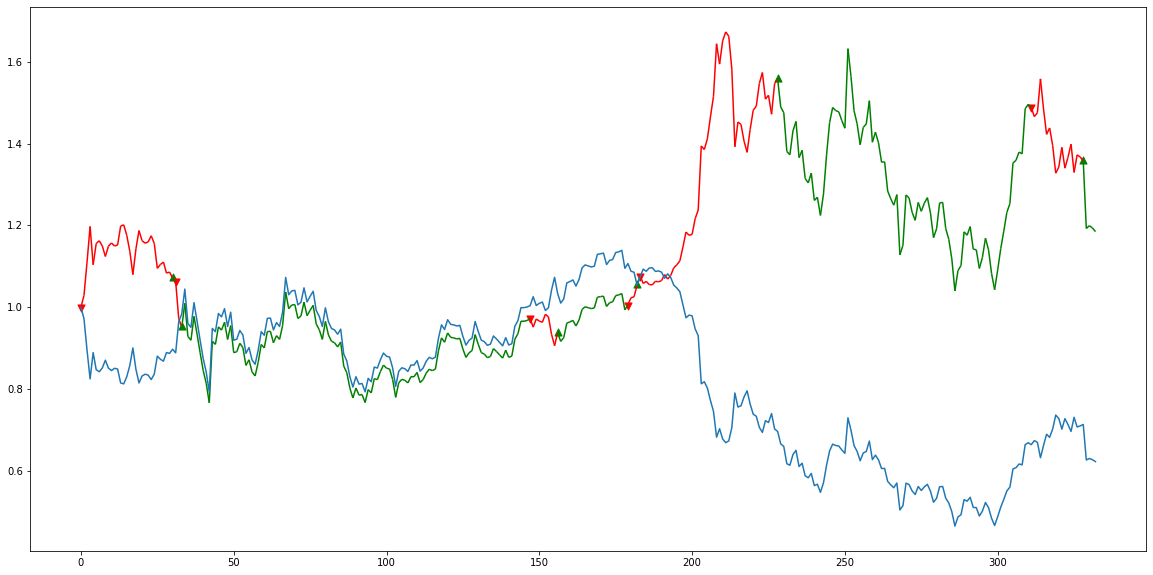

news-set-5 | 3:23:13  | Eval-dev | 700  | TSLA  | Agent:  -15.5% | Market:  696.4% | Diff: -711.9% | epsilon:  0.100 | loss: 4.068787347932812e-06 | iterations: 175901


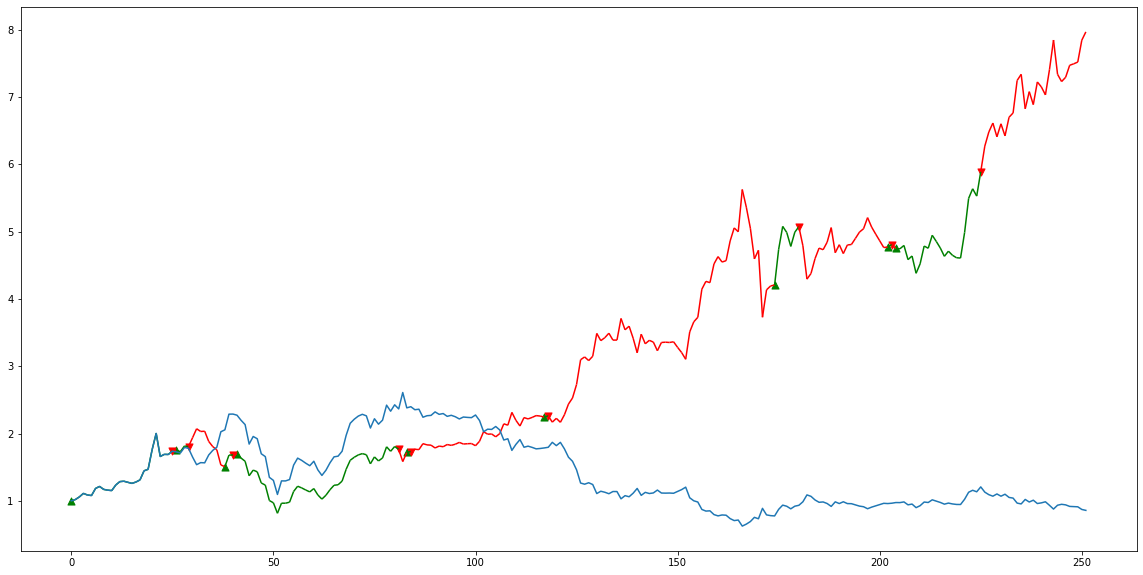

news-set-5 | 3:23:31  | Train | 701  | TSLA  | Agent:   11.8% | Market:   -9.3% | Diff:   21.1% | epsilon:  0.100 | loss: 4.113775048608659e-06 | iterations: 176153
news-set-5 | 3:23:48  | Train | 702  | TSLA  | Agent:   18.8% | Market:  -16.1% | Diff:   34.9% | epsilon:  0.100 | loss: 4.213400188746164e-06 | iterations: 176405
news-set-5 | 3:24:06  | Train | 703  | TSLA  | Agent:  194.7% | Market:  -13.0% | Diff:  207.6% | epsilon:  0.100 | loss: 4.298157818993786e-06 | iterations: 176657
news-set-5 | 3:24:23  | Train | 704  | TSLA  | Agent:   16.2% | Market:  -10.0% | Diff:   26.2% | epsilon:  0.100 | loss: 4.33113473263802e-06 | iterations: 176909
news-set-5 | 3:24:41  | Train | 705  | TSLA  | Agent:   63.1% | Market:  -34.0% | Diff:   97.1% | epsilon:  0.100 | loss: 4.382480710773962e-06 | iterations: 177161
news-set-5 | 3:24:59  | Train | 706  | TSLA  | Agent:   46.3% | Market:  -11.5% | Diff:   57.8% | epsilon:  0.100 | loss: 4.460842319531366e-06 | iterations: 177413
news-set-5 

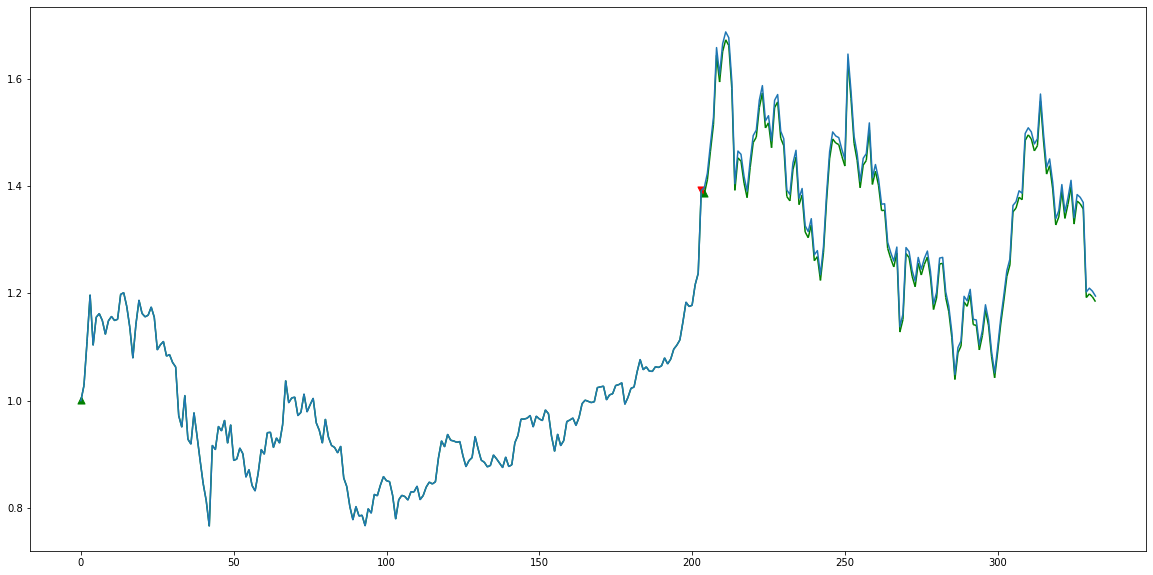

news-set-5 | 3:31:08  | Eval-dev | 725  | TSLA  | Agent:  222.4% | Market:  696.4% | Diff: -474.1% | epsilon:  0.100 | loss: 5.0148646550951526e-06 | iterations: 182201


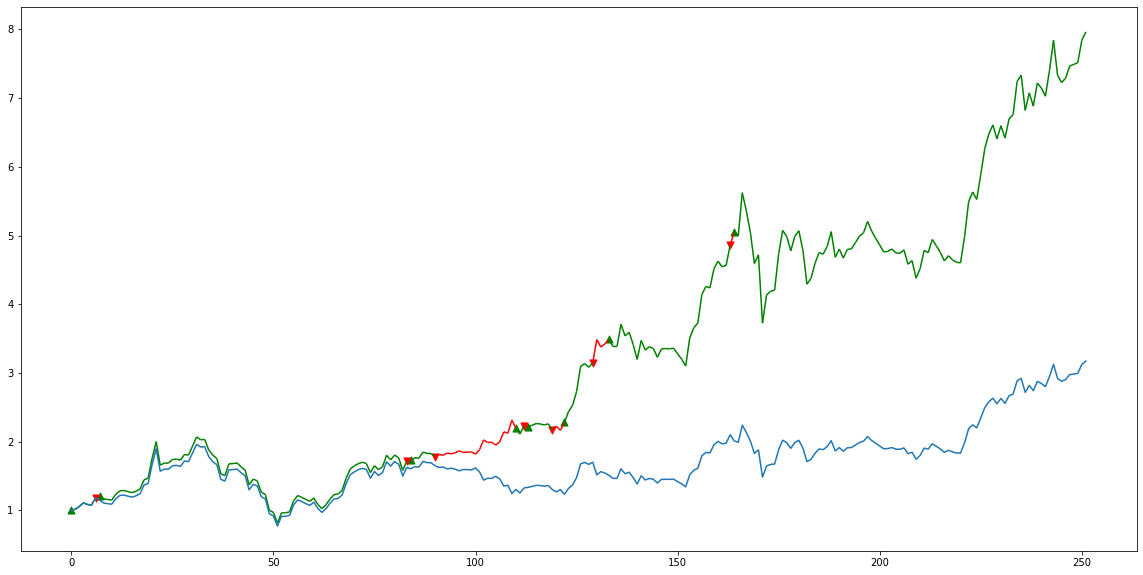

news-set-5 | 3:31:26  | Train | 726  | TSLA  | Agent:   65.4% | Market:    6.5% | Diff:   58.9% | epsilon:  0.100 | loss: 5.0814410315069836e-06 | iterations: 182453
news-set-5 | 3:31:45  | Train | 727  | TSLA  | Agent:  113.7% | Market:   -5.7% | Diff:  119.4% | epsilon:  0.100 | loss: 5.1248948693682905e-06 | iterations: 182705
news-set-5 | 3:32:03  | Train | 728  | TSLA  | Agent:   13.8% | Market:   42.4% | Diff:  -28.7% | epsilon:  0.100 | loss: 5.146273906575516e-06 | iterations: 182957
news-set-5 | 3:32:21  | Train | 729  | TSLA  | Agent:   83.3% | Market:  -18.6% | Diff:  101.9% | epsilon:  0.100 | loss: 5.194178356759949e-06 | iterations: 183209
news-set-5 | 3:32:39  | Train | 730  | TSLA  | Agent:   52.7% | Market:   -7.1% | Diff:   59.8% | epsilon:  0.100 | loss: 5.2025097829755396e-06 | iterations: 183461
news-set-5 | 3:32:58  | Train | 731  | TSLA  | Agent:   13.1% | Market:   37.3% | Diff:  -24.2% | epsilon:  0.100 | loss: 5.2278514885983896e-06 | iterations: 183713
news-s

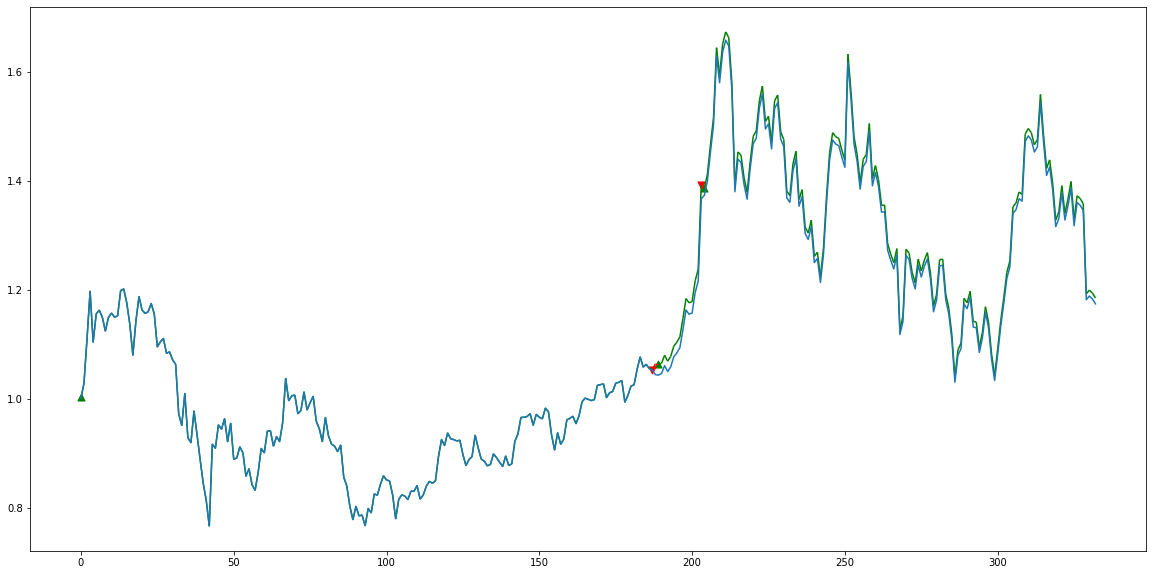

news-set-5 | 3:39:03  | Eval-dev | 750  | TSLA  | Agent:  206.2% | Market:  696.4% | Diff: -490.3% | epsilon:  0.100 | loss: 5.88535112910904e-06 | iterations: 188501


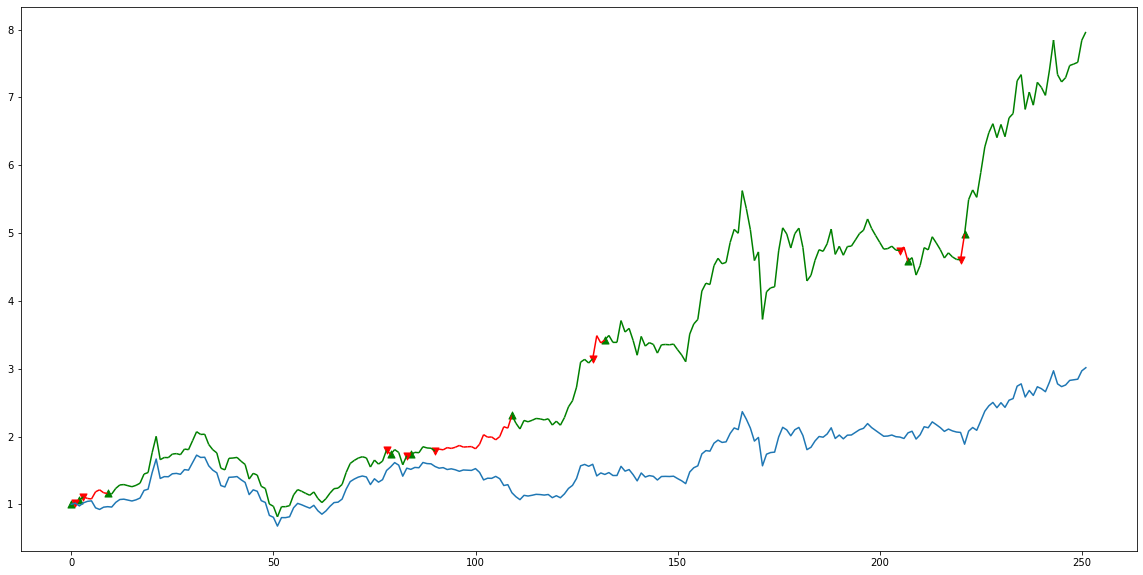

news-set-5 | 3:39:22  | Train | 751  | TSLA  | Agent:  263.2% | Market:    4.9% | Diff:  258.3% | epsilon:  0.100 | loss: 5.891506134503288e-06 | iterations: 188753
news-set-5 | 3:39:40  | Train | 752  | TSLA  | Agent:   54.7% | Market:   10.5% | Diff:   44.2% | epsilon:  0.100 | loss: 5.928964583290508e-06 | iterations: 189005
news-set-5 | 3:39:58  | Train | 753  | TSLA  | Agent:  153.3% | Market:  -19.0% | Diff:  172.2% | epsilon:  0.100 | loss: 6.014054179104278e-06 | iterations: 189257
news-set-5 | 3:40:17  | Train | 754  | TSLA  | Agent:   83.2% | Market:   51.9% | Diff:   31.3% | epsilon:  0.100 | loss: 6.053297511243727e-06 | iterations: 189509
news-set-5 | 3:40:35  | Train | 755  | TSLA  | Agent:   30.9% | Market:   44.4% | Diff:  -13.5% | epsilon:  0.100 | loss: 6.077492344047641e-06 | iterations: 189761
news-set-5 | 3:40:53  | Train | 756  | TSLA  | Agent:  132.8% | Market:   -9.2% | Diff:  142.0% | epsilon:  0.100 | loss: 6.139047400210984e-06 | iterations: 190013
news-set-5

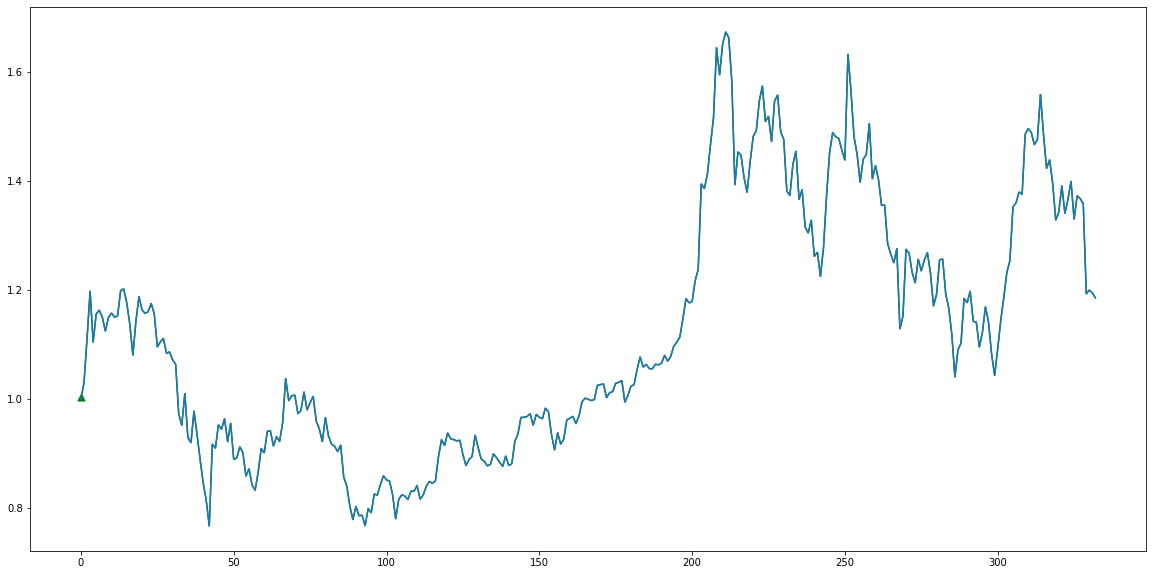

news-set-5 | 3:47:01  | Eval-dev | 775  | TSLA  | Agent:  403.1% | Market:  696.4% | Diff: -293.3% | epsilon:  0.100 | loss: 6.785065124859102e-06 | iterations: 194801


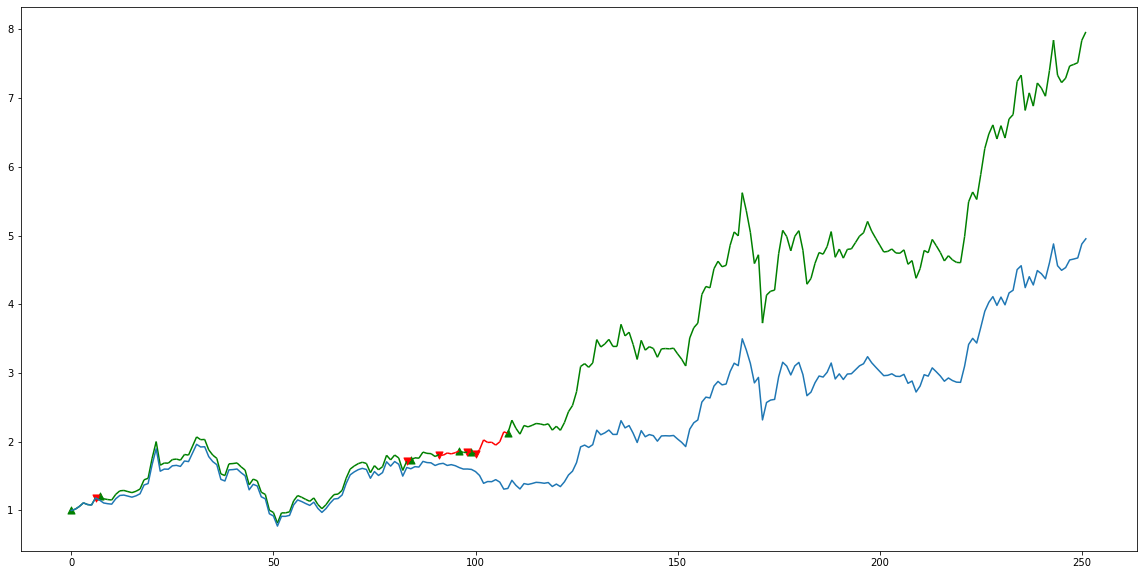

news-set-5 | 3:47:19  | Train | 776  | TSLA  | Agent:   31.2% | Market:   37.3% | Diff:   -6.1% | epsilon:  0.100 | loss: 6.775402198400116e-06 | iterations: 195053
news-set-5 | 3:47:37  | Train | 777  | TSLA  | Agent:  124.0% | Market:  -13.2% | Diff:  137.2% | epsilon:  0.100 | loss: 6.7595938162412494e-06 | iterations: 195305
news-set-5 | 3:47:56  | Train | 778  | TSLA  | Agent:  243.1% | Market:  -13.6% | Diff:  256.8% | epsilon:  0.100 | loss: 6.784403012716211e-06 | iterations: 195557
news-set-5 | 3:48:14  | Train | 779  | TSLA  | Agent:  210.7% | Market:   15.7% | Diff:  195.0% | epsilon:  0.100 | loss: 6.842778020654805e-06 | iterations: 195809
news-set-5 | 3:48:32  | Train | 780  | TSLA  | Agent:  134.8% | Market:   -7.1% | Diff:  141.8% | epsilon:  0.100 | loss: 6.888726602483075e-06 | iterations: 196061
news-set-5 | 3:48:50  | Train | 781  | TSLA  | Agent:  157.1% | Market:  -17.9% | Diff:  175.1% | epsilon:  0.100 | loss: 6.84180076859775e-06 | iterations: 196313
news-set-5

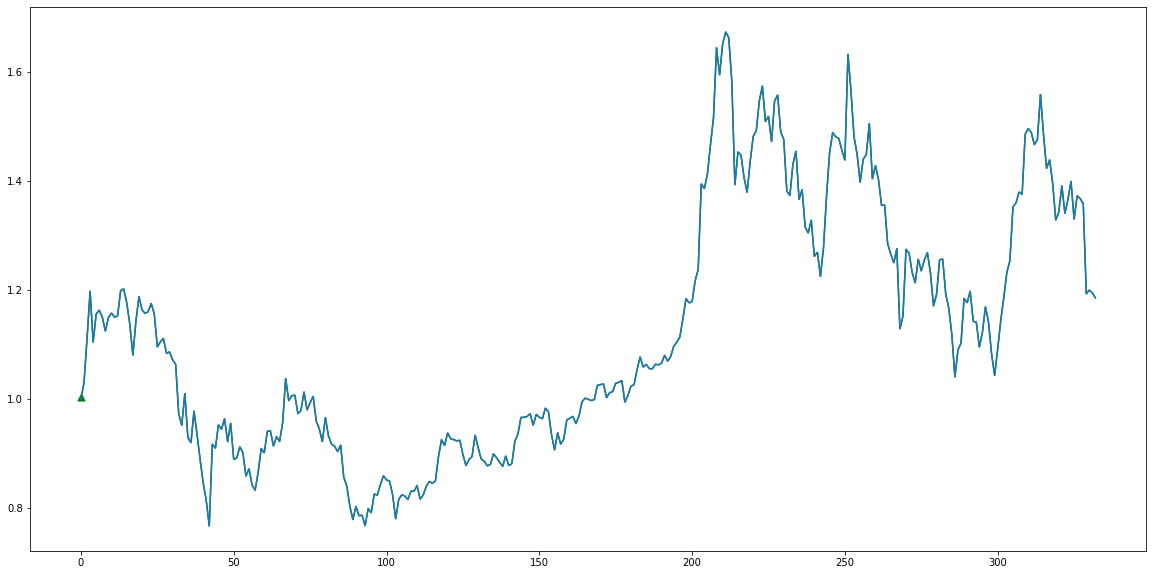

news-set-5 | 3:54:57  | Eval-dev | 800  | TSLA  | Agent:  285.4% | Market:  696.4% | Diff: -411.0% | epsilon:  0.100 | loss: 7.397721219604136e-06 | iterations: 201101


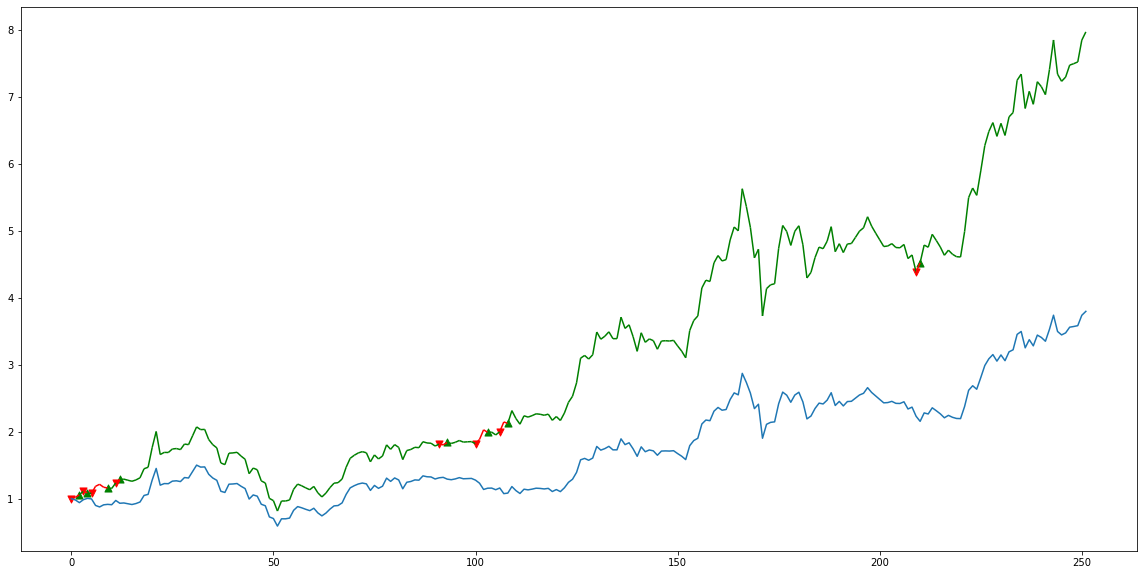

news-set-5 | 3:55:16  | Train | 801  | TSLA  | Agent:  280.3% | Market:  -12.7% | Diff:  293.0% | epsilon:  0.100 | loss: 7.413893854391063e-06 | iterations: 201353
news-set-5 | 3:55:34  | Train | 802  | TSLA  | Agent:  160.1% | Market:   -3.7% | Diff:  163.8% | epsilon:  0.100 | loss: 7.450656084984075e-06 | iterations: 201605
news-set-5 | 3:55:53  | Train | 803  | TSLA  | Agent:   82.4% | Market:   45.8% | Diff:   36.6% | epsilon:  0.100 | loss: 7.4875479185720906e-06 | iterations: 201857
news-set-5 | 3:56:11  | Train | 804  | TSLA  | Agent:   71.1% | Market:  -34.0% | Diff:  105.0% | epsilon:  0.100 | loss: 7.5418765845824964e-06 | iterations: 202109
news-set-5 | 3:56:29  | Train | 805  | TSLA  | Agent:   10.8% | Market:   67.0% | Diff:  -56.2% | epsilon:  0.100 | loss: 7.557628578069853e-06 | iterations: 202361
news-set-5 | 3:56:48  | Train | 806  | TSLA  | Agent:  104.9% | Market:  -26.6% | Diff:  131.5% | epsilon:  0.100 | loss: 7.589606411784189e-06 | iterations: 202613
news-set

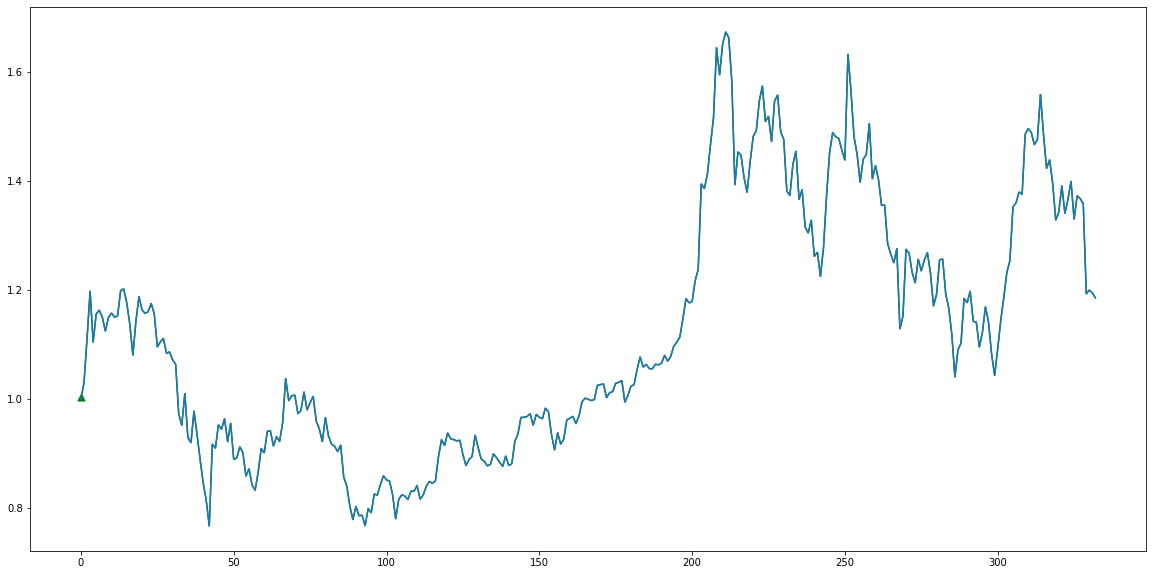

news-set-5 | 4:02:52  | Eval-dev | 825  | TSLA  | Agent:  129.8% | Market:  696.4% | Diff: -566.7% | epsilon:  0.100 | loss: 8.149972927640192e-06 | iterations: 207401


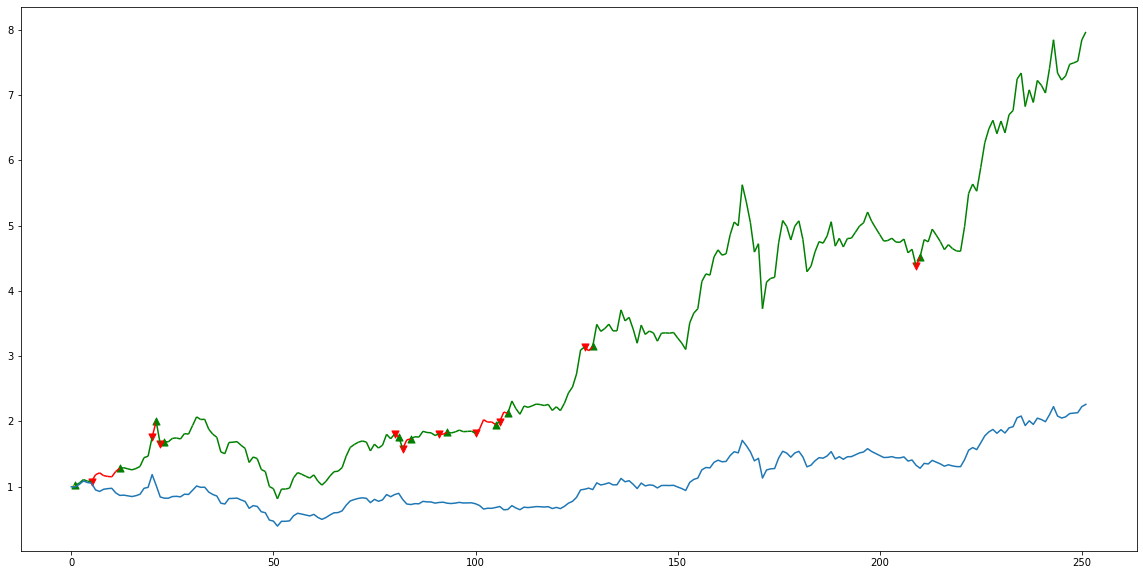

news-set-5 | 4:03:11  | Train | 826  | TSLA  | Agent:   68.3% | Market:  -12.4% | Diff:   80.8% | epsilon:  0.100 | loss: 8.168796739482787e-06 | iterations: 207653
news-set-5 | 4:03:29  | Train | 827  | TSLA  | Agent:   40.9% | Market:   91.4% | Diff:  -50.5% | epsilon:  0.100 | loss: 8.167609848896973e-06 | iterations: 207905
news-set-5 | 4:03:47  | Train | 828  | TSLA  | Agent:  101.4% | Market:   -7.6% | Diff:  109.0% | epsilon:  0.100 | loss: 8.171851732186042e-06 | iterations: 208157
news-set-5 | 4:04:05  | Train | 829  | TSLA  | Agent:   61.8% | Market:   23.9% | Diff:   37.9% | epsilon:  0.100 | loss: 8.219560186262242e-06 | iterations: 208409
news-set-5 | 4:04:23  | Train | 830  | TSLA  | Agent:  123.0% | Market:    6.5% | Diff:  116.5% | epsilon:  0.100 | loss: 8.237203473981936e-06 | iterations: 208661
news-set-5 | 4:04:42  | Train | 831  | TSLA  | Agent:  179.4% | Market:   -4.4% | Diff:  183.8% | epsilon:  0.100 | loss: 8.260606591647957e-06 | iterations: 208913
news-set-5

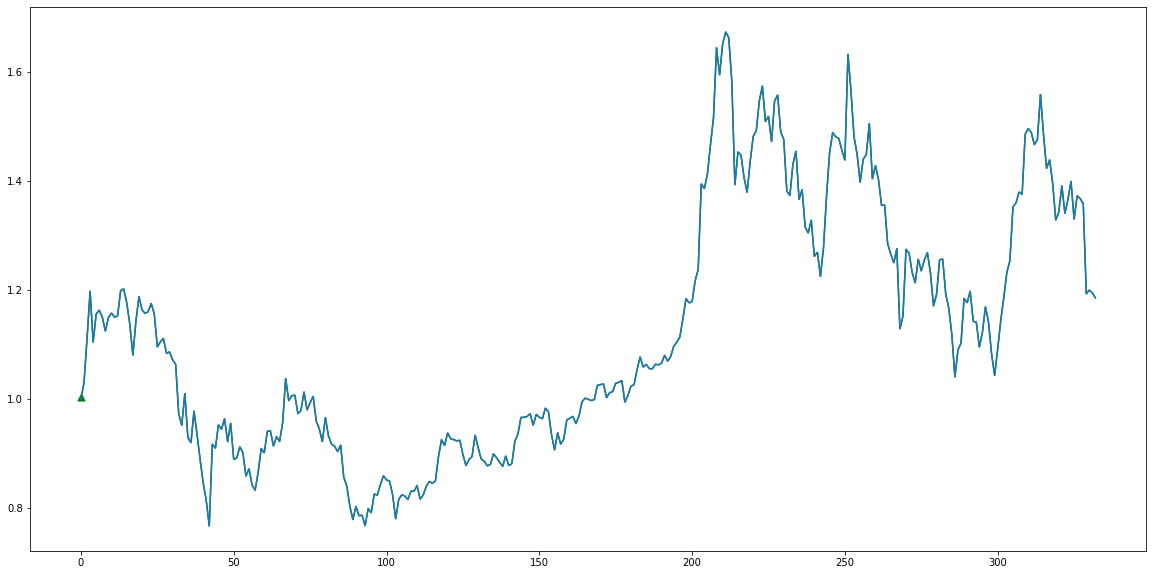

news-set-5 | 4:10:47  | Eval-dev | 850  | TSLA  | Agent:  259.7% | Market:  696.4% | Diff: -436.8% | epsilon:  0.100 | loss: 8.47433511808049e-06 | iterations: 213701


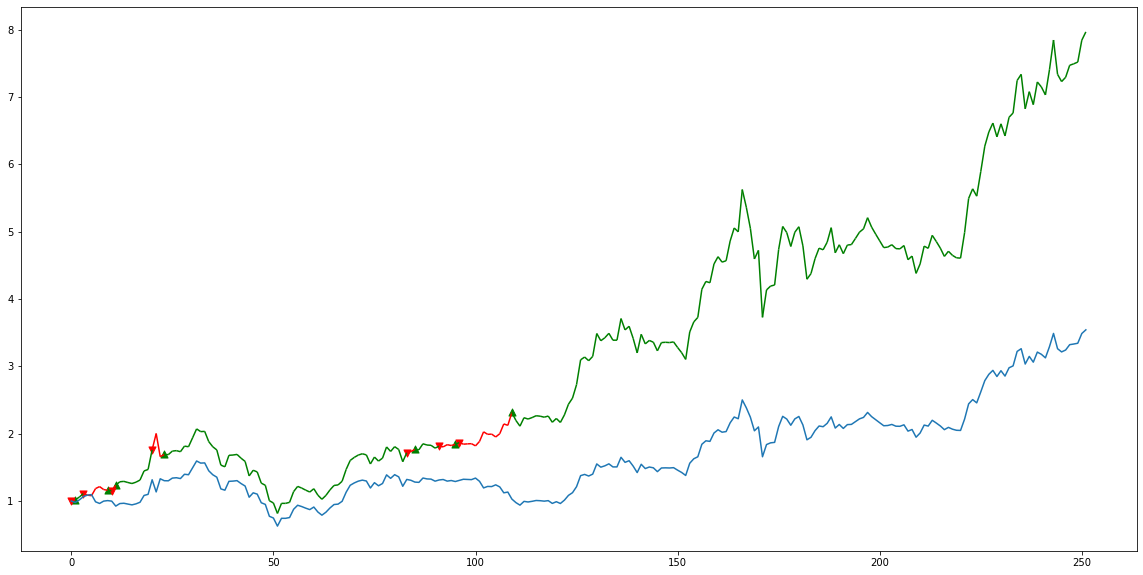

news-set-5 | 4:11:06  | Train | 851  | TSLA  | Agent:  -11.0% | Market:  -33.0% | Diff:   22.0% | epsilon:  0.100 | loss: 8.498510396748316e-06 | iterations: 213953
news-set-5 | 4:11:24  | Train | 852  | TSLA  | Agent:   32.9% | Market:  -35.6% | Diff:   68.5% | epsilon:  0.100 | loss: 8.506180165568367e-06 | iterations: 214205
news-set-5 | 4:11:42  | Train | 853  | TSLA  | Agent:  112.6% | Market:   15.1% | Diff:   97.5% | epsilon:  0.100 | loss: 8.49479329190217e-06 | iterations: 214457
news-set-5 | 4:12:00  | Train | 854  | TSLA  | Agent:  176.1% | Market:   -8.8% | Diff:  184.9% | epsilon:  0.100 | loss: 8.48865784064401e-06 | iterations: 214709
news-set-5 | 4:12:18  | Train | 855  | TSLA  | Agent:  190.4% | Market:   37.8% | Diff:  152.5% | epsilon:  0.100 | loss: 8.54230165714398e-06 | iterations: 214961
news-set-5 | 4:12:36  | Train | 856  | TSLA  | Agent:  128.1% | Market:  -22.7% | Diff:  150.8% | epsilon:  0.100 | loss: 8.57919076224789e-06 | iterations: 215213
news-set-5 | 4

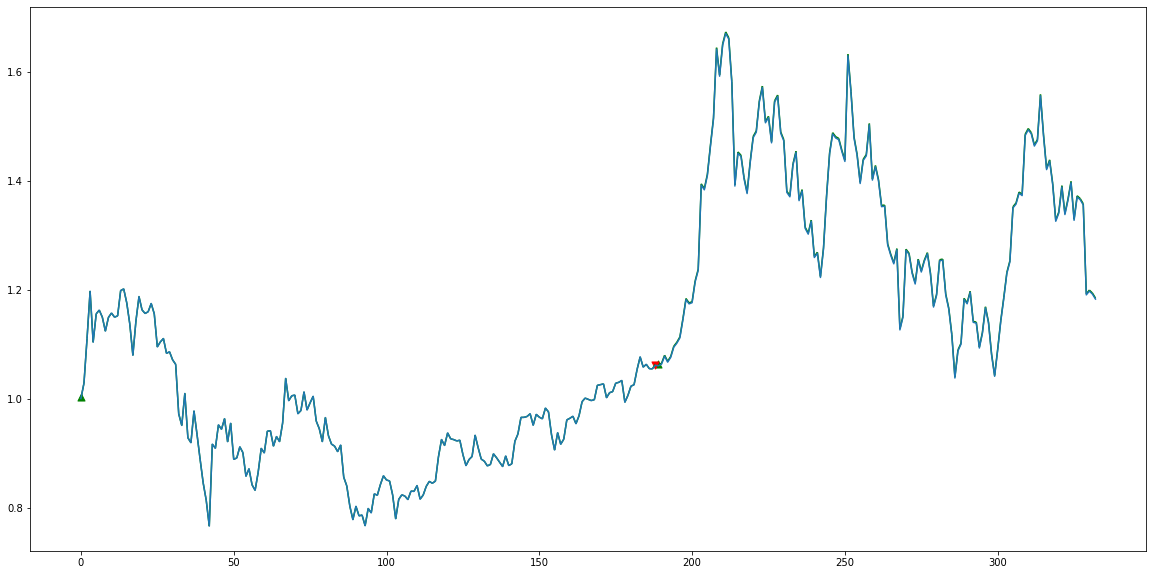

news-set-5 | 4:18:38  | Eval-dev | 875  | TSLA  | Agent:   64.5% | Market:  696.4% | Diff: -631.9% | epsilon:  0.100 | loss: 9.108928679779638e-06 | iterations: 220001


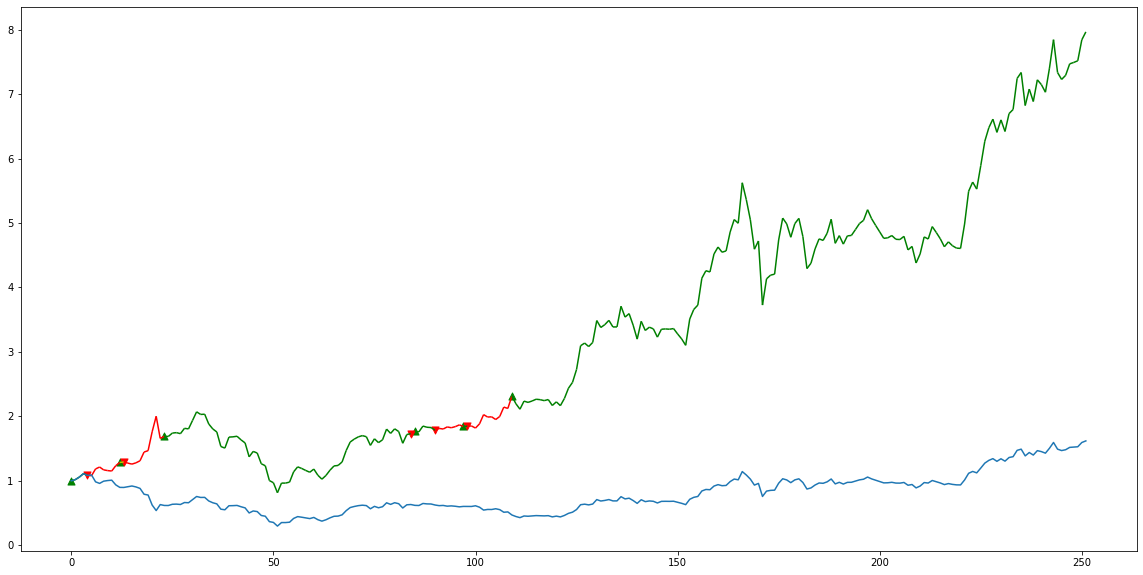

news-set-5 | 4:18:56  | Train | 876  | TSLA  | Agent:   90.5% | Market:   11.3% | Diff:   79.2% | epsilon:  0.100 | loss: 9.170868906949181e-06 | iterations: 220253
news-set-5 | 4:19:14  | Train | 877  | TSLA  | Agent:   52.1% | Market:   -4.2% | Diff:   56.3% | epsilon:  0.100 | loss: 9.235444849764463e-06 | iterations: 220505
news-set-5 | 4:19:32  | Train | 878  | TSLA  | Agent:  146.0% | Market:   -9.1% | Diff:  155.0% | epsilon:  0.100 | loss: 9.26241682464024e-06 | iterations: 220757
news-set-5 | 4:19:50  | Train | 879  | TSLA  | Agent:    3.3% | Market:   17.5% | Diff:  -14.1% | epsilon:  0.100 | loss: 9.256304110749625e-06 | iterations: 221009
news-set-5 | 4:20:08  | Train | 880  | TSLA  | Agent:  148.6% | Market:    0.6% | Diff:  148.0% | epsilon:  0.100 | loss: 9.263522770197596e-06 | iterations: 221261
news-set-5 | 4:20:27  | Train | 881  | TSLA  | Agent:   29.1% | Market:   22.2% | Diff:    6.9% | epsilon:  0.100 | loss: 9.294702067563776e-06 | iterations: 221513
news-set-5 

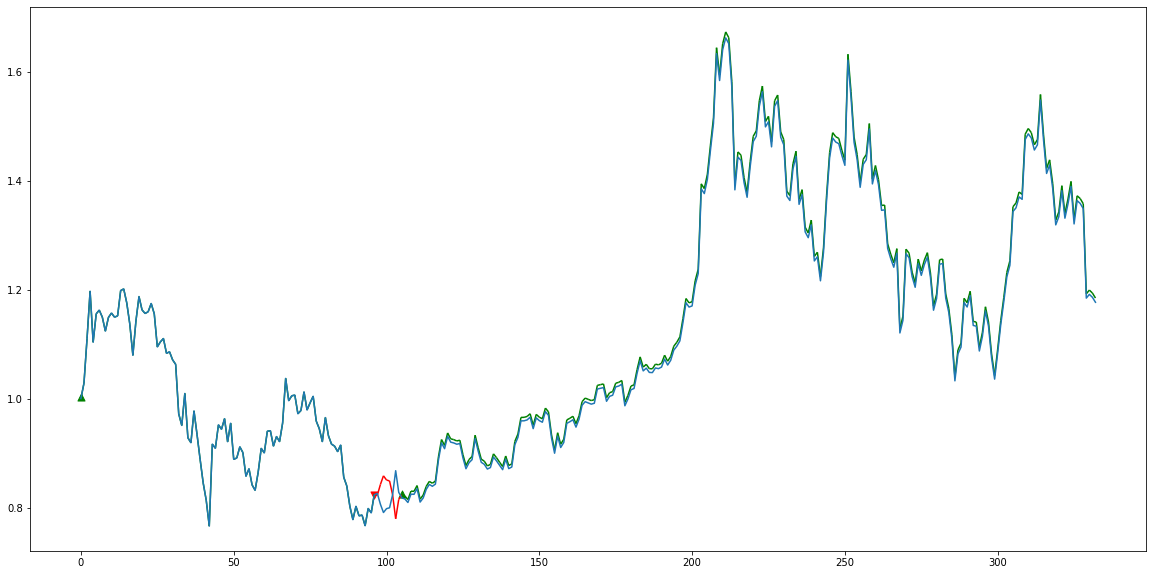

news-set-5 | 4:26:29  | Eval-dev | 900  | TSLA  | Agent:  300.6% | Market:  696.4% | Diff: -395.8% | epsilon:  0.100 | loss: 9.507691174803767e-06 | iterations: 226301


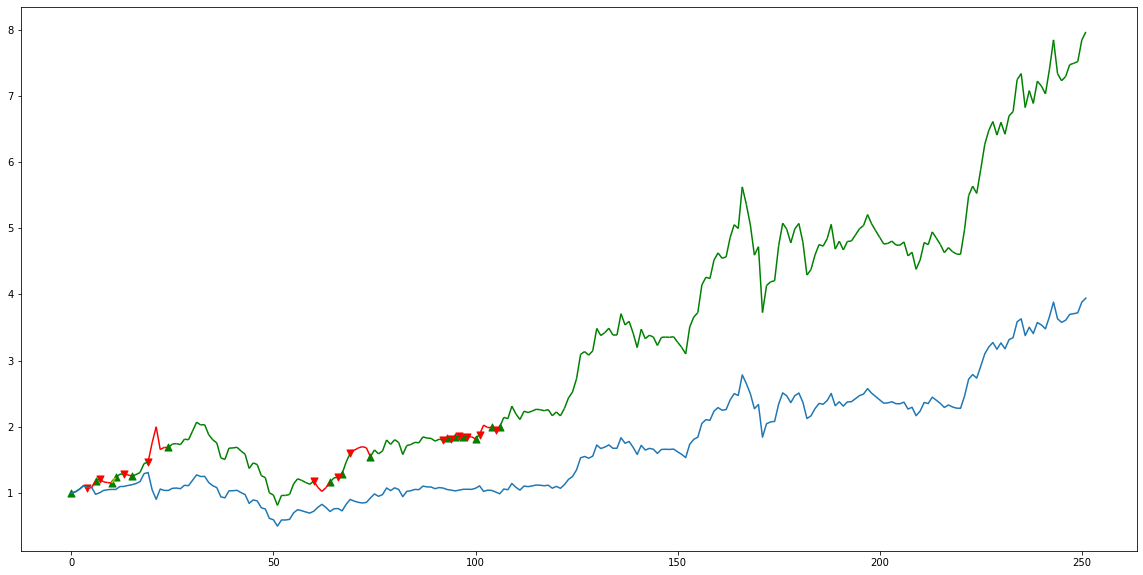

news-set-5 | 4:26:47  | Train | 901  | TSLA  | Agent:   52.2% | Market:   48.9% | Diff:    3.3% | epsilon:  0.100 | loss: 9.590915396984201e-06 | iterations: 226553
news-set-5 | 4:27:05  | Train | 902  | TSLA  | Agent:  351.8% | Market:   24.6% | Diff:  327.2% | epsilon:  0.100 | loss: 9.647511433286127e-06 | iterations: 226805
news-set-5 | 4:27:23  | Train | 903  | TSLA  | Agent:   55.3% | Market:  -13.5% | Diff:   68.8% | epsilon:  0.100 | loss: 9.682268682809081e-06 | iterations: 227057
news-set-5 | 4:27:41  | Train | 904  | TSLA  | Agent:   50.7% | Market:   68.3% | Diff:  -17.6% | epsilon:  0.100 | loss: 9.680782568466384e-06 | iterations: 227309
news-set-5 | 4:27:59  | Train | 905  | TSLA  | Agent:   48.5% | Market:   -5.6% | Diff:   54.0% | epsilon:  0.100 | loss: 9.680152288638055e-06 | iterations: 227561
news-set-5 | 4:28:17  | Train | 906  | TSLA  | Agent:  100.8% | Market:   20.8% | Diff:   80.0% | epsilon:  0.100 | loss: 9.823780601436738e-06 | iterations: 227813
news-set-5

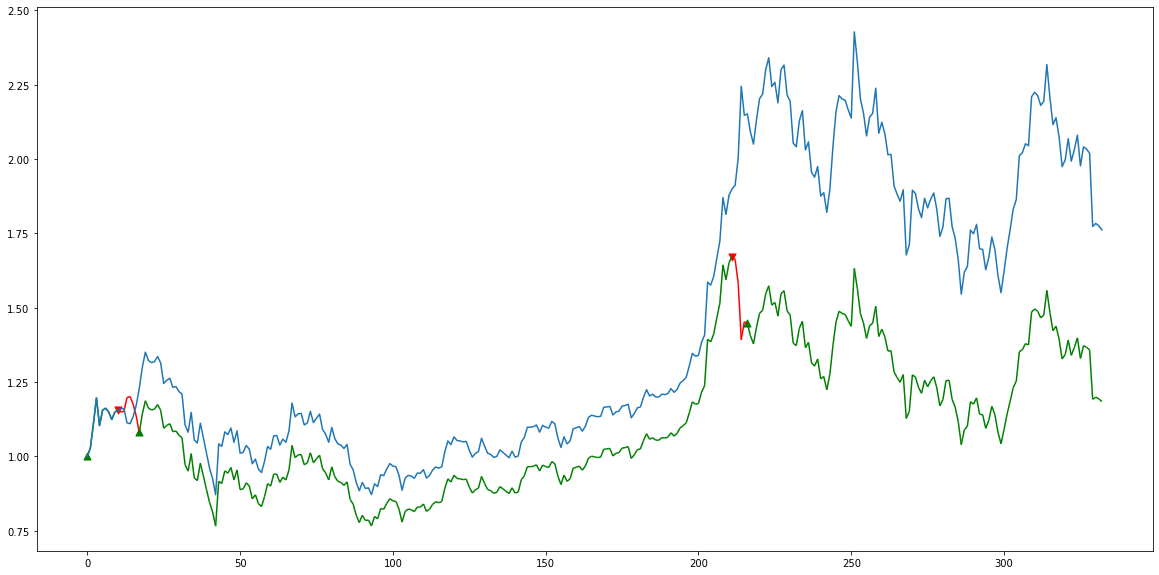

news-set-5 | 4:34:16  | Eval-dev | 925  | TSLA  | Agent:  128.6% | Market:  696.4% | Diff: -567.9% | epsilon:  0.100 | loss: 1.0152309187105857e-05 | iterations: 232601


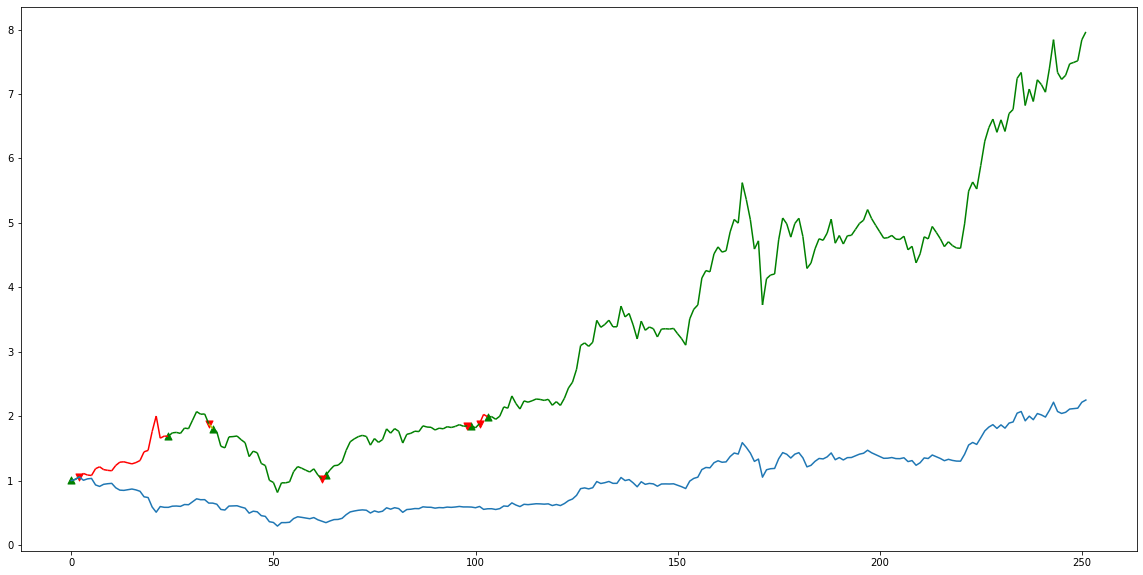

news-set-5 | 4:34:34  | Train | 926  | TSLA  | Agent:   68.0% | Market:   -9.0% | Diff:   77.0% | epsilon:  0.100 | loss: 1.0200745236943476e-05 | iterations: 232853
news-set-5 | 4:34:51  | Train | 927  | TSLA  | Agent:  207.3% | Market:  -25.1% | Diff:  232.4% | epsilon:  0.100 | loss: 1.0347172064939514e-05 | iterations: 233105
news-set-5 | 4:35:08  | Train | 928  | TSLA  | Agent:  123.1% | Market:  -10.3% | Diff:  133.4% | epsilon:  0.100 | loss: 1.0430122529214714e-05 | iterations: 233357
news-set-5 | 4:35:25  | Train | 929  | TSLA  | Agent:  142.1% | Market:  -19.3% | Diff:  161.5% | epsilon:  0.100 | loss: 1.0468200343893841e-05 | iterations: 233609
news-set-5 | 4:35:42  | Train | 930  | TSLA  | Agent:   41.8% | Market:   -2.4% | Diff:   44.2% | epsilon:  0.100 | loss: 1.0497006769583095e-05 | iterations: 233861
news-set-5 | 4:35:59  | Train | 931  | TSLA  | Agent:   34.4% | Market:  -18.6% | Diff:   53.0% | epsilon:  0.100 | loss: 1.050910577760078e-05 | iterations: 234113
news-

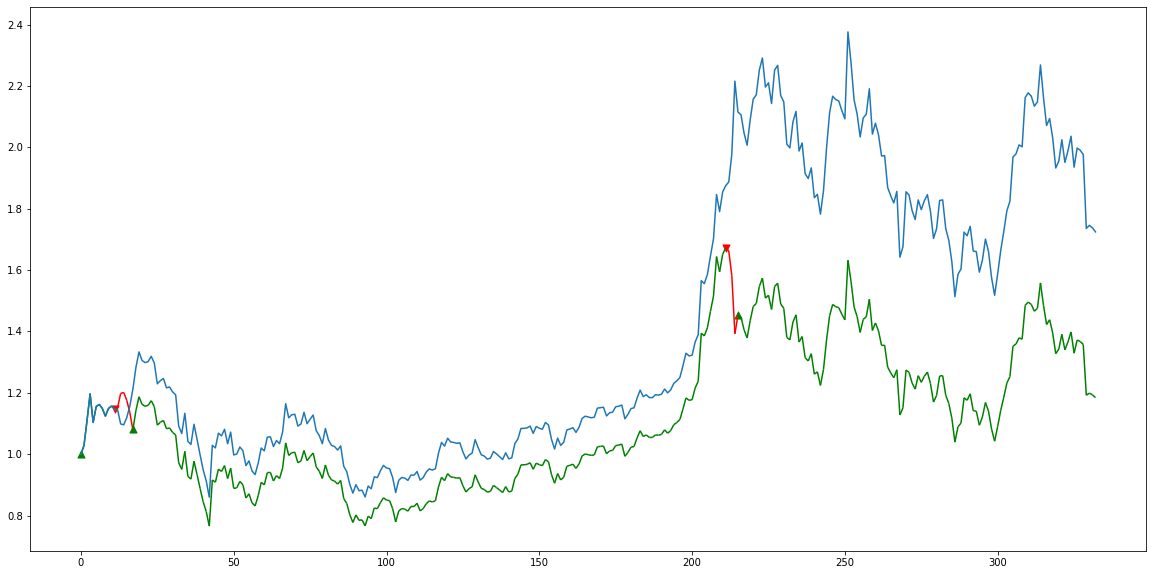

news-set-5 | 4:41:55  | Eval-dev | 950  | TSLA  | Agent:  158.5% | Market:  696.4% | Diff: -538.0% | epsilon:  0.100 | loss: 1.0597649634291884e-05 | iterations: 238901


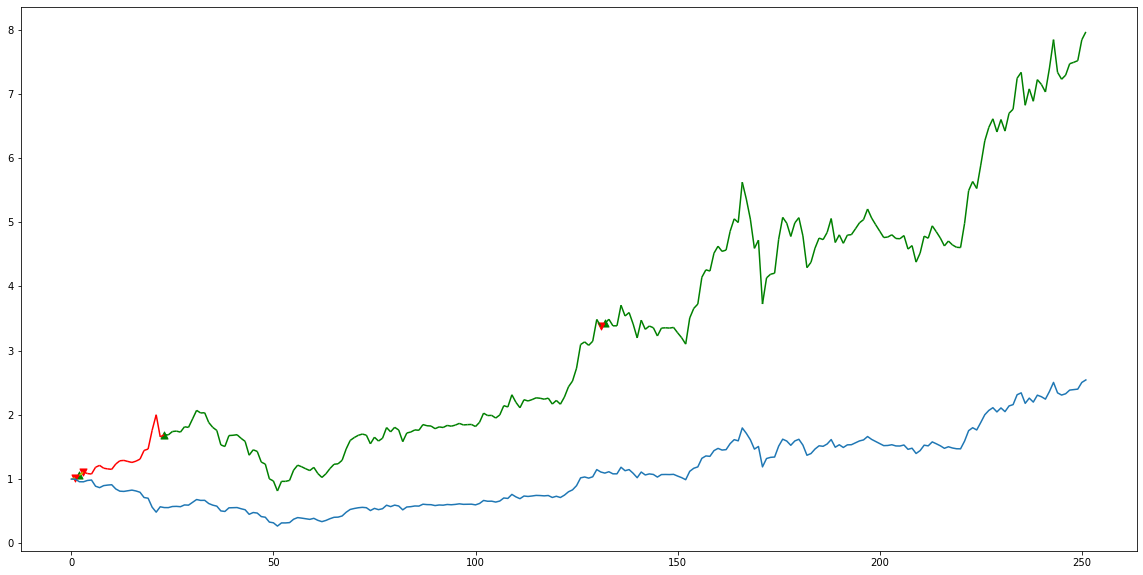

news-set-5 | 4:42:12  | Train | 951  | TSLA  | Agent:   30.8% | Market:  -34.4% | Diff:   65.3% | epsilon:  0.100 | loss: 1.0617229236231651e-05 | iterations: 239153
news-set-5 | 4:42:29  | Train | 952  | TSLA  | Agent:  118.3% | Market:   83.3% | Diff:   35.0% | epsilon:  0.100 | loss: 1.064170828612987e-05 | iterations: 239405
news-set-5 | 4:42:46  | Train | 953  | TSLA  | Agent:  237.8% | Market:  -19.8% | Diff:  257.6% | epsilon:  0.100 | loss: 1.0689501323213335e-05 | iterations: 239657
news-set-5 | 4:43:03  | Train | 954  | TSLA  | Agent:   25.1% | Market:  -15.4% | Diff:   40.5% | epsilon:  0.100 | loss: 1.071160841092933e-05 | iterations: 239909
news-set-5 | 4:43:19  | Train | 955  | TSLA  | Agent:  156.5% | Market:  -16.6% | Diff:  173.0% | epsilon:  0.100 | loss: 1.071437873179093e-05 | iterations: 240161
news-set-5 | 4:43:36  | Train | 956  | TSLA  | Agent:  115.4% | Market:   67.0% | Diff:   48.4% | epsilon:  0.100 | loss: 1.0708078661991749e-05 | iterations: 240413
news-se

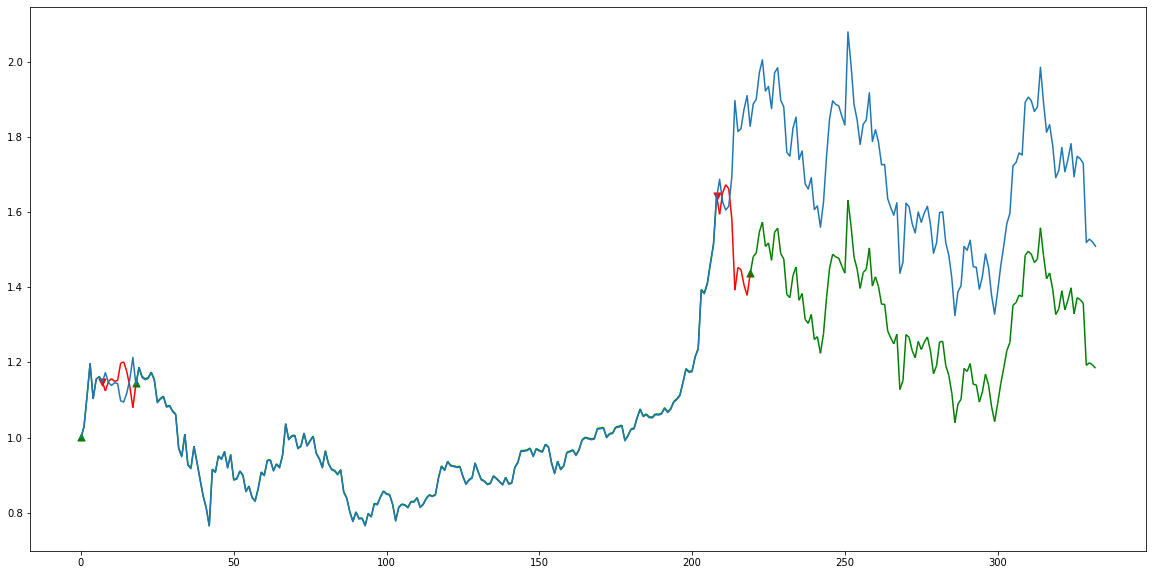

news-set-5 | 4:49:21  | Eval-dev | 975  | TSLA  | Agent:  104.8% | Market:  696.4% | Diff: -591.7% | epsilon:  0.100 | loss: 1.0868760909943376e-05 | iterations: 245201


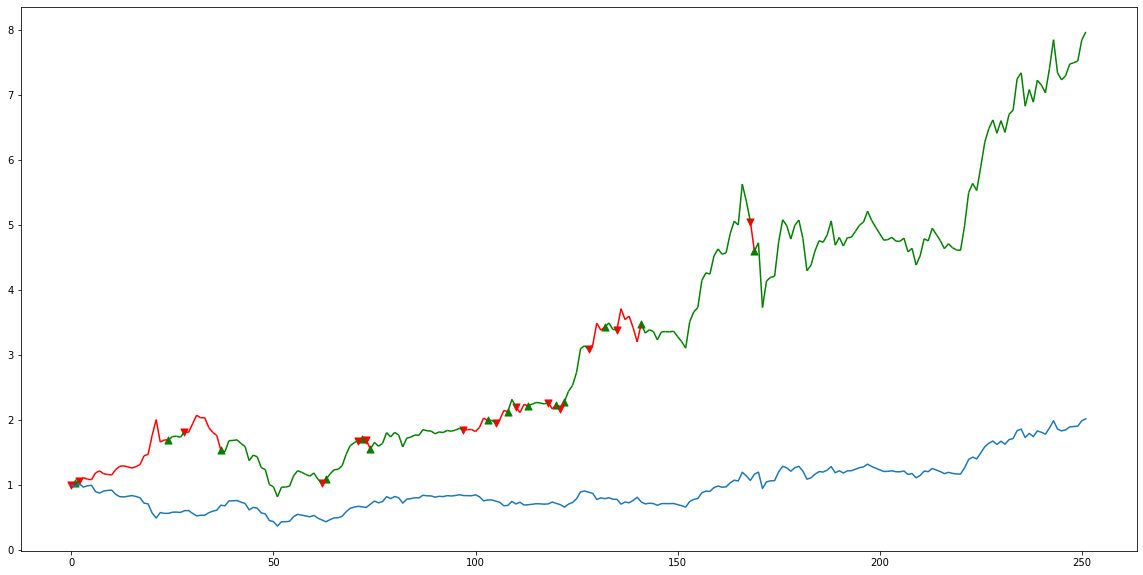

news-set-5 | 4:49:39  | Train | 976  | TSLA  | Agent:  125.5% | Market:   80.8% | Diff:   44.7% | epsilon:  0.100 | loss: 1.0868500794458669e-05 | iterations: 245453
news-set-5 | 4:49:56  | Train | 977  | TSLA  | Agent:    5.7% | Market:   -7.0% | Diff:   12.7% | epsilon:  0.100 | loss: 1.0854113497771323e-05 | iterations: 245705
news-set-5 | 4:50:12  | Train | 978  | TSLA  | Agent:  204.0% | Market:  -26.9% | Diff:  230.9% | epsilon:  0.100 | loss: 1.1005361557181459e-05 | iterations: 245957
news-set-5 | 4:50:29  | Train | 979  | TSLA  | Agent:   12.3% | Market:  -21.6% | Diff:   34.0% | epsilon:  0.100 | loss: 1.1142560651933309e-05 | iterations: 246209
news-set-5 | 4:50:46  | Train | 980  | TSLA  | Agent:  130.8% | Market:   -7.7% | Diff:  138.5% | epsilon:  0.100 | loss: 1.1166193871758878e-05 | iterations: 246461
news-set-5 | 4:51:03  | Train | 981  | TSLA  | Agent:  178.8% | Market:   -7.2% | Diff:  186.0% | epsilon:  0.100 | loss: 1.1159441783092916e-05 | iterations: 246713
news

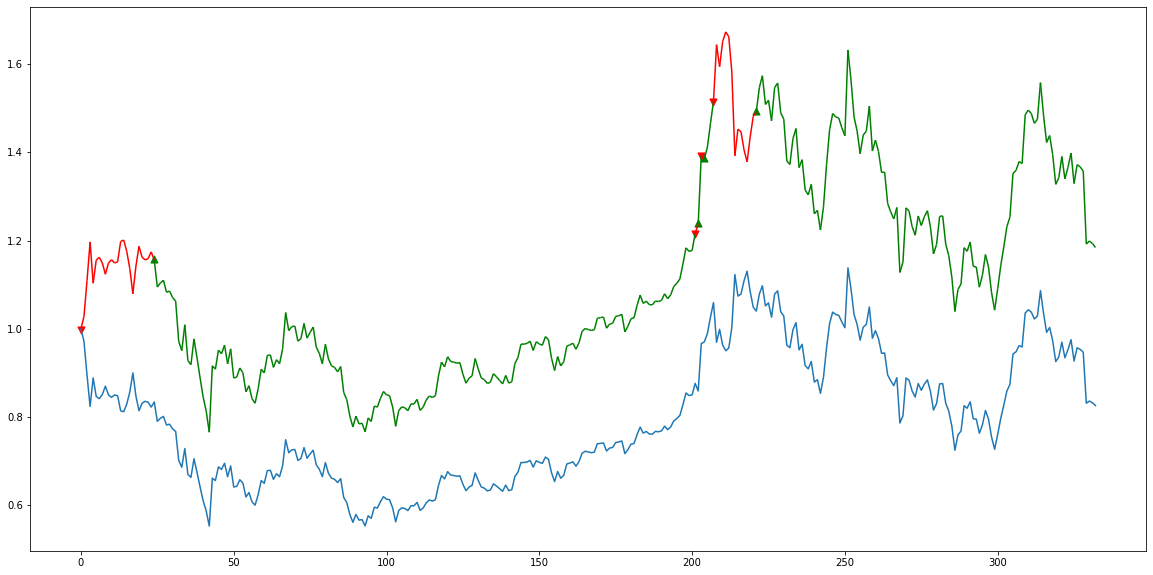

news-set-5 | 4:56:42  | Eval-dev | 1000 | TSLA  | Agent:   92.8% | Market:  696.4% | Diff: -603.6% | epsilon:  0.100 | loss: 1.1355213246133644e-05 | iterations: 251501


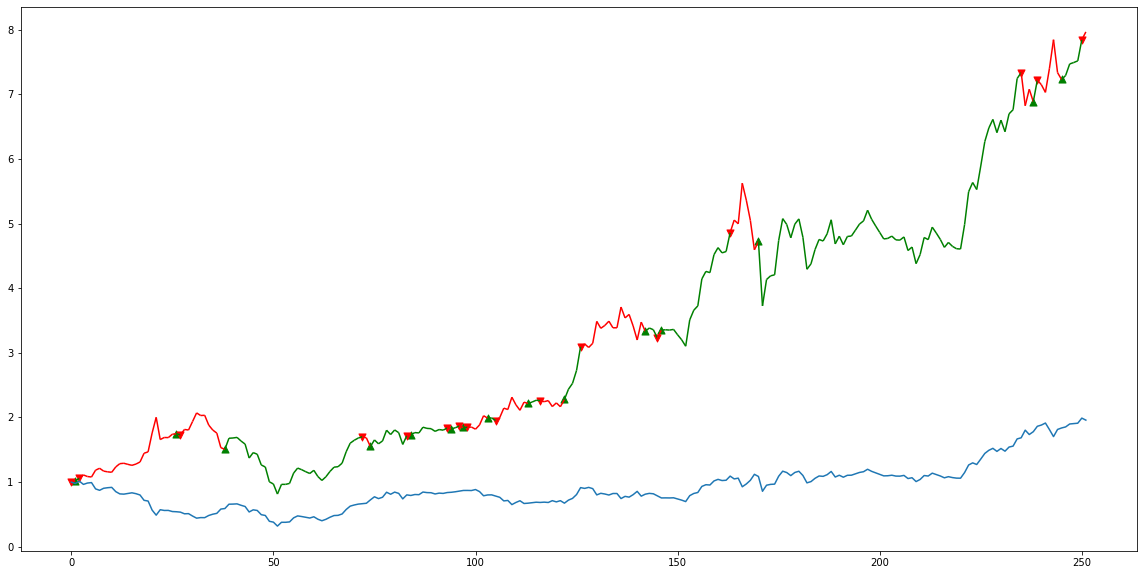

In [10]:
max_episodes = 1000
gamma = .99,  # discount factor
tau = 1000 # target network update frequency

architecture = (512,256)  # units per layer
learning_rate = 0.0001  # learning rate
l2_reg = 1e-6  # L2 regularization

replay_capacity = 1000000 # experience replay buffer

batch_size = 500 # sample for experience replay

epsilon_start = 1
epsilon_end = .1
epsilon_decay_steps = 200
epsilon_exponential_decay = 1


train_trading_days=252

decay_steps = 1 * train_trading_days * max_episodes + batch_size

tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "BRK-A", "TSM", "NVDA", "JPM", "GME"] 
feature_sets = ['core-set', 'news-set-1', 'news-set-2', 'news-set-3', 'news-set-4', 'news-set-5', 'news-set-6', 'twitter-set-1', 'twitter-set-2', 'twitter-set-3', 'twitter-set-4', 'full-set'] #,



num_actions = 3

ddqn = {}

setup_str = f'''
trading_cost_bps: {trading_cost_bps}
time_cost_bps: {time_cost_bps}
max_episodes: {max_episodes}
gamma: {gamma}
tau: {tau}
architecture: {architecture}
learning_rate: {learning_rate}
l2_reg: {l2_reg}
replay_capacity: {replay_capacity}
batch_size: {batch_size}
epsilon_start: {epsilon_start}
epsilon_end: {epsilon_end}
epsilon_decay_steps: {epsilon_decay_steps}
epsilon_exponential_decay: {epsilon_exponential_decay}
num_actions: {num_actions}
tickers: {tickers}
train_trading_days: {train_trading_days}
'''

start_time = datetime.datetime.now()
path = "logs/" + str(start_time)[0:19].replace(' ','_').replace(':','-') + '/'
log = pd.DataFrame()

os.makedirs(path)
with open(path + "setup.txt", "w") as text_file:
    text_file.write(setup_str)


    
for feature_set in feature_sets:
    features = feature_dict[feature_set]
    state_dim = len(features)
    

    for ticker in tickers:
        ddqn[ticker] = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size,
                 decay_steps=decay_steps)
        
        for episode in range(1, max_episodes + 1):
            ddqn[ticker].train = True
            mode = 'Train'
            col = '\x1b[32m'
            trading_environment = gym.make(
                'trading-v0', 
                ticker=ticker,
                trading_days=train_trading_days,
                trading_cost_bps=trading_cost_bps,
                time_cost_bps=time_cost_bps,
                data_path='../data-prep/features/data_train.csv',
                features=features)


            this_state = trading_environment.reset()
            for episode_step in range(trading_environment.spec.max_episode_steps):

                action = ddqn[ticker].epsilon_greedy_policy(this_state.reshape(-1, state_dim))
                next_state, reward, done, _ = trading_environment.step(action)
                ddqn[ticker].memorize_transition(this_state, 
                                        action, 
                                        reward, 
                                        next_state, 
                                        0.0 if done else 1.0)
                ddqn[ticker].experience_replay()

                if done:
                    break
                this_state = next_state

            result = trading_environment.env.simulator.result()
            final = result.iloc[-1]
            nav = final.nav * (1 + final.strategy_return)
            market_nav = final.market_nav
            diff = nav - market_nav
            total_time = datetime.datetime.now()-start_time
            itter = ddqn[ticker].online_network.optimizer.iterations.value()
            loss = ddqn[ticker].online_network.losses[-1]          
            template = col + '{} | {:<8} | {:<5} | {:<4} | {:<5} | Agent: {:>7.1%} | Market: {:>7.1%} | Diff: {:>7.1%} | epsilon: {:>6.3f} | loss: {} | iterations: {}'  + col
            print(template.format(feature_set, str(total_time)[0:7], mode, episode, ticker, nav-1, market_nav-1, diff, ddqn[ticker].epsilon, loss,itter))

            log = pd.concat([
                log,
                pd.DataFrame.from_dict(
                    {
                        "mode":[mode],
                        "feature_set":[feature_set],
                        "episode":[episode],
                        "ticker":[ticker],
                        "nav":[nav-1],
                        "market_nav":[market_nav-1],
                        "diff":[diff],
                        "epsilon":[ddqn[ticker].epsilon],
                        "loss":[loss],
                        "itterations":[itter]
                    }
                )])


            if episode % 25 == 0:
                ddqn[ticker].train = False
                col = "\x1b[33m"
                for data_type in ['test','dev']:
                    mode = 'Eval-'+data_type
                    lens = {'train':1225,'dev':252,'test':333}
                    trading_environment = gym.make(
                        'trading-v0',
                        ticker=ticker,
                        trading_days=lens[data_type],
                        trading_cost_bps=trading_cost_bps,
                        time_cost_bps=time_cost_bps,
                        data_path=f'../data-prep/features/data_{data_type}.csv',
                        features=features)

                    this_state = trading_environment.reset()
                    for episode_step in range(trading_environment.spec.max_episode_steps):
                        action = ddqn[ticker].greedy_policy(this_state.reshape(-1, state_dim))
                        next_state, reward, done, _ = trading_environment.step(action)
                        if done:
                            break
                        this_state = next_state

                    result = trading_environment.env.simulator.result()
                    final = result.iloc[-1]
                    nav = final.nav * (1 + final.strategy_return)
                    market_nav = final.market_nav
                    diff = nav - market_nav
                    total_time = datetime.datetime.now()-start_time
                    itter = ddqn[ticker].online_network.optimizer.iterations.value()
                    loss = ddqn[ticker].online_network.losses[-1]

                    template = col + '{} | {:<8} | {:<5} | {:<4} | {:<5} | Agent: {:>7.1%} | Market: {:>7.1%} | Diff: {:>7.1%} | epsilon: {:>6.3f} | loss: {} | iterations: {}'  + col
                    print(template.format(feature_set, str(total_time)[0:7], mode, episode, ticker, nav-1, market_nav-1, diff, ddqn[ticker].epsilon, loss,itter))

                    log = pd.concat([
                        log,
                        pd.DataFrame.from_dict(
                            {
                                "mode":[mode],
                                "feature_set":[feature_set],
                                "episode":[episode],
                                "ticker":[ticker],
                                "nav":[nav-1],
                                "market_nav":[market_nav-1],
                                "diff":[diff],
                                "epsilon":[ddqn[ticker].epsilon],
                                "loss":[loss],
                                "itterations":[itter]
                            }
                        )])
                        

                    visualize(result)

                log.to_csv(path + "logs.csv")
                ddqn[ticker].online_network.save(path + "models/" + ticker + "/" + feature_set + ".h5")
                
                if (episode>=100) & (data_type=='dev') & (nav > (market_nav * 1.1)):

                    break


    trading_environment.close()